# Analiza danych meteorologicznych w Polsce w okresie 1951-2020

# Źrodło danych i import z pliku

Dane meteorologiczne zarejestrowane w Polsce w okresie 1951-2020 pobrałem ze strony Instytutu Meteorologii i Gospodarki Wodnej (https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/miesieczne/klimat/, data dostępu: 5.01.2021 r.). Interesowały mnie dane zawierające miesięczne podsumowania z różnych stacji meteorologicznych w Polsce, w szczególności temperatura powietrza, opad deszczu i śniegu oraz liczba dni deszczowych, śnieżnych oraz z utrzymującą pokrywą śnieżną.
Szczegółowe dane archiwalne udostępnione przez IMGW zostały podzielone na wiele plików, dlatego po pobraniu danych, a przed wczytaniem ich do analizy, uwtorzyłem z nich pojedynczy plik 'd_data.csv' zawierający dane ze wszystkich plików oznaczonych literą 'd'. Dodałem również nazwy kolumn zgodnie z instrukcją instytutu 'k_m_d_format.txt' umieszczoną w powyższym linku.

In [1]:
rawData <- read.csv('d_data.csv')

In [2]:
head(rawData)

,code,station,year,month,abs_max_temp,tmax_status,avg_max_temp,tmxs_status,abs_min_temp,tmin_status,...,summ_status,max_daily_rain,opmx_status,first_rainy_day,last_rainy_day,max_snow,pksn_status,ice_sheet_days,rainy_days,snowy_days
,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,...,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,249200180,LIMANOWA,1952,1,7.8,NA,2.3,NA,-17.0,NA,...,NA,10.8,NA,21,NA,19,NA,22,3,16
2,249200180,LIMANOWA,1952,2,4.7,NA,0.3,NA,-17.0,NA,...,NA,15.1,NA,26,NA,62,NA,29,2,23
3,249200180,LIMANOWA,1952,3,10.6,NA,1.7,NA,-22.5,NA,...,NA,17.7,NA,26,NA,60,NA,31,2,16
4,249200180,LIMANOWA,1952,4,25.6,NA,16.0,NA,-10.7,NA,...,NA,12.2,NA,25,NA,38,NA,7,7,2
5,249200180,LIMANOWA,1952,5,24.3,NA,15.6,NA,-2.4,NA,...,NA,11.8,NA,24,NA,0,NA,0,14,6
6,249200180,LIMANOWA,1952,6,28.7,NA,20.6,NA,2.1,NA,...,NA,13.4,NA,3,NA,0,NA,0,16,0


In [3]:
colnames(rawData)

[1] "code"            "station"         "year"            "month"          
 [5] "abs_max_temp"    "tmax_status"     "avg_max_temp"    "tmxs_status"    
 [9] "abs_min_temp"    "tmin_status"     "avg_min_temp"    "tmns_status"    
[13] "avg_temp"        "stm_status"      "ground_min_temp" "tmng_status"    
[17] "rain"            "summ_status"     "max_daily_rain"  "opmx_status"    
[21] "first_rainy_day" "last_rainy_day"  "max_snow"        "pksn_status"    
[25] "ice_sheet_days"  "rainy_days"      "snowy_days"

In [4]:
summary(rawData)

      code             station               year          month       
 Min.   :249180010   Length:120435      Min.   :1951   Min.   : 1.000  
 1st Qu.:250150220   Class :character   1st Qu.:1970   1st Qu.: 3.000  
 Median :251170090   Mode  :character   Median :1987   Median : 6.000  
 Mean   :259664629                      Mean   :1986   Mean   : 6.485  
 3rd Qu.:253169997                      3rd Qu.:2001   3rd Qu.: 9.000  
 Max.   :354220195                      Max.   :2020   Max.   :12.000  
                                                                       
  abs_max_temp     tmax_status      avg_max_temp     tmxs_status    
 Min.   :-99.90   Min.   :8        Min.   :-12.40   Min.   :8       
 1st Qu.: 12.10   1st Qu.:8        1st Qu.:  4.30   1st Qu.:8       
 Median : 21.40   Median :8        Median : 12.70   Median :8       
 Mean   : 19.87   Mean   :8        Mean   : 12.10   Mean   :8       
 3rd Qu.: 27.70   3rd Qu.:8        3rd Qu.: 20.05   3rd Qu.:8       
 Max.   : 

# Wczytanie do bazy i czyszczenie danych

Używane zewnętrzne biblioteki:

In [5]:
library(DBI)
library(ggplot2)
library(cowplot)
library(corrplot)
library(GGally)
library(ggpubr)
library(fitdistrplus)
library(plot3D)
library(forecast)
library(FRAPO)

Tworzę bazę danych SQLite, a w niej tabelę 'meteorological_data' z danymi

In [6]:
db <- dbConnect(RSQLite::SQLite(), "db.sqlite")

In [7]:
dbWriteTable(db, "meteorological_data", rawData)

Do analizy będę używał tylko kolumny zawierające następujące dane:
- Rok
- Miesiąc
- Absolutna temperatura maksymalna [°C]
- Średnia temperatura maksymalna [°C]
- Absolutna temperatura minimalna [°C]
- Średnia temperatura minimalna  [°C]
- Średnia temperatura miesięczna  [°C]
- Miesięczna suma opadów  [mm]
- Maksymalna dobowa suma opadów [mm]
- Maksymalna wysokość pokrywy śnieżnej [cm]
- Liczba dni z pokrywą śnieżną
- Liczba dni z opadem deszczu
- Liczba dni z opadem śniegu

Odrzuciłem kolumny zawierające pierwszy oraz ostatni dzień wystąpienia opadu maksymalnego, gdyż nie wnoszą one istotnych informacji z punktu widzenia mojej analizy. Nie biorę również pod uwagę kolumny z minimalną temperaturą przy gruncie ze względu na częsty brak pomiaru tej wielkości. Podobnie kolumny ze statusem pomiaru nie będą potrzebne w późniejszej analizie.

Zdarza się, iż pomiar nie został z pewnych względów dokonany, co jest oznaczane przez brak danej wartości w kolumnie lub oznaczenie 8/9 w kolumnie statusu - wówczas nie biorę pomiaru pod uwagę. Dane, które zgromadziłem, pochodzą z wielu stacji na terenie całej Polski. Ponieważ interesuje mnie sytuacja w całym kraju, będę brał średnią, maksimum lub minimum ze wszsytkich stacji, które dokonały pomiarów w danym miesiącu.

Dane wczytałem do dwóch zmiennych - jedna zawiera dane z dokładnością do miesiąca, a druga z dokładnością do jednego roku.

In [8]:
data <- dbGetQuery(db, '
    SELECT year, month, 
    max(abs_max_temp) AS abs_max_temp, 
    avg(avg_max_temp) AS avg_max_temp, 
    min(abs_min_temp) AS abs_min_temp, 
    avg(avg_min_temp) AS avg_min_temp, 
    avg(avg_temp) AS avg_temp, 
    avg(rain) AS rain, 
    max(max_daily_rain) AS max_daily_rain, 
    max(max_snow) AS max_snow, 
    avg(ice_sheet_days) AS ice_sheet_days, 
    avg(rainy_days) AS rainy_days, 
    avg(snowy_days) AS snowy_days
    FROM meteorological_data
    GROUP BY year, month
')

In [9]:
years <- dbGetQuery(db, '
    SELECT year, 
    max(abs_max_temp) AS abs_max_temp, 
    avg(avg_max_temp) AS avg_max_temp, 
    min(abs_min_temp) AS abs_min_temp, 
    avg(avg_min_temp) AS avg_min_temp, 
    avg(avg_temp) AS avg_temp, 
    avg(rain) AS rain, 
    max(max_daily_rain) AS max_daily_rain, 
    max(max_snow) AS max_snow, 
    NULL AS ice_sheet_days, 
    NULL AS rainy_days, 
    NULL AS snowy_days
    FROM meteorological_data as outer
    GROUP BY year
')

temp <- dbGetQuery(db, '
    SELECT year, month, 
    avg(ice_sheet_days) AS ice_sheet_days, 
    avg(rainy_days) AS rainy_days, 
    avg(snowy_days) AS snowy_days
    FROM meteorological_data
    GROUP BY year, month
')

for (i in 1:length(years$year)) {
    years$ice_sheet_days[i] <- sum(temp[temp[, 'year'] == years$year[i],]$ice_sheet_days)
    years$rainy_days[i] <- sum(temp[temp[, 'year'] == years$year[i],]$rainy_days)
    years$snowy_days[i] <- sum(temp[temp[, 'year'] == years$year[i],]$snowy_days)
}

remove(temp)

In [10]:
dbDisconnect(db)

In [11]:
head(data)

,year,month,abs_max_temp,avg_max_temp,abs_min_temp,avg_min_temp,avg_temp,rain,max_daily_rain,max_snow,ice_sheet_days,rainy_days,snowy_days
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1951,1,11.7,0.9654762,-25.5,-4.277381,-1.4488095,37.92381,21.9,149,13.1785714,5.809524,9.47619048
2,1951,2,14.2,2.5917647,-18.8,-2.684706,-0.1941176,29.36471,23.8,150,8.6588235,3.282353,7.96470588
3,1951,3,19.7,3.8705882,-19.5,-3.000000,0.4152941,48.81176,34.0,175,12.3764706,6.294118,8.90588235
4,1951,4,26.7,13.5070588,-11.9,2.315294,7.7941176,34.78000,37.9,168,0.7764706,8.329412,1.10588235
5,1951,5,27.1,15.7200000,-7.1,6.154118,10.9858824,66.42588,84.7,94,0.3411765,12.188235,0.24705882
6,1951,6,32.8,21.9047059,-3.4,10.415294,16.4588235,53.53176,63.8,0,0.0000000,11.058824,0.02352941


In [12]:
head(years)

,year,abs_max_temp,avg_max_temp,abs_min_temp,avg_min_temp,avg_temp,rain,max_daily_rain,max_snow,ice_sheet_days,rainy_days,snowy_days
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1951,33.9,12.647399,-25.5,3.843474,8.263788,40.86752,84.7,175,38.07269,100.44482,33.11148
2,1952,37.1,10.805321,-24.9,2.824128,6.965138,57.89495,59.1,290,79.76032,123.72454,61.04408
3,1953,33.7,12.498895,-27.3,3.504880,8.130479,41.49742,67.1,234,58.31575,94.34083,38.98301
4,1954,35.6,10.925045,-34.4,2.593405,6.745098,48.94287,126.4,165,68.19892,115.94200,42.80062
5,1955,31.7,11.126257,-24.8,2.830350,7.008014,51.77613,125.5,312,80.50274,103.63097,58.16979
6,1956,33.6,9.784018,-36.9,1.788856,5.931891,54.26965,93.1,295,76.41857,104.91500,62.30034


In [13]:
summary(data)

      year          month         abs_max_temp    avg_max_temp   
 Min.   :1951   Min.   : 1.000   Min.   : 6.50   Min.   :-7.265  
 1st Qu.:1968   1st Qu.: 3.250   1st Qu.:17.00   1st Qu.: 4.401  
 Median :1985   Median : 6.000   Median :25.75   Median :12.767  
 Mean   :1985   Mean   : 6.488   Mean   :24.42   Mean   :12.158  
 3rd Qu.:2003   3rd Qu.: 9.000   3rd Qu.:31.98   3rd Qu.:20.111  
 Max.   :2020   Max.   :12.000   Max.   :39.00   Max.   :27.895  
  abs_min_temp     avg_min_temp        avg_temp            rain        
 Min.   :-39.00   Min.   :-16.208   Min.   :-11.430   Min.   :  2.465  
 1st Qu.:-20.10   1st Qu.: -1.609   1st Qu.:  1.356   1st Qu.: 35.294  
 Median : -9.85   Median :  3.377   Median :  7.760   Median : 51.167  
 Mean   :-11.88   Mean   :  3.467   Mean   :  7.661   Mean   : 57.318  
 3rd Qu.: -2.50   3rd Qu.:  9.351   3rd Qu.: 14.678   3rd Qu.: 73.580  
 Max.   :  3.50   Max.   : 14.572   Max.   : 20.971   Max.   :229.684  
 max_daily_rain      max_snow     

In [14]:
summary(years)

      year       abs_max_temp    avg_max_temp     abs_min_temp   
 Min.   :1951   Min.   :31.70   Min.   : 9.784   Min.   :-39.00  
 1st Qu.:1968   1st Qu.:34.50   1st Qu.:11.406   1st Qu.:-32.70  
 Median :1986   Median :35.60   Median :12.104   Median :-29.00  
 Mean   :1986   Mean   :35.73   Mean   :12.159   Mean   :-29.68  
 3rd Qu.:2003   3rd Qu.:37.17   3rd Qu.:12.866   3rd Qu.:-27.05  
 Max.   :2020   Max.   :39.00   Max.   :15.743   Max.   :-17.20  
  avg_min_temp      avg_temp           rain       max_daily_rain  
 Min.   :1.789   Min.   : 5.932   Min.   :40.87   Min.   : 59.10  
 1st Qu.:2.906   1st Qu.: 7.027   1st Qu.:51.38   1st Qu.: 91.67  
 Median :3.495   Median : 7.664   Median :57.98   Median :107.50  
 Mean   :3.465   Mean   : 7.659   Mean   :57.34   Mean   :117.65  
 3rd Qu.:3.962   3rd Qu.: 8.185   3rd Qu.:61.71   3rd Qu.:131.82  
 Max.   :5.525   Max.   :10.282   Max.   :82.55   Max.   :223.50  
    max_snow     ice_sheet_days     rainy_days       snowy_days   
 M

# Wizualizacja danych

Wykresy przedstawiające jednocześnie wszystkie miesiące od 1951 do 2020 roku są nieczytelne, zatem wybrane zestawienia będę prezentował ze względu na poszczególne miesiące oraz podsumowujące całe lata. Do wykresu dodaję linię trendu, aby zwizualizować kierunek zmian w pomiarach.

In [15]:
months <- list()

for (i in 1:12) {
    months[[i]] <- data[data$month == i, ]
}

names <- c("Styczeń", "Luty", "Marzec", "Kwiecień", "Maj", "Czerwiec", "Lipiec", "Sierpień", "Wrzesień", "Październik", "Listopad", "Grudzień")

In [16]:
plot_yearly <- function(value, color, label, limits) {
    p1 <- ggplot(years, aes_string(y = value)) + 
        labs(y = '', x = '', title = 'Wykres pudełkowy (wartości)') + 
        geom_boxplot()
    
    p2 <- ggplot(years, aes_string(value)) + 
        labs(y = '', x = '', title = 'Histogram (gęstość rozkładu)') + 
        geom_histogram(aes(y=..density..), bins = length(years[[value]]) / 2, fill = 'gray', color = 'black') +
        geom_density(alpha = 0.2, fill = color) 
    
    print(ggplot(years, aes_string('year', value)) + 
        labs(y = label, x = 'Rok', title = 'Podsumowanie roczne') + 
        geom_line(col = color) + 
        stat_smooth(method = lm, formula = y ~ x) +
        lims(y = limits))
    
    print(plot_grid(p1, p2))
}

plot_stats <- function(value, color, label, limits) {
    plot_yearly(value, color, label, limits)
    
    for (i in c(1, 3, 5, 7, 9, 11)) {
        p1 <- ggplot(months[[i]], aes_string('year', value)) + 
            labs(y = label, x = 'Rok', title = names[[i]]) + 
            geom_line(col = color) + 
            stat_smooth(method = lm, formula = y ~ x) +
            lims(y = limits)
        
        p2 <- ggplot(months[[i + 1]], aes_string('year', value)) + 
            labs(y = label, x = 'Rok', title = names[[i + 1]]) + 
            geom_line(col = color) + 
            stat_smooth(method = lm, formula = y ~ x) +
            lims(y = limits)
        
        print(plot_grid(p1, p2))
    }
}

## Średnia temperatura

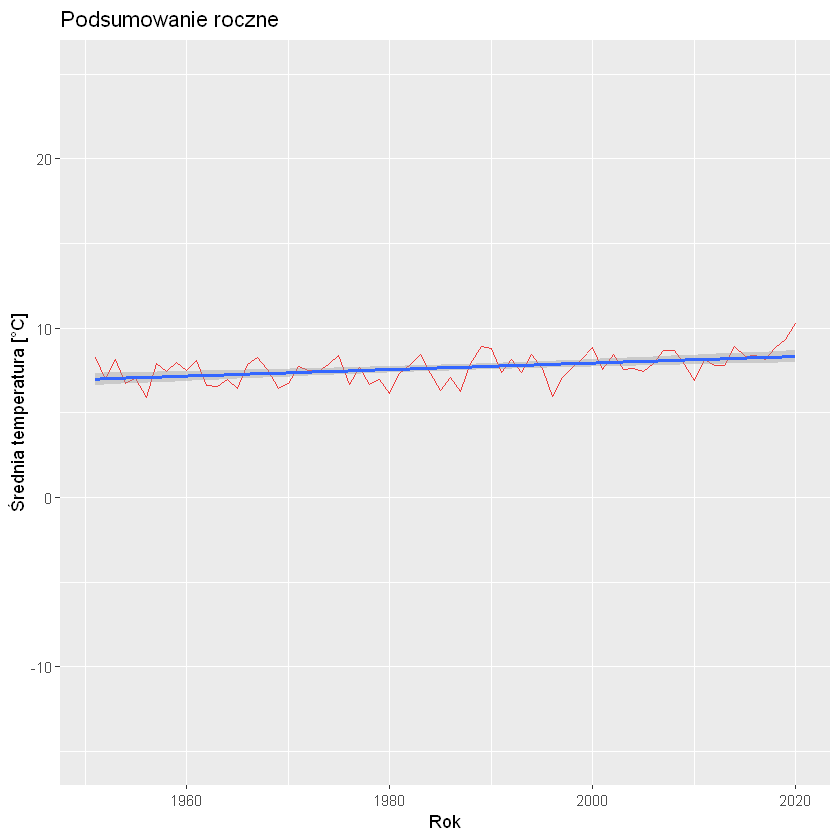

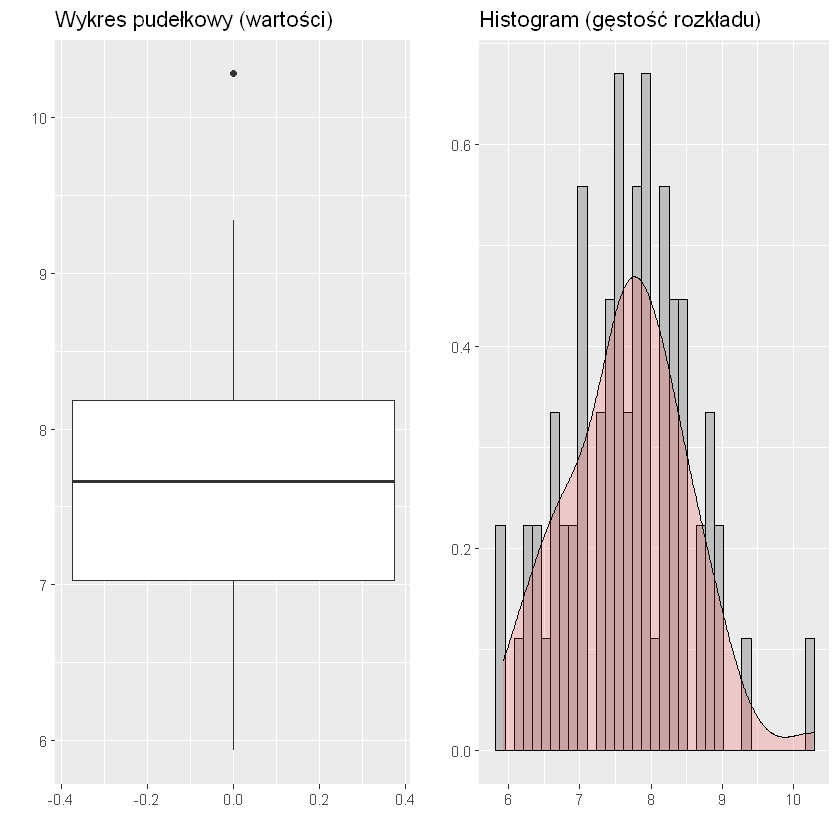

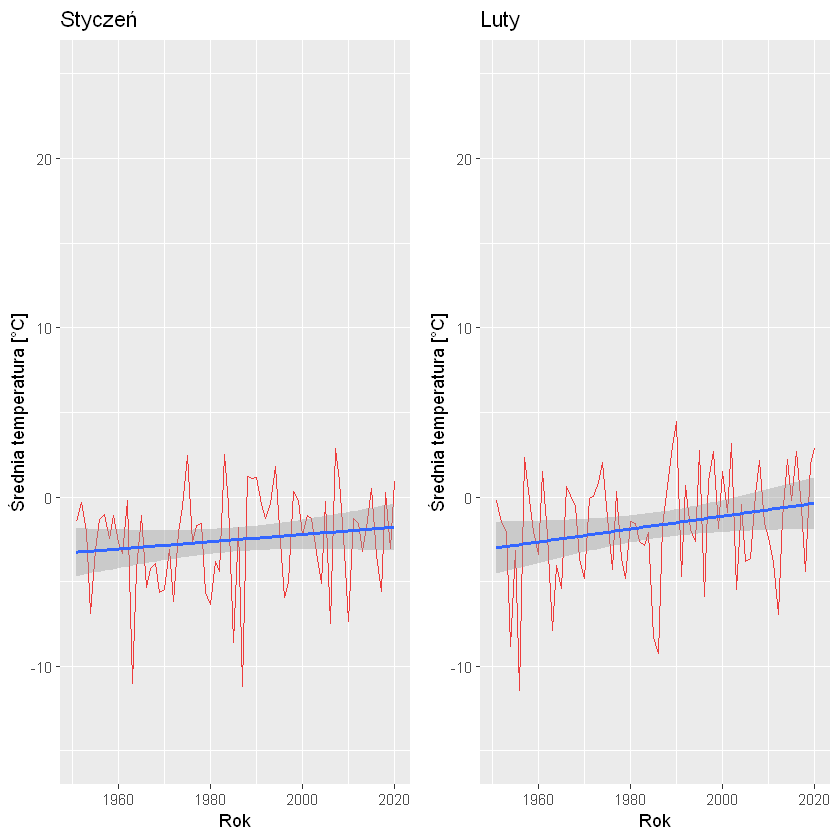

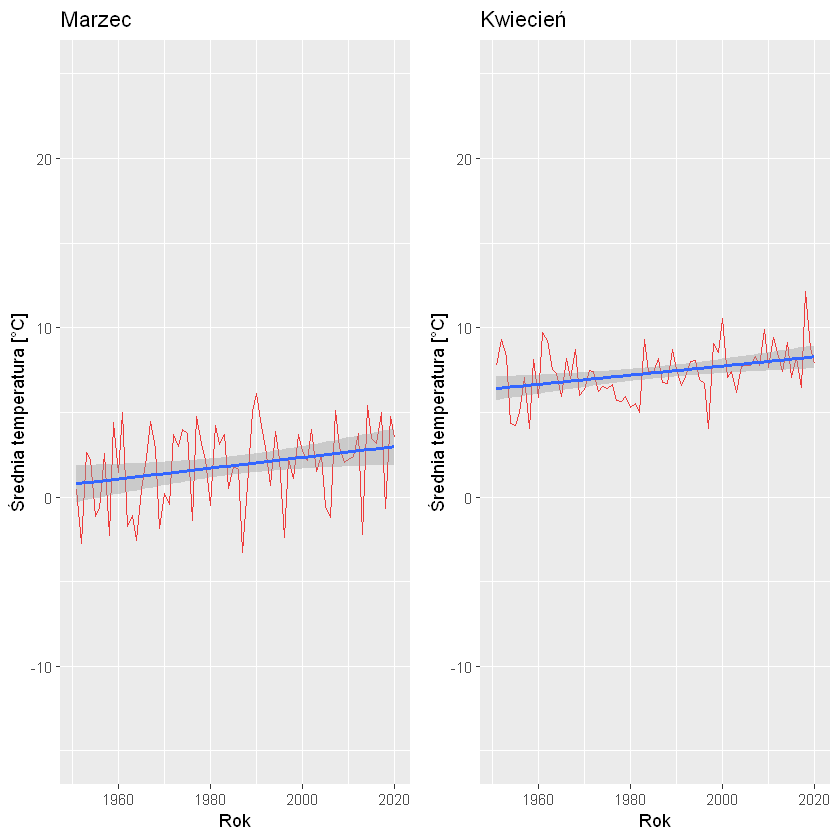

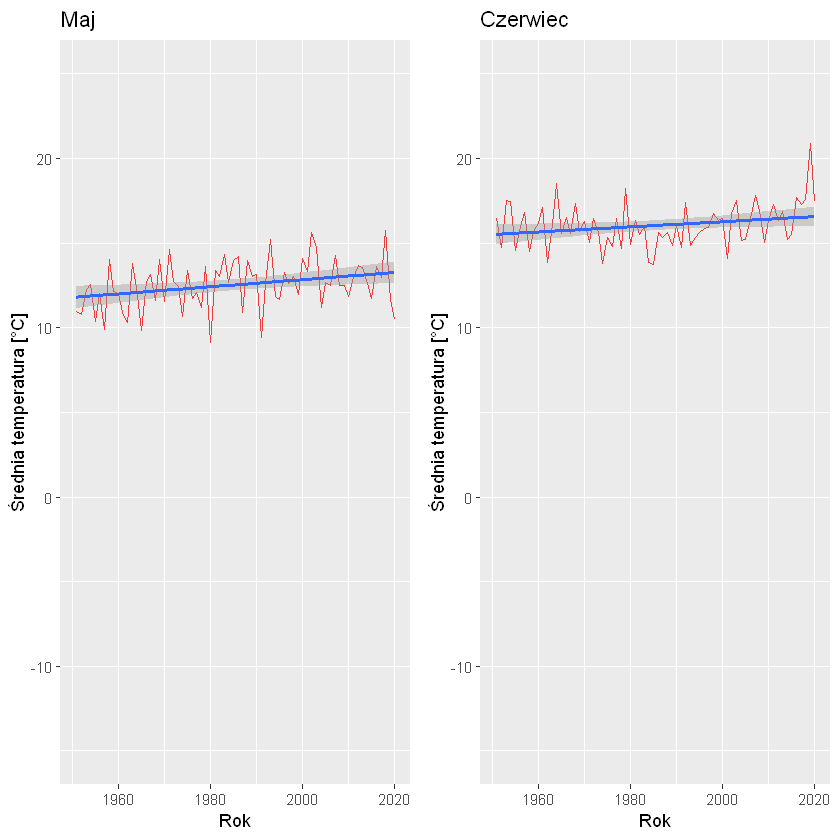

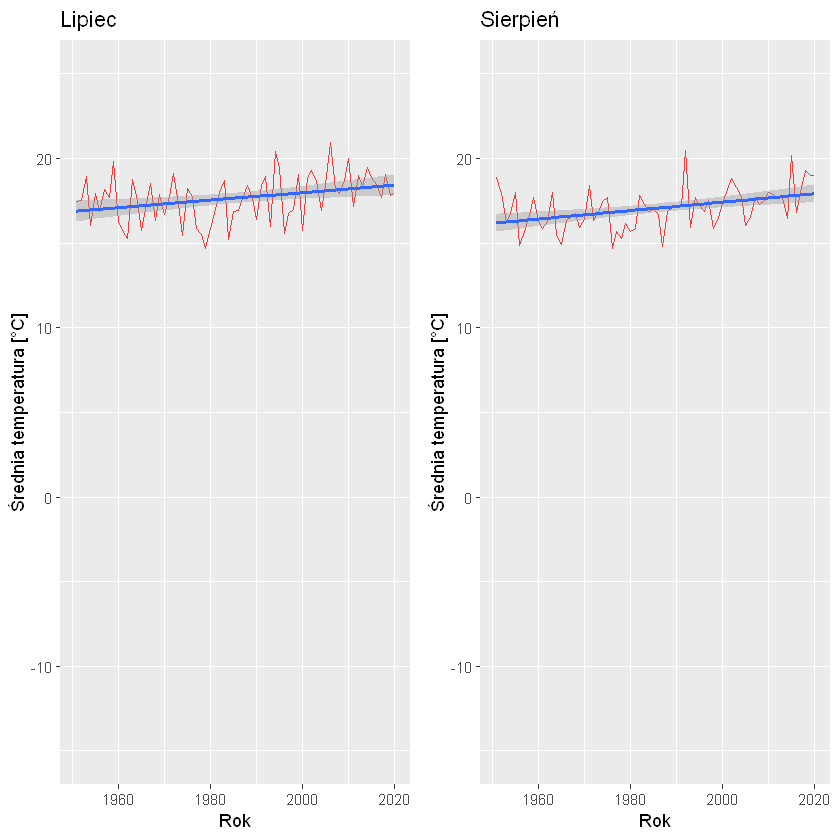

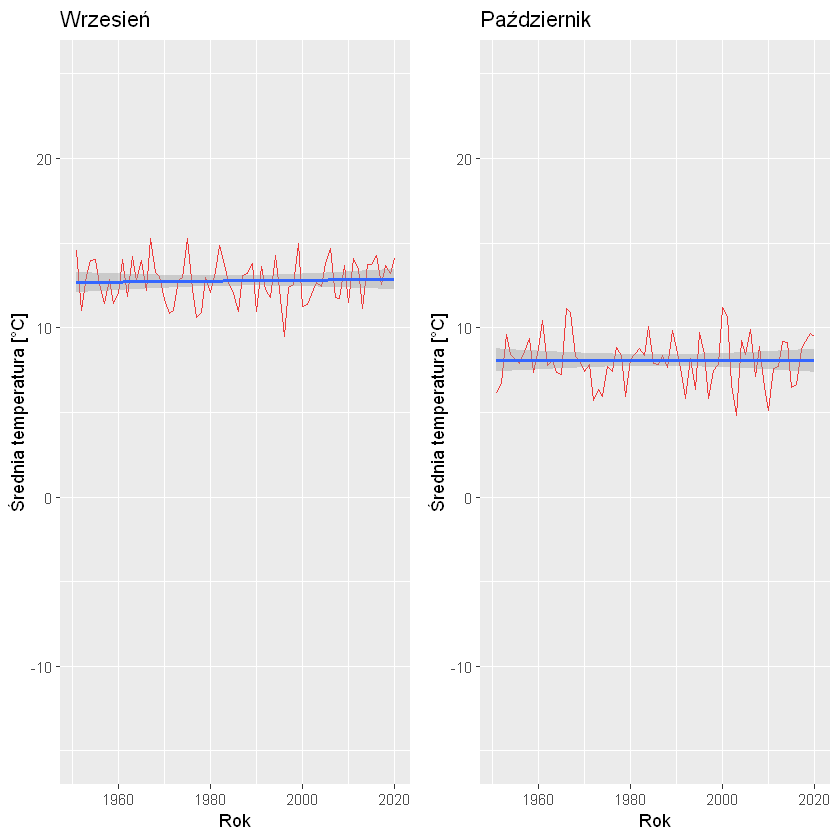

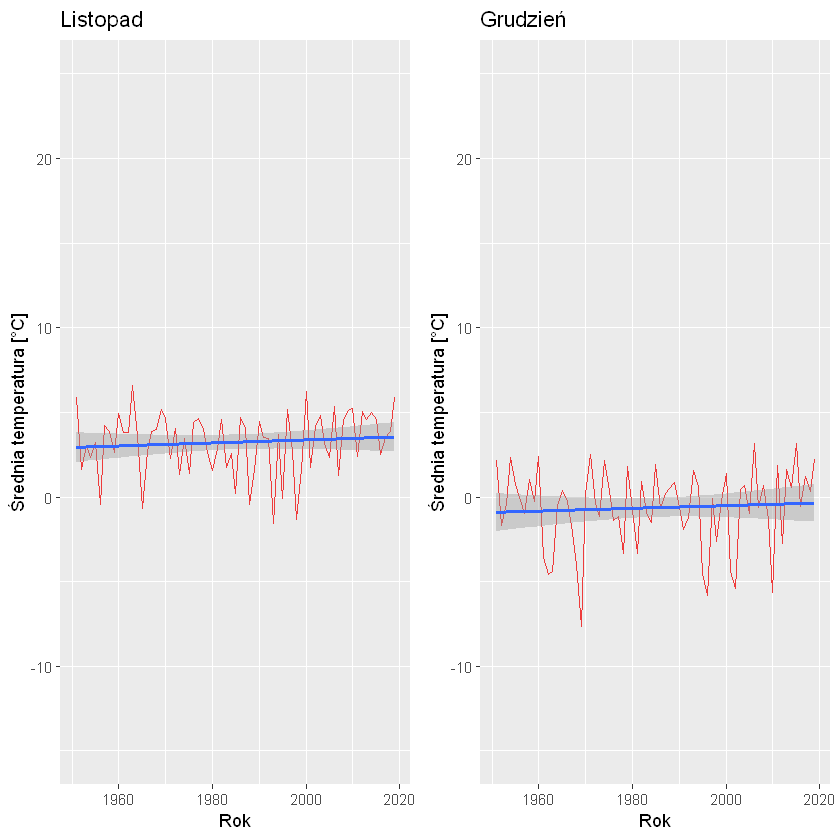

In [17]:
plot_stats("avg_temp", "brown2", "Średnia temperatura [°C]", c(-15, 25))

## Średni opad deszczu

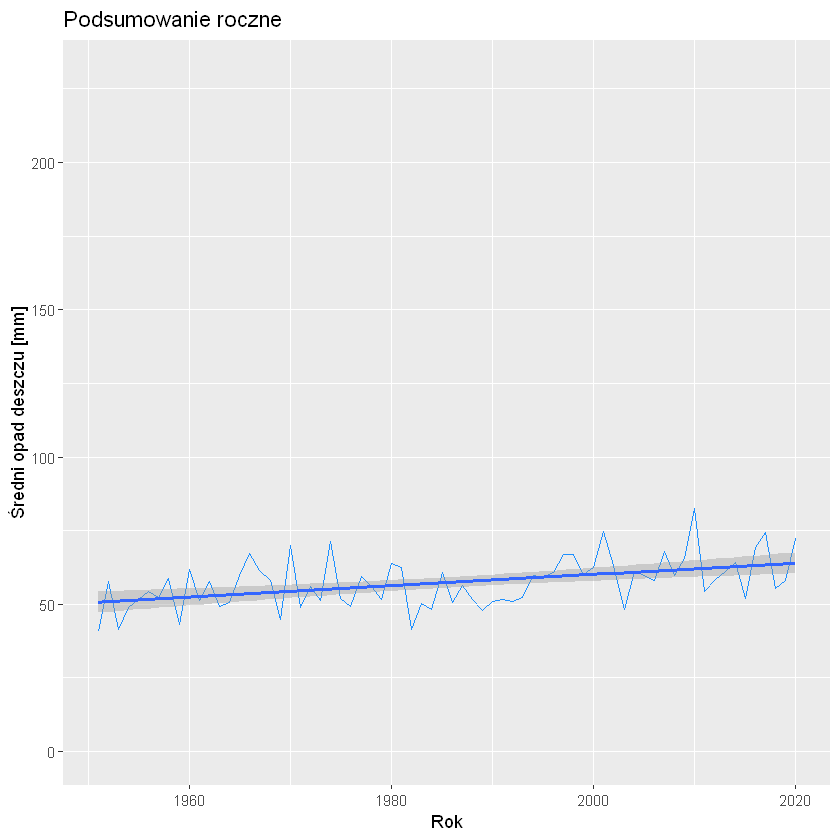

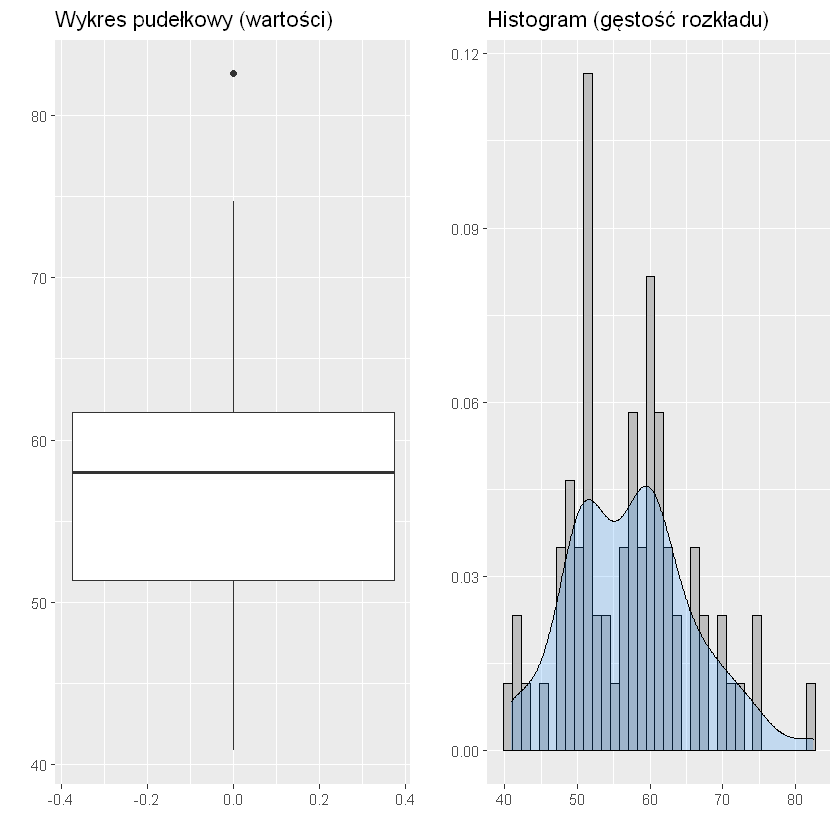

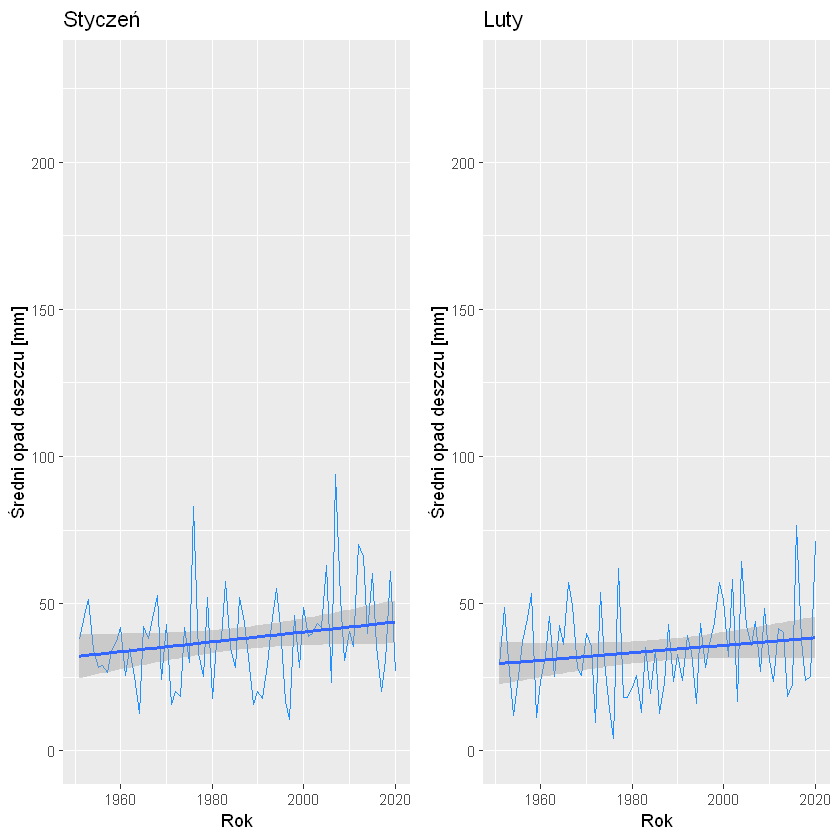

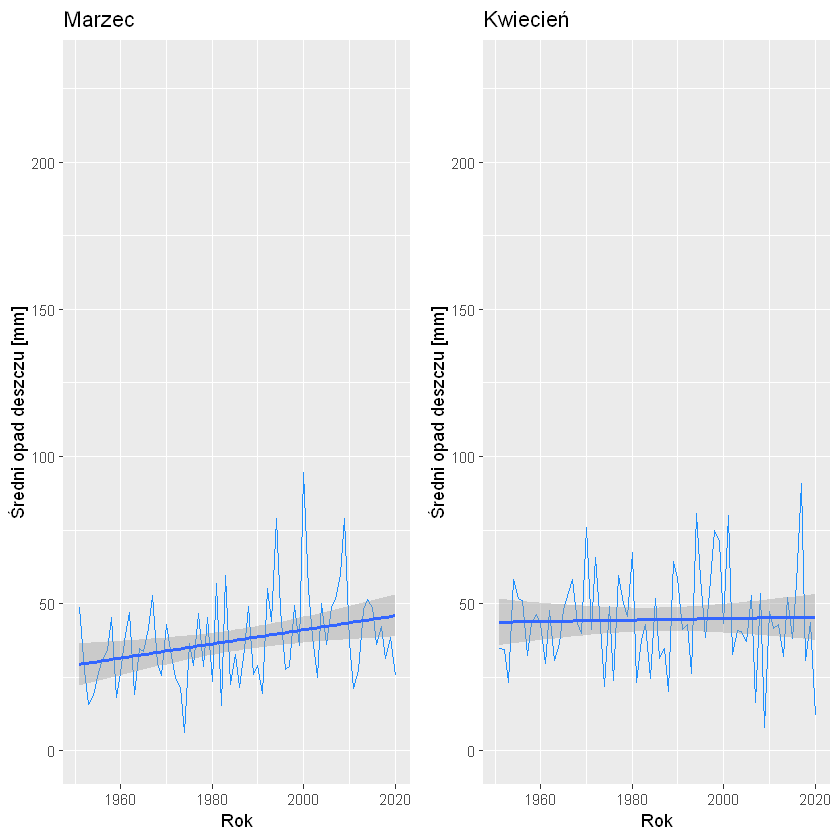

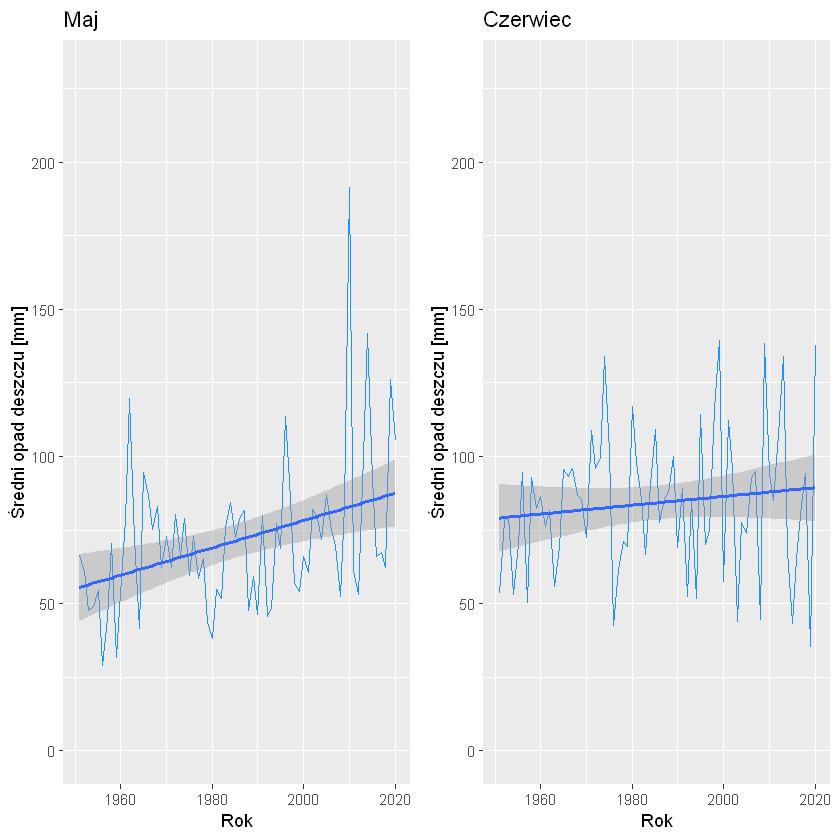

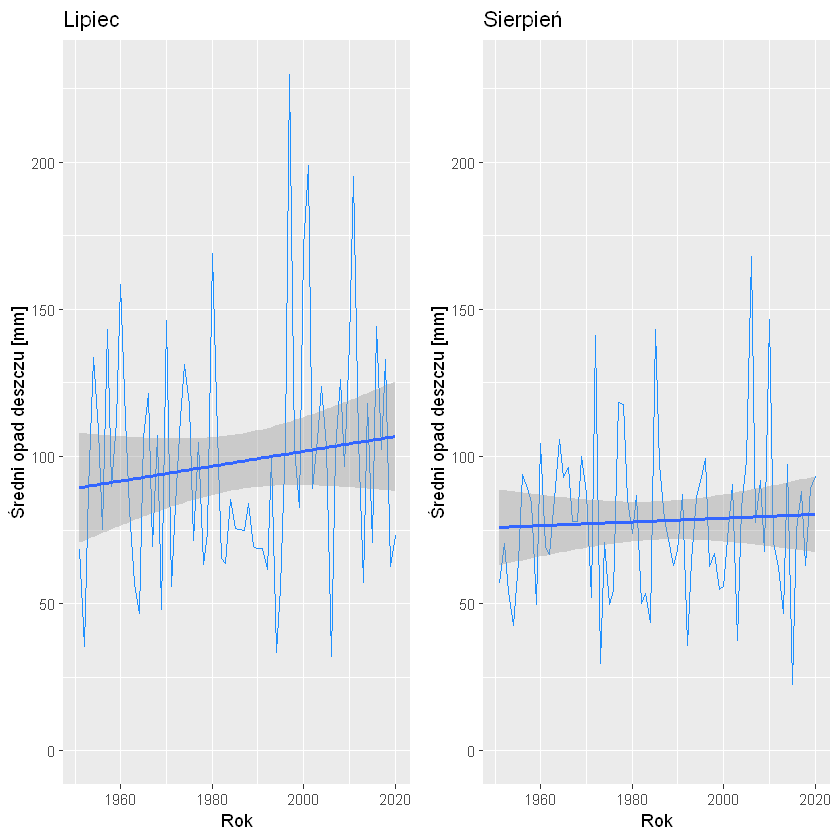

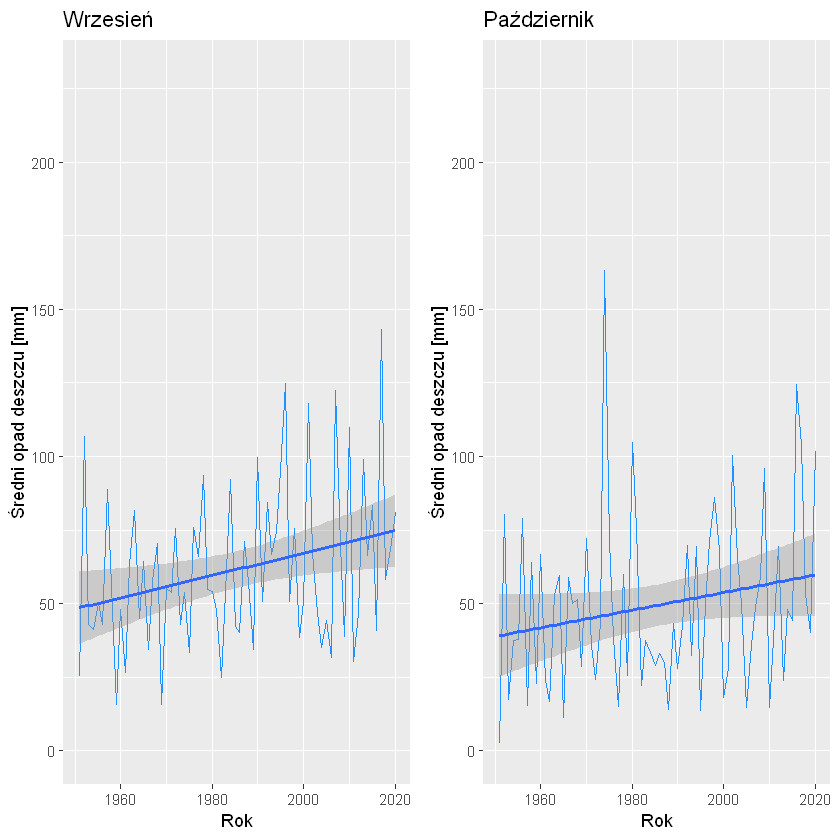

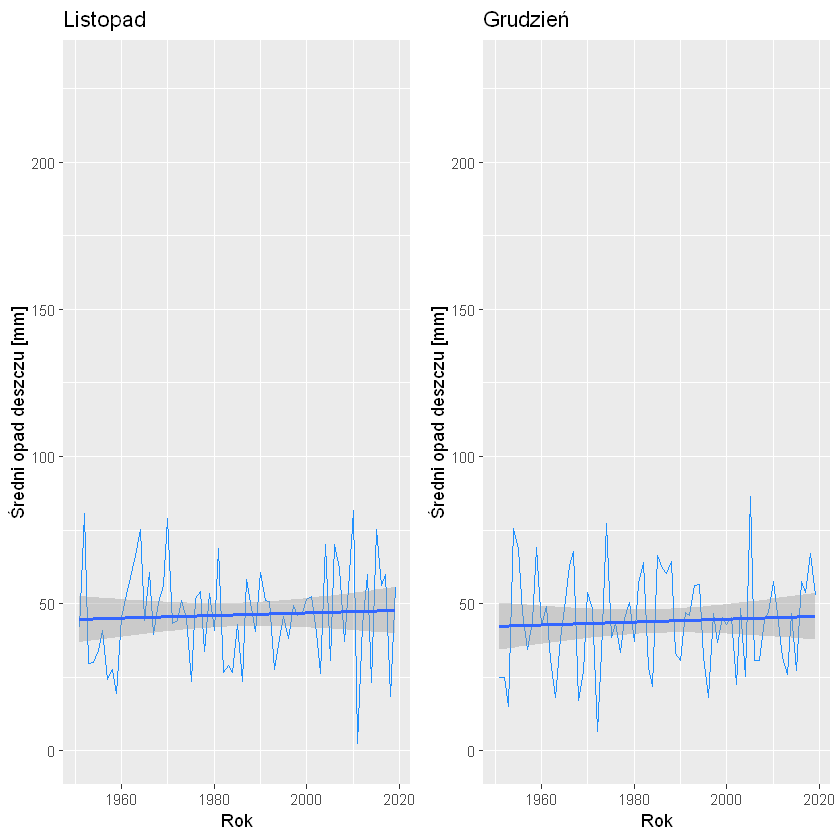

In [18]:
plot_stats("rain", "dodgerblue", "Średni opad deszczu [mm]", c(0, 230))

## Liczba dni z pokrywą śnieżną

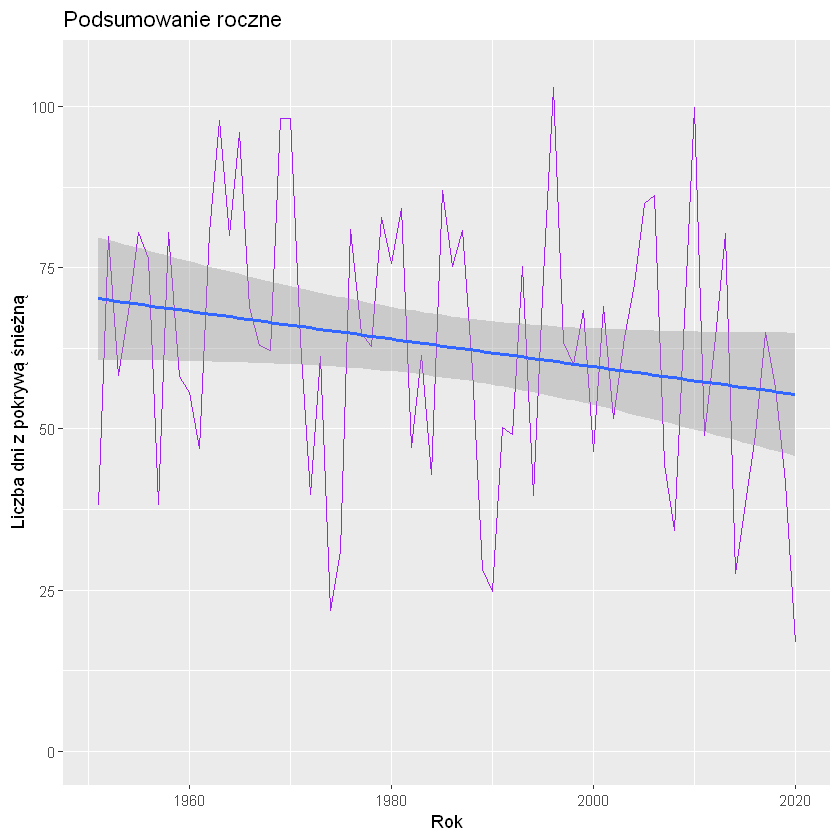

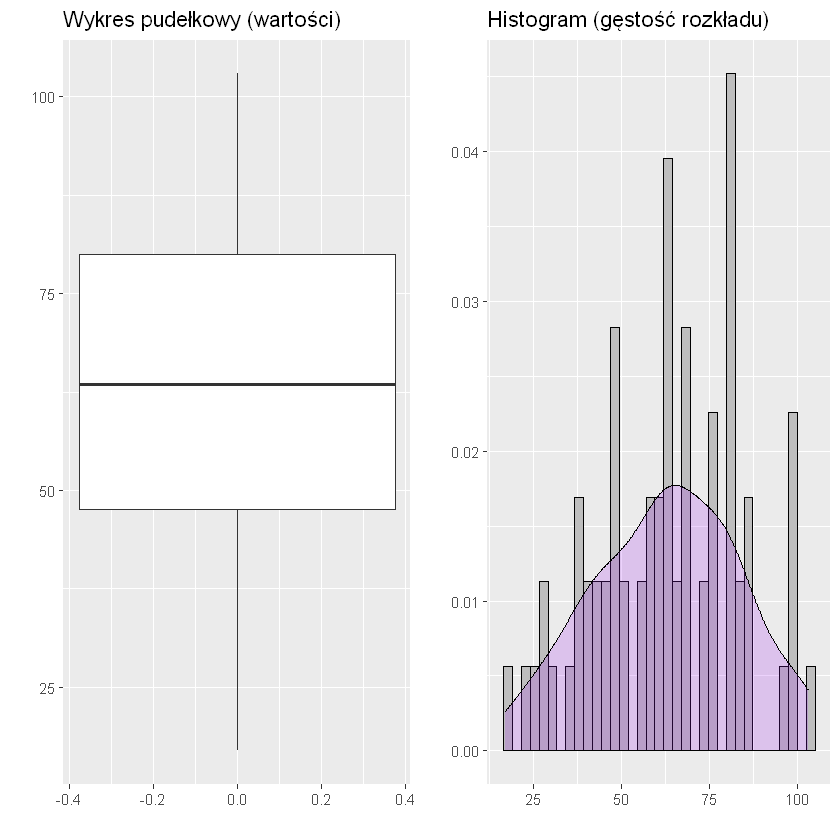

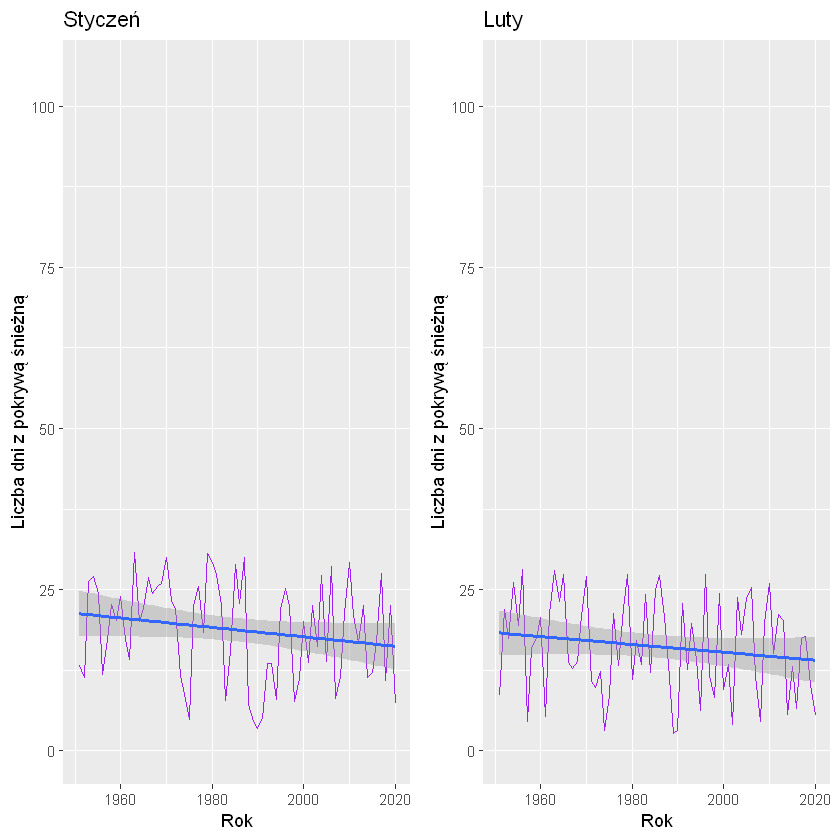

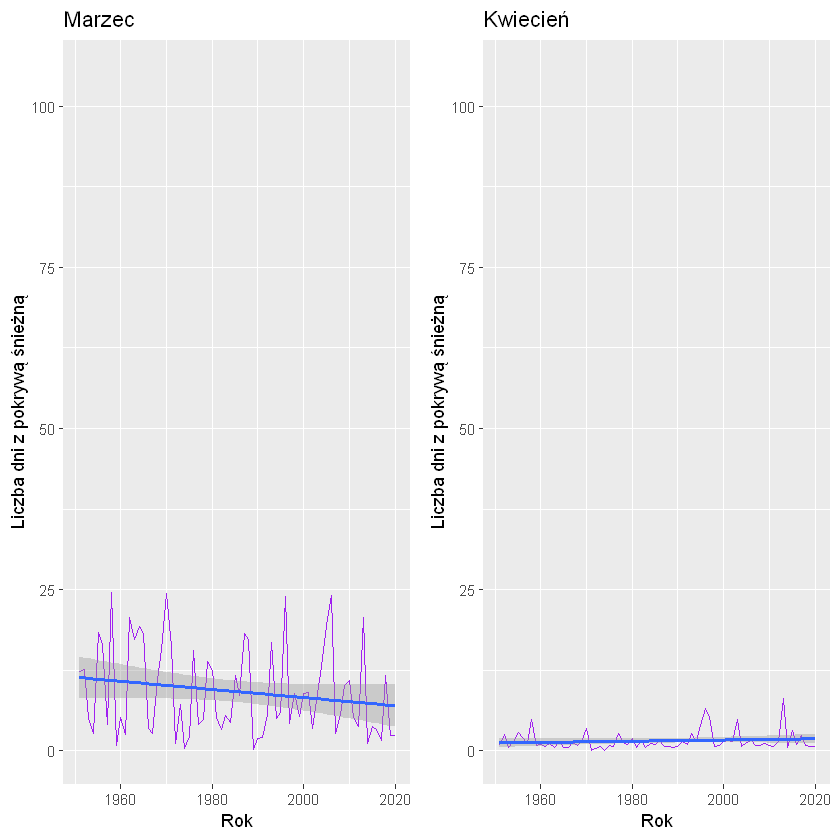

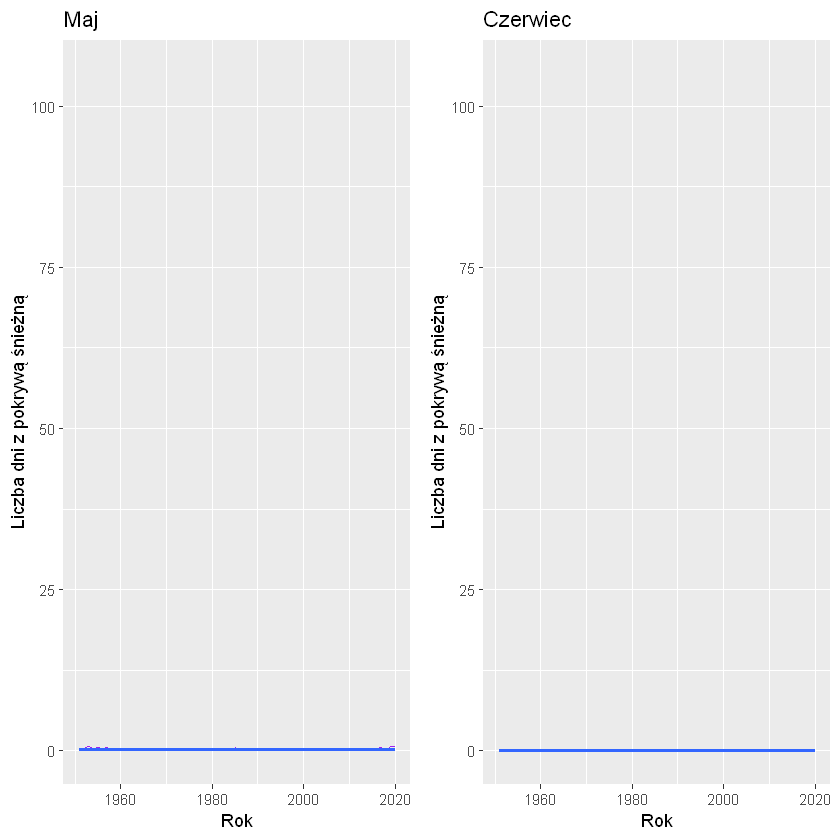

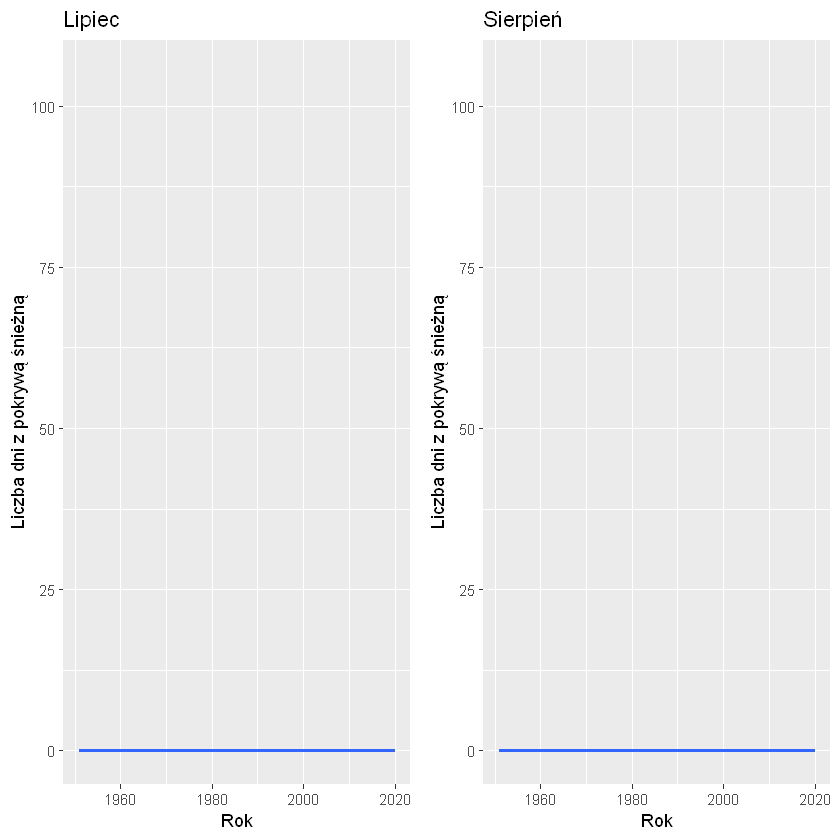

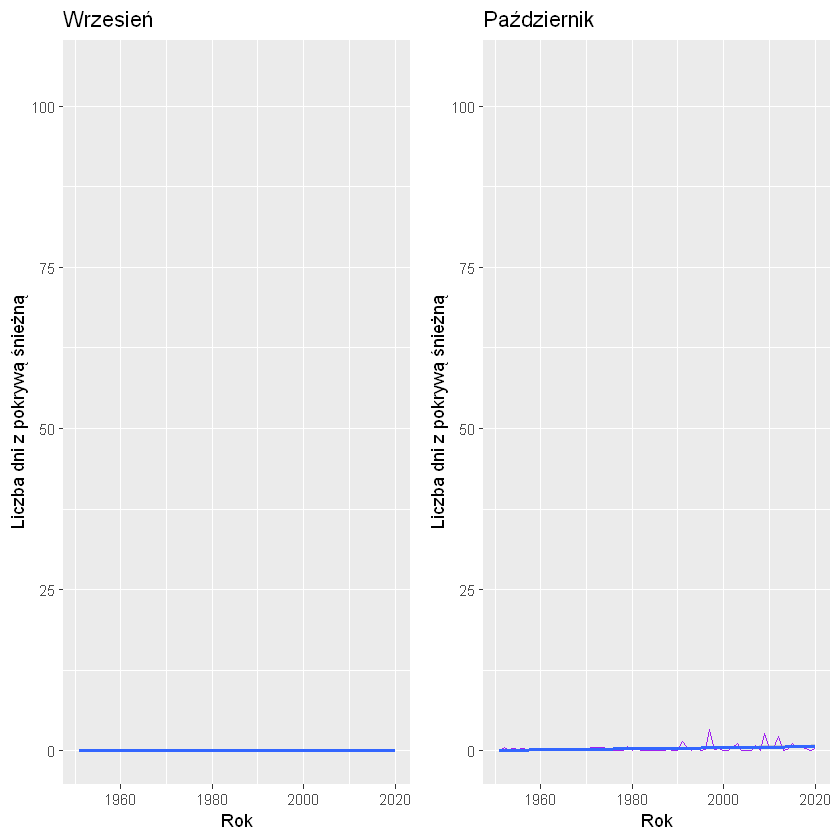

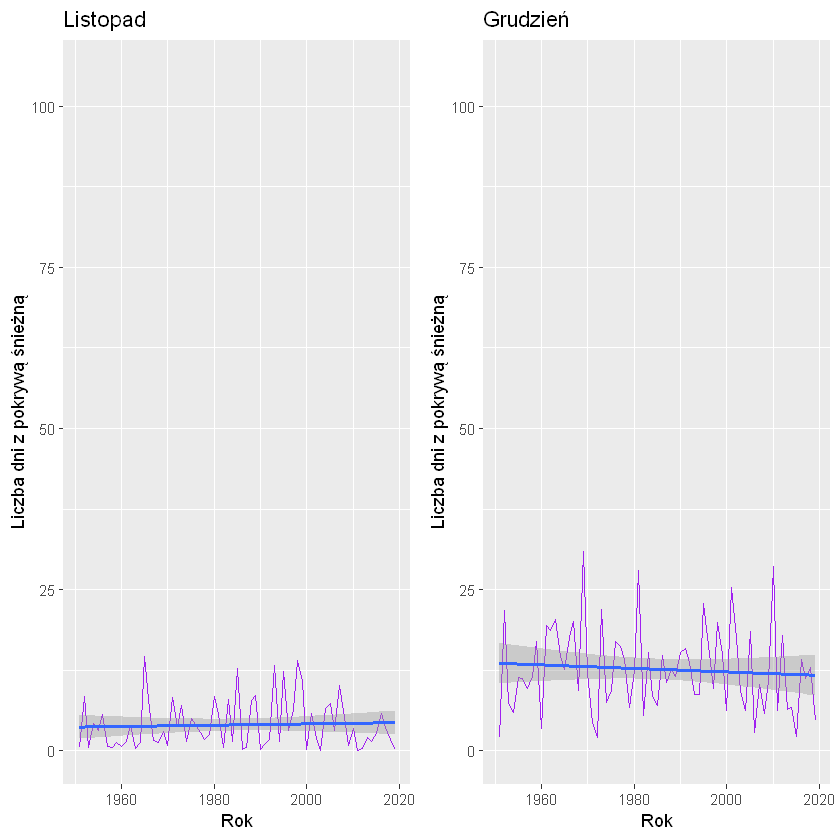

In [19]:
plot_stats("ice_sheet_days", "purple", "Liczba dni z pokrywą śnieżną", c(0, 105))

## Średnia temperatura maksymalna

Pozostałe dane będę prezentował tylko w postaci podsumowań rocznych ze względu na dużą liczbę generowanych wykresów dla każdej kolumny danych.

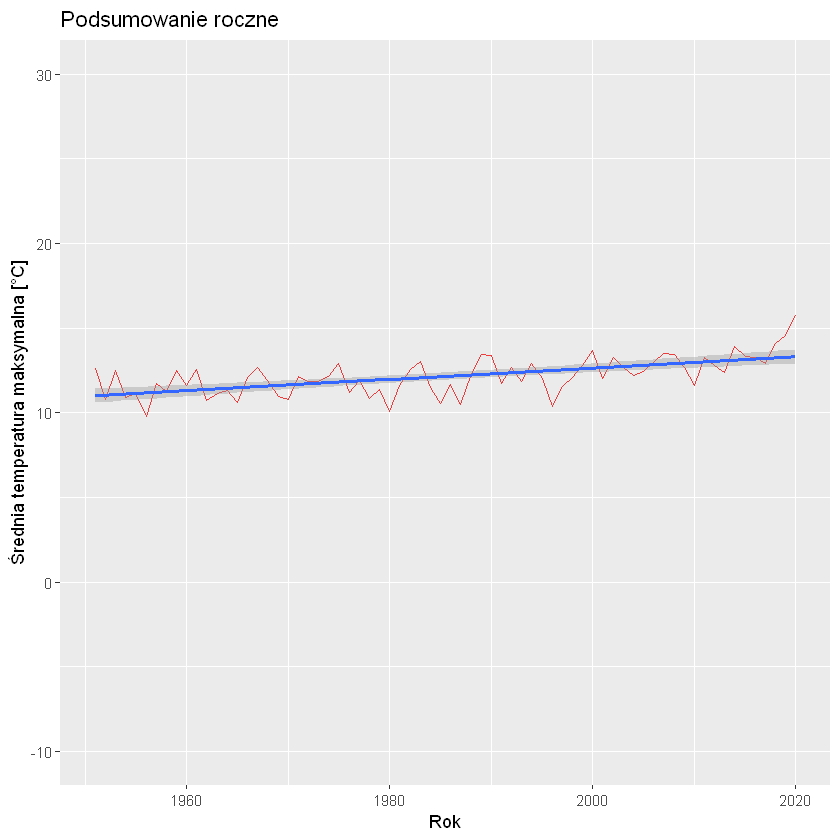

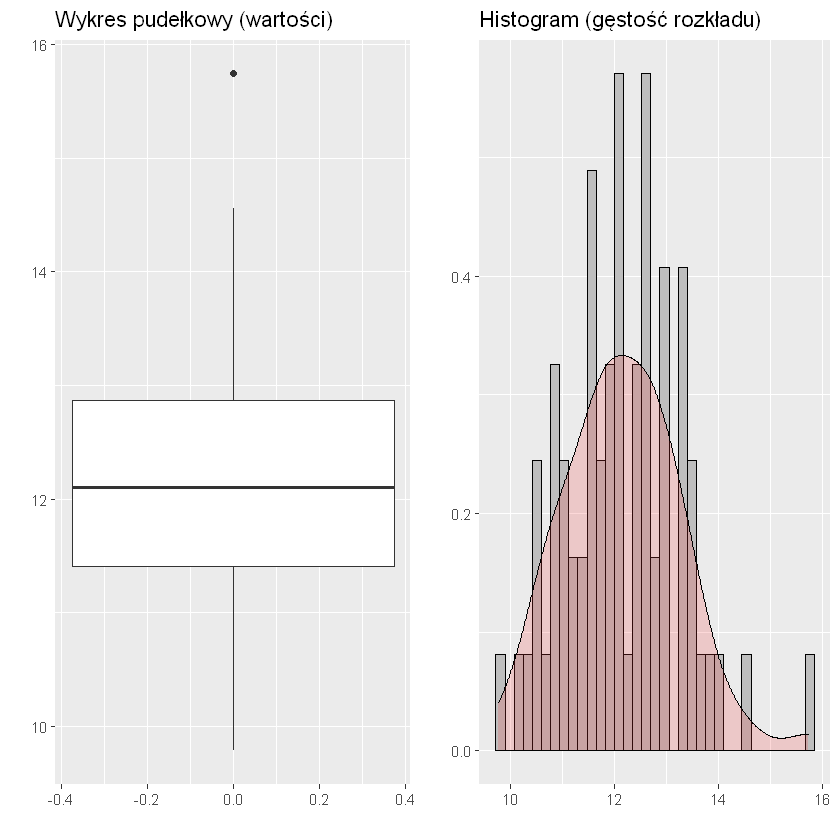

In [20]:
plot_yearly("avg_max_temp", "brown2", "Średnia temperatura maksymalna [°C]", c(-10, 30))

## Absulotna temperatura maksymalna

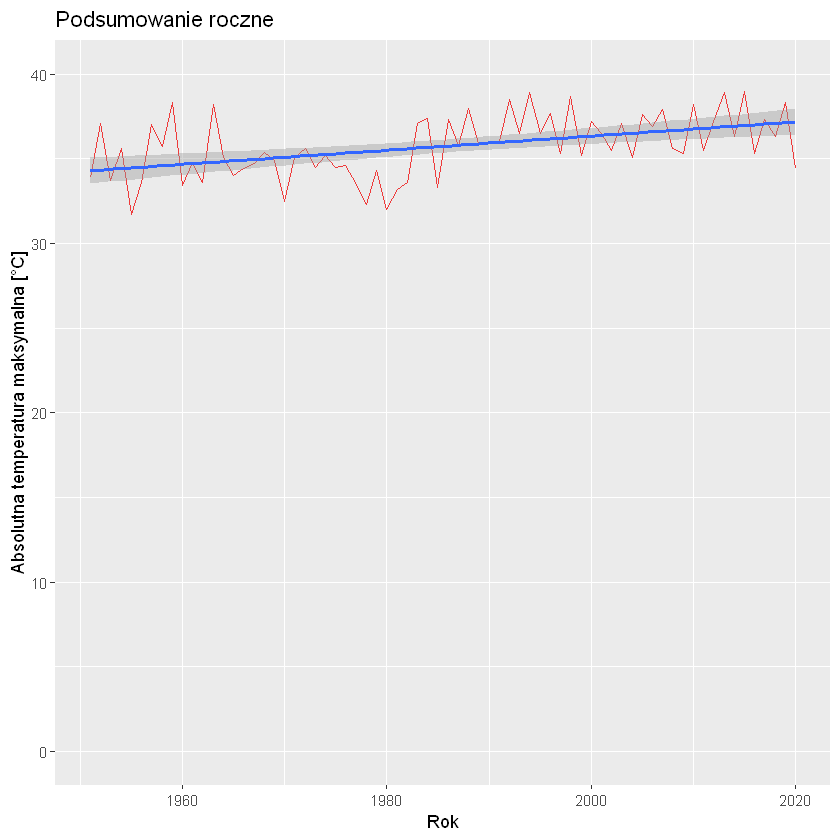

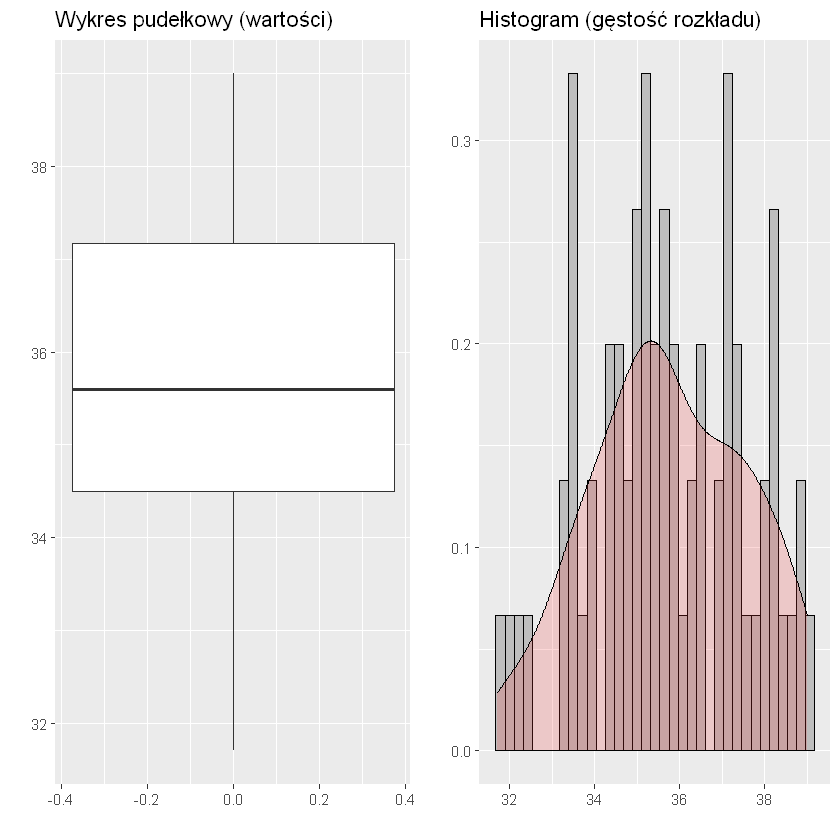

In [21]:
plot_yearly("abs_max_temp", "brown2", "Absolutna temperatura maksymalna [°C]", c(0, 40))

## Średnia temperatura minimalna

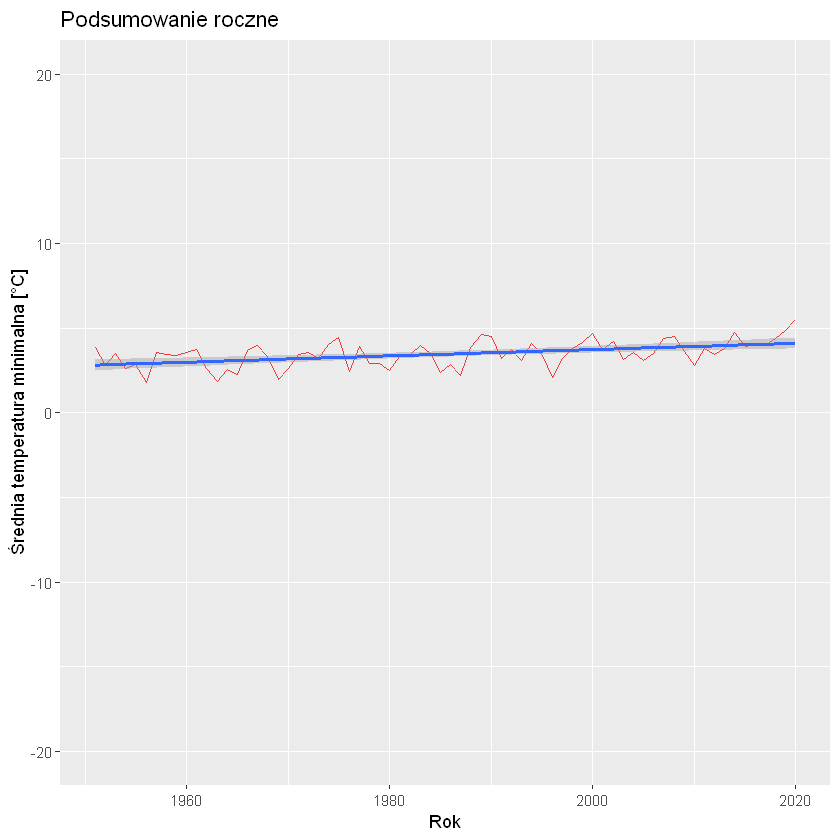

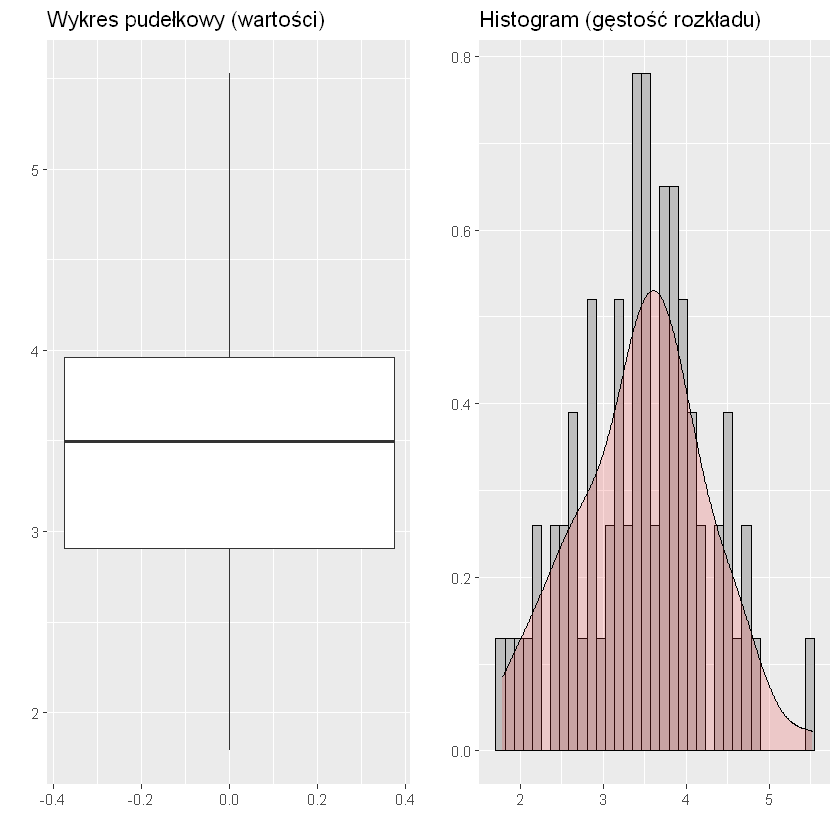

In [22]:
plot_yearly("avg_min_temp", "brown2", "Średnia temperatura minimalna [°C]", c(-20, 20))

## Absolutna temperatura minimalna

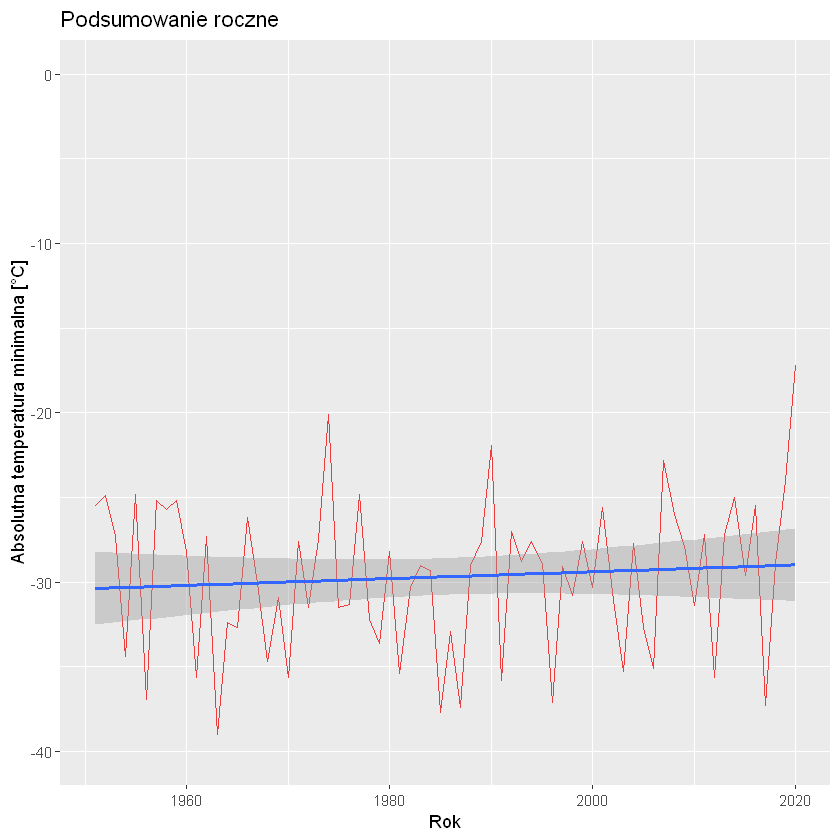

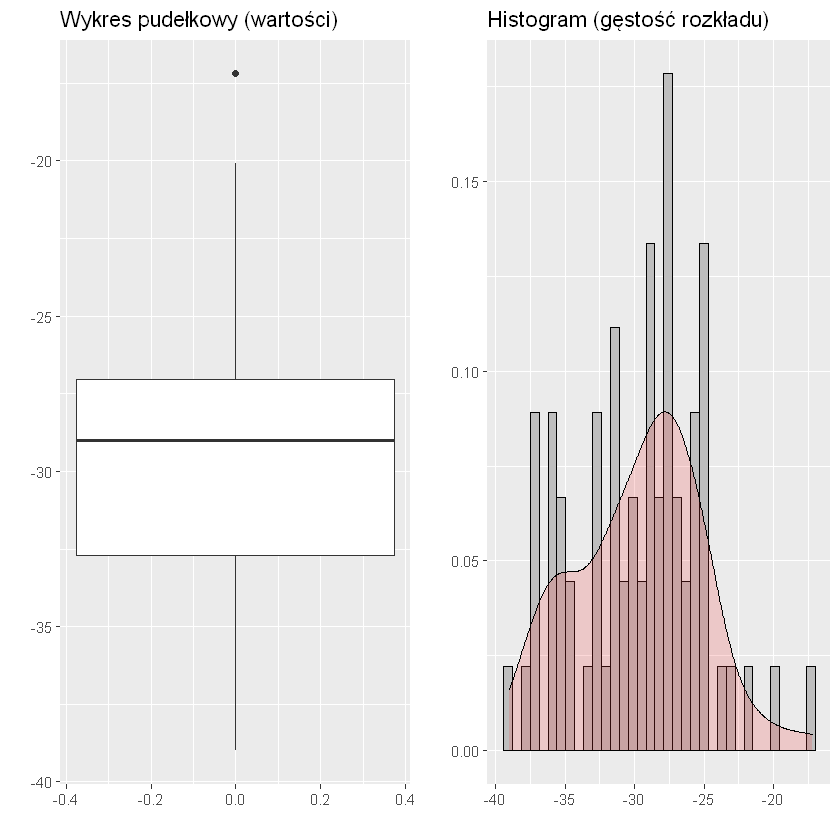

In [23]:
plot_yearly("abs_min_temp", "brown2", "Absolutna temperatura minimalna [°C]", c(-40, 0))

## Maksymalna dobowa suma opadów

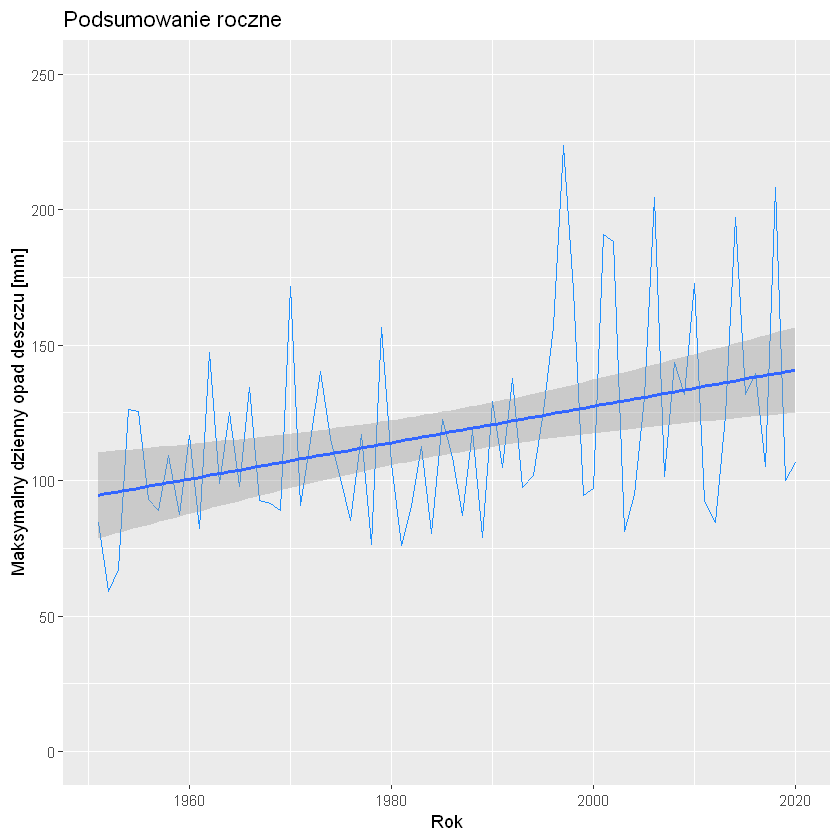

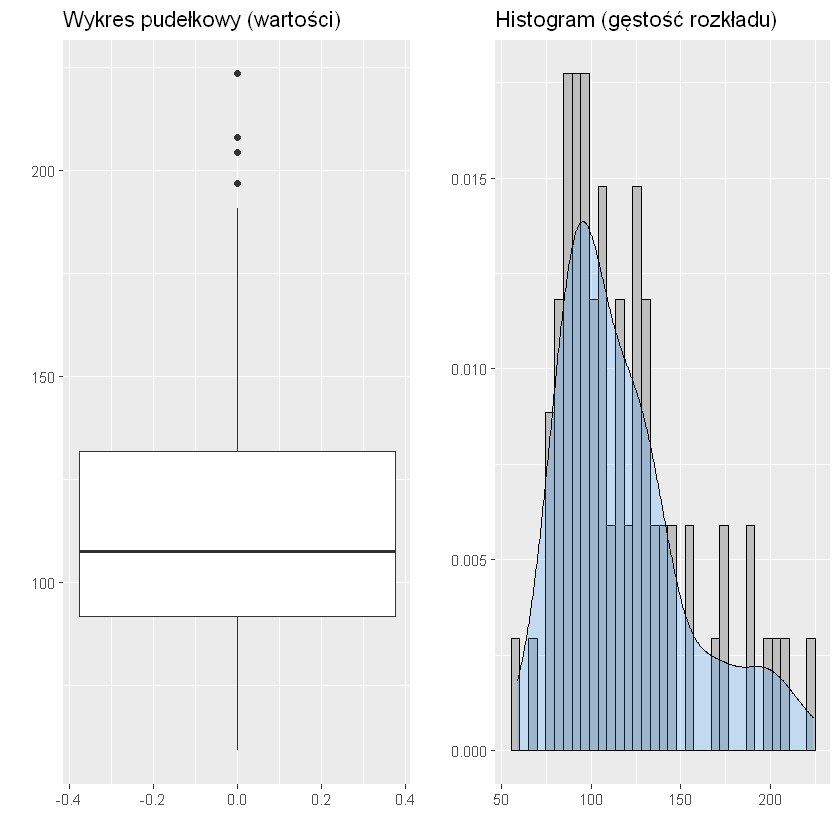

In [24]:
plot_yearly("max_daily_rain", "dodgerblue", "Maksymalny dzienny opad deszczu [mm]", c(0, 250))

## Maksymalna wysokość pokrywy śnieżnej

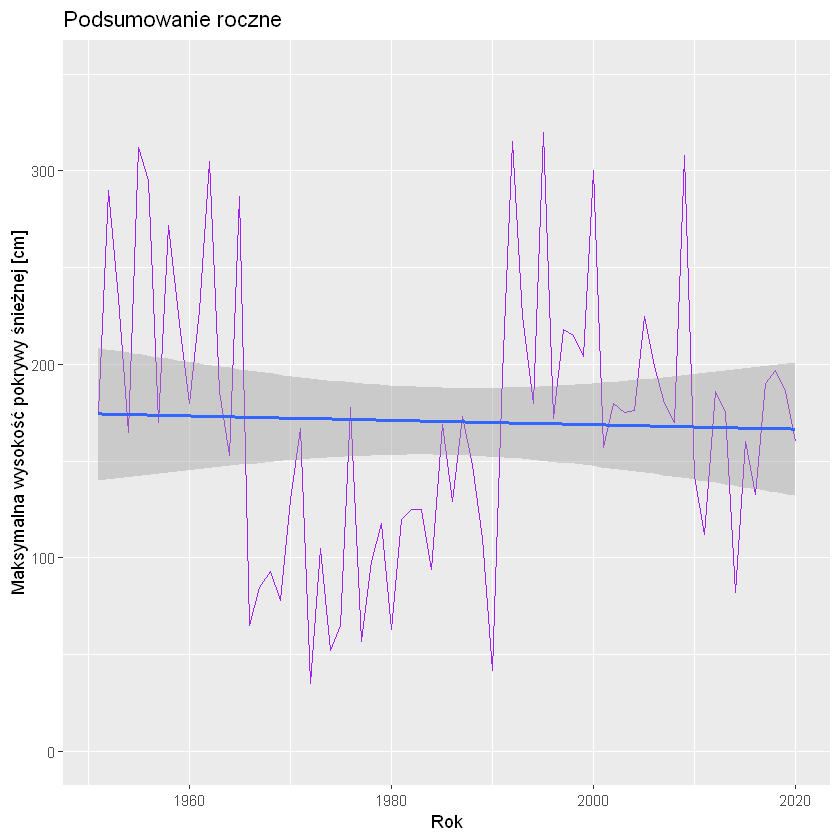

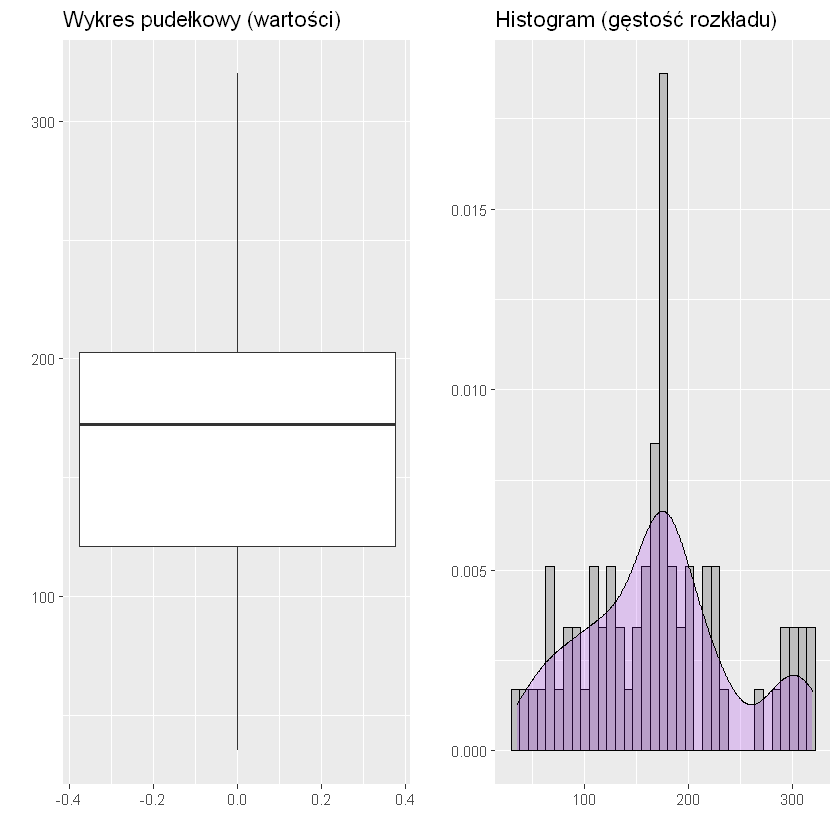

In [25]:
plot_yearly("max_snow", "purple", "Maksymalna wysokość pokrywy śnieżnej [cm]", c(0, 350))

## Liczba deszczowych dni

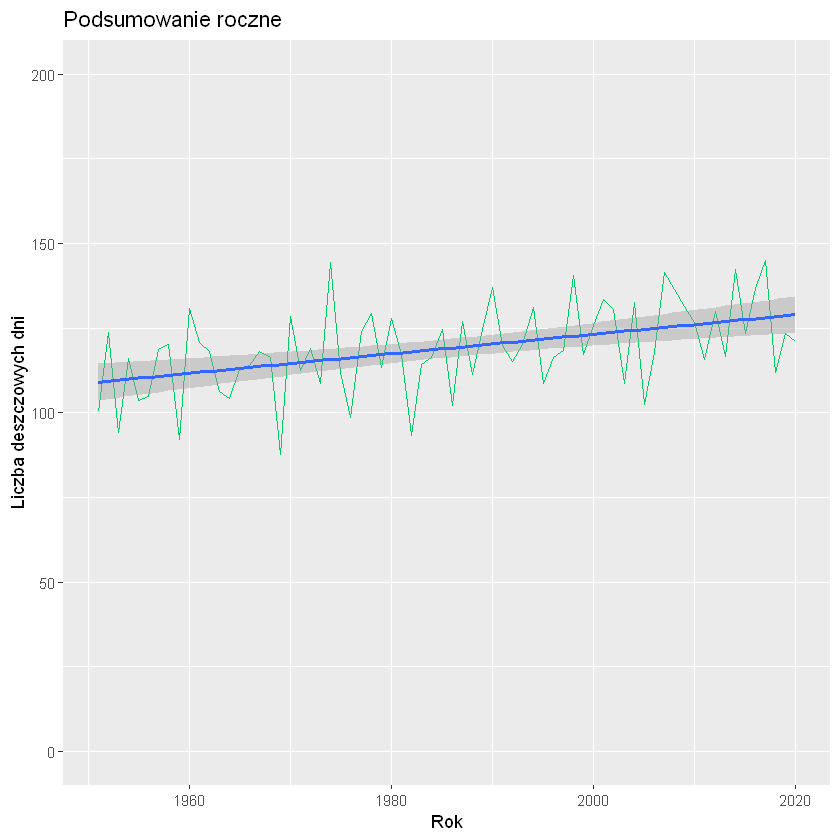

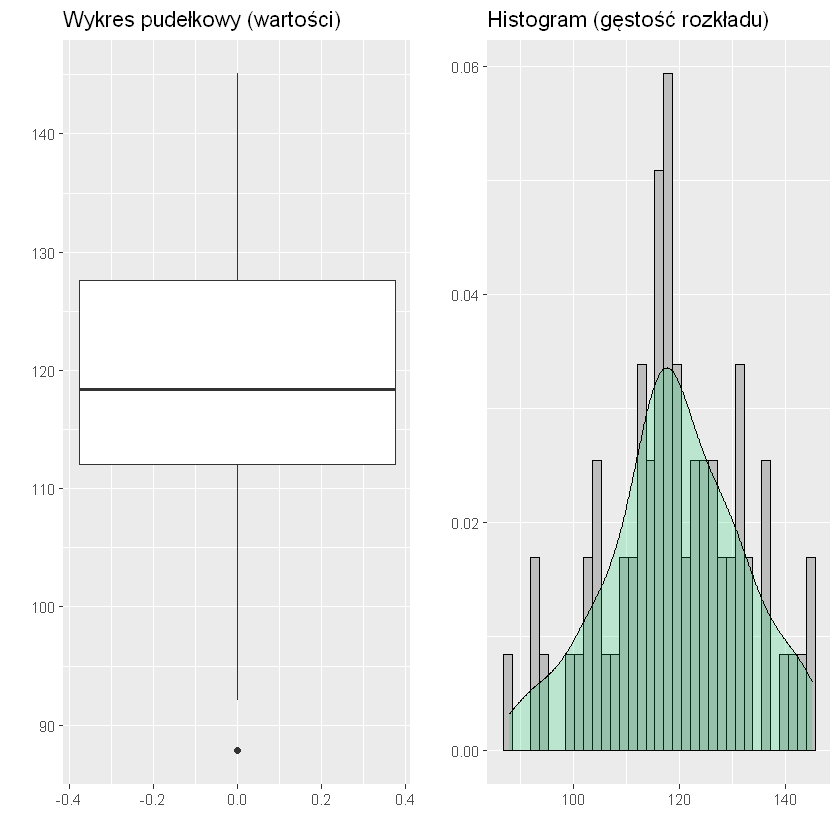

In [26]:
plot_yearly("rainy_days", "springgreen3", "Liczba deszczowych dni", c(0, 200))

## Liczba śnieżnych dni

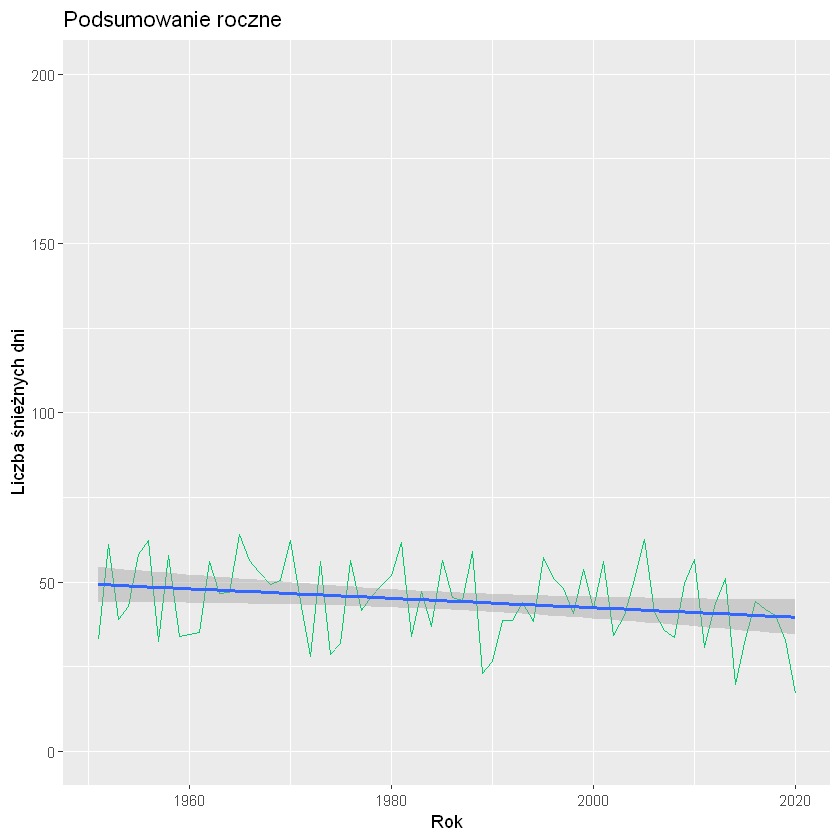

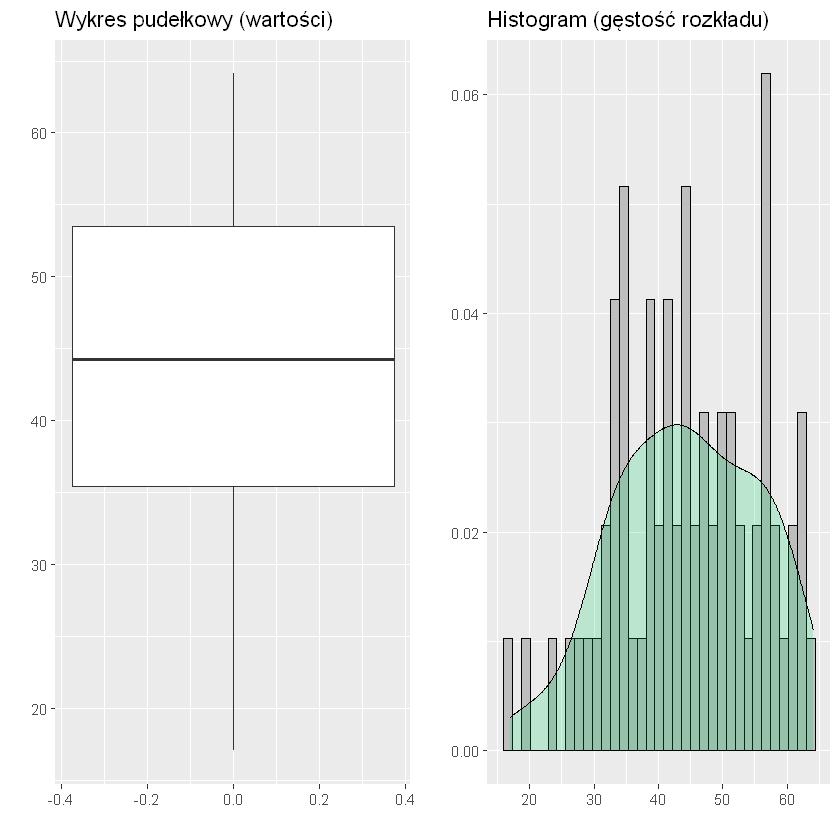

In [27]:
plot_yearly("snowy_days", "springgreen3", "Liczba śnieżnych dni", c(0, 200))

# Analiza danych

## Korelacja zmiennych

Mając pewien pogląd o charakterze poszczególnych zmiennych w moich danych, przystępuję teraz do analizy zależności pomiędzy różnymi zmiennymi. Zbadam ich zależność za pomocą macierzy kowariancji oraz wykresów, a w kolejnym punkcie również za pomocą regresji liniowej.

### Macierze kowiariancji

Podstawowym narzędziem w analizie zależności jest macierz kowariancji. Przedstawiam dwie macierze - jedna z nich obrazuje współczynnik korelacji graficznie (rozmiar oraz kolor kropki), druga natomiast podaje dane liczbowe. 

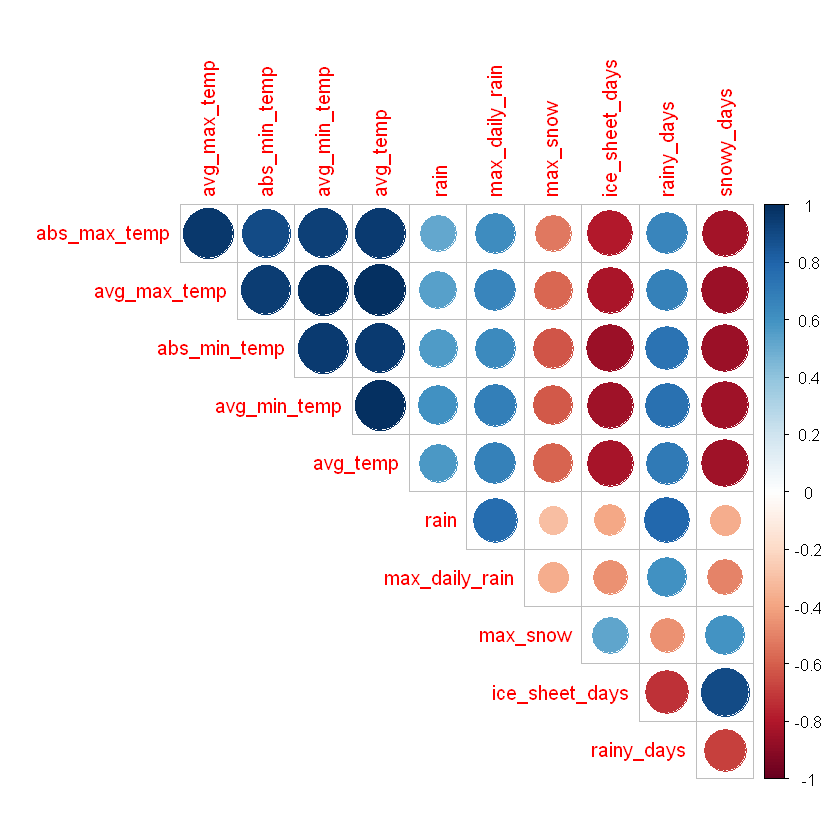

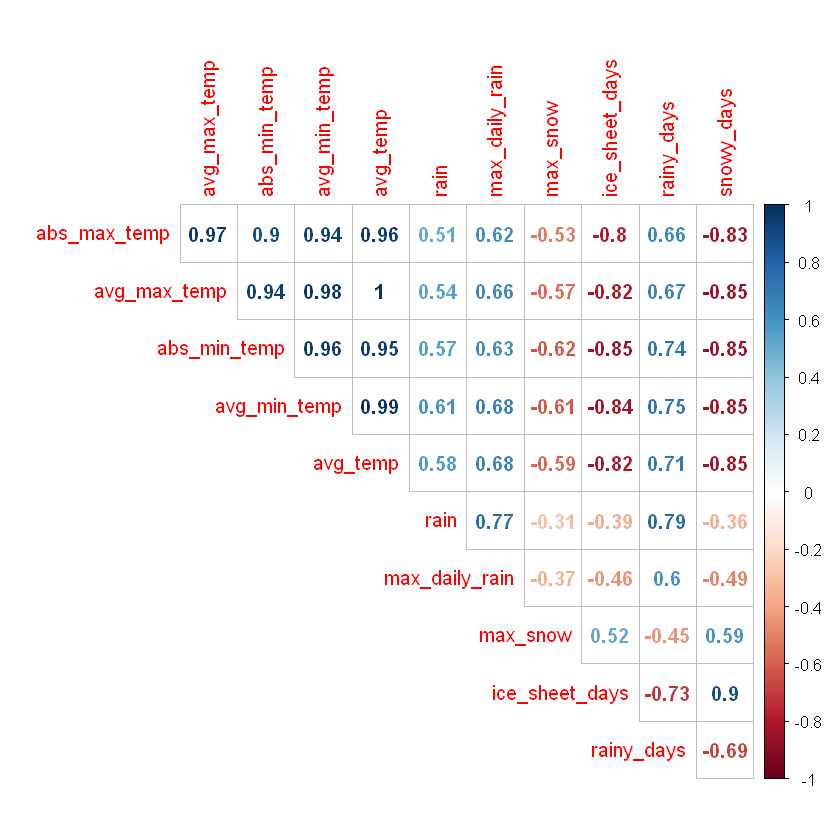

In [28]:
corrplot(cor(data[3:13]), method = 'circle', type = 'upper', diag = FALSE)
corrplot(cor(data[3:13]), method = 'number', type = 'upper', diag = FALSE)

Szczególnie wysoką wartość współczynnika korelacji, momentami bliską idealnej zależności, możemy zaobserwować pomiędzy zmiennymi dotyczącymi temperatury (średnia temperatura, absolutna temperatura maksymalna, średnia temperatura maksymalna, absolutna temperatura minimalna, średnia temperatura minimalna). Nie jest to zaskakujące, gdyż zmienne te zależą od jednego wspólnego zjawiska, a więc temperatury powietrza - przykładowo gdy rośnie średnia temperatura minimalna, dość naturalne wydaje się, iż wzrośnie na przykład średnia temperatura. Przedstawiam poniżej wycinek macierzy korelacji ze zmiennymi dotyczącymi temperatury, aby można było dokładniej je przeanalizować.

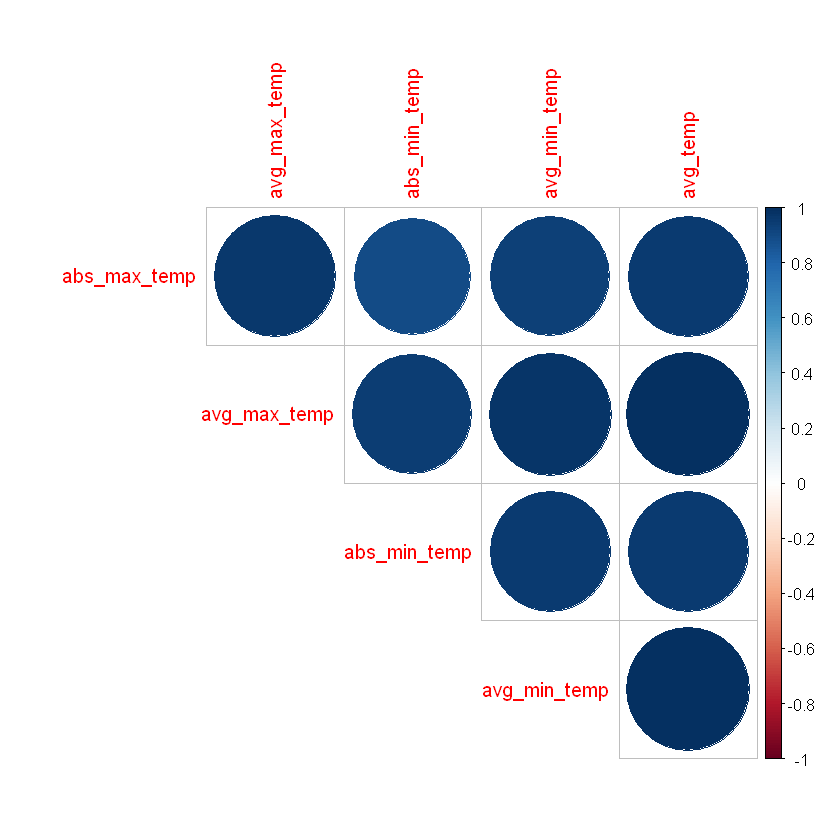

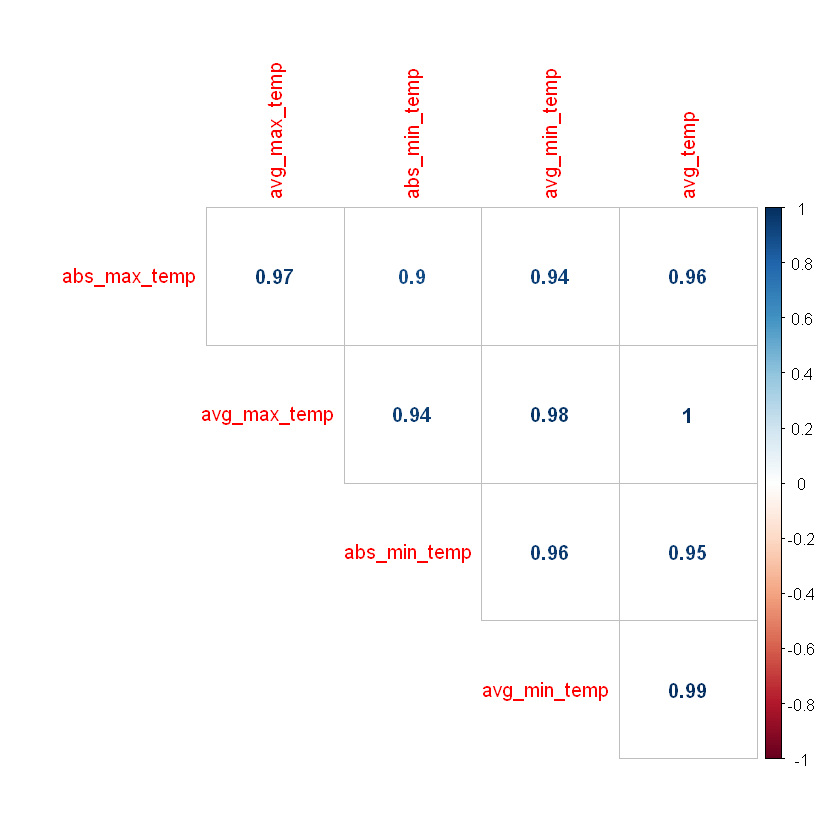

In [29]:
corrplot(cor(data[3:7]), method = 'circle', type = 'upper', diag = FALSE)
corrplot(cor(data[3:7]), method = 'number', type = 'upper', diag = FALSE)

Ponieważ wszystkie zmienne dotyczące temperatury były od siebie bardzo zależne, zamieszczam również wycinek macierzy korelacji, w której uwzględniam tylko jedną z tych zmiennych - średnią temperaturę. Bardzo wysoką zależność możemy zauważyć pomiędzy liczbą dni z opadem śniegu oraz liczbą dni z pokrywą śnieżną. Jednak znacznie ciekawsze zależności, tym razem z wysokim współczynnikiem korelacji odwrotnej, to średnia temperatura wraz z liczbą dni z pokrywą śnieżną oraz liczbą dni z opadem śniegu. Dość wysoka zależność pojawia się również pomiędzy średnią temperaturą oraz liczbą dni deszczowych, sumarycznym opadem oraz liczbą dni deszczowych, sumarycznym opadem i maksymalnym dziennym opadem, a także liczbą dni deszczowych oraz liczbą dni z pokrywą śnieżną.

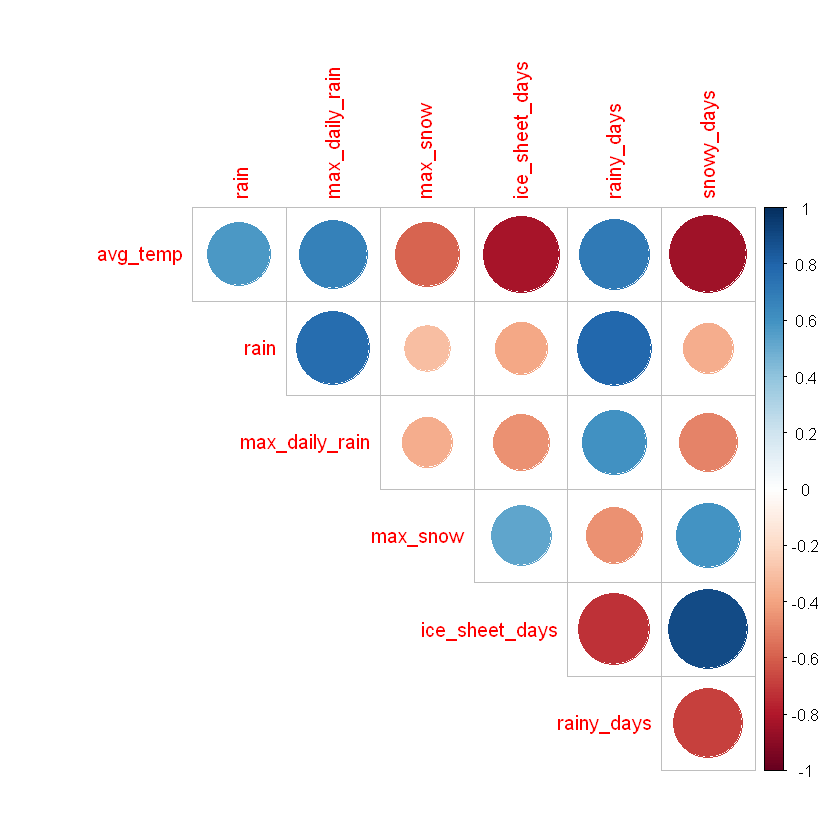

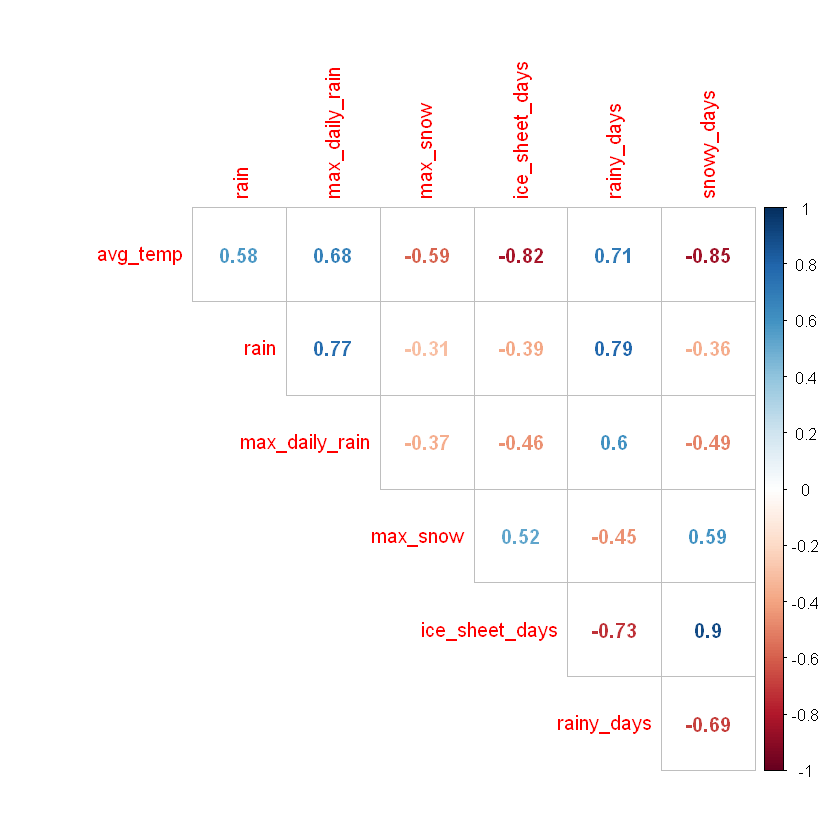

In [30]:
corrplot(cor(data[7:13]), method = 'circle', type = 'upper', diag = FALSE)
corrplot(cor(data[7:13]), method = 'number', type = 'upper', diag = FALSE)

### Wykresy obrazujące korelację poszczególnych zmiennych

W analizie zależności danych wspomagam się również wykresami jednej zmiennej od drugiej, które są dobrym narzędziem w graficznej ocenie zależności. Prezentuję macierz korelacji z poglądowymi wykresami zależności danych, a poniżej zamieszczam szczegółowe zestawienia dla wybranych pomiarów.

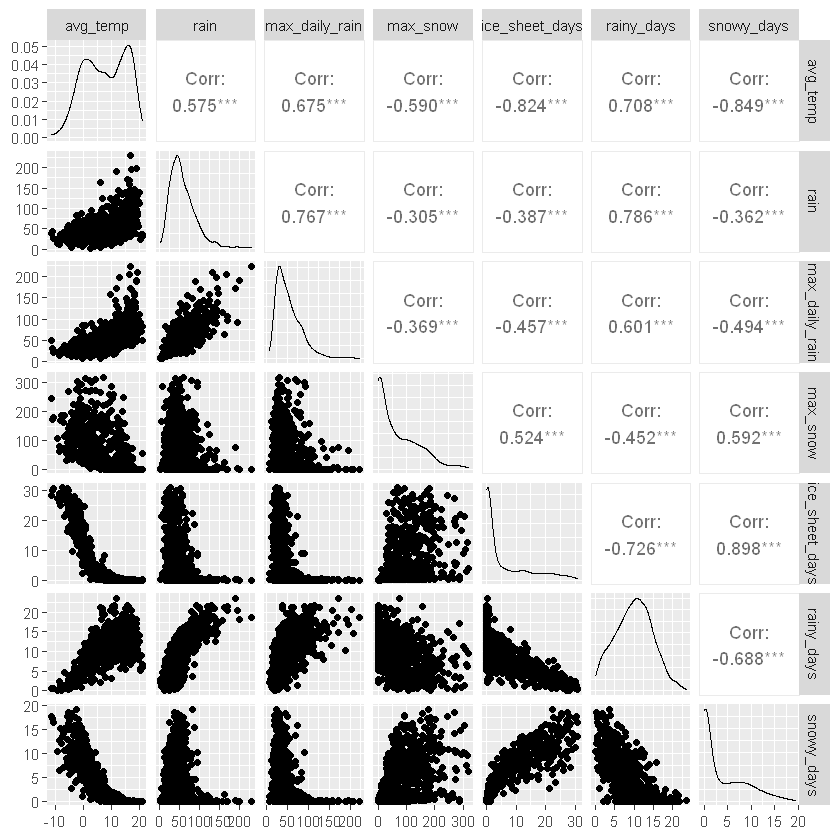

In [31]:
ggpairs(data, columns = 7:13) 

Wykres średniej temperatury maksymalnej od średniej temperatury jest potwierdzeniem praktycznie idealnej zależności liniowej pomiędzy tymi zmiennymi.

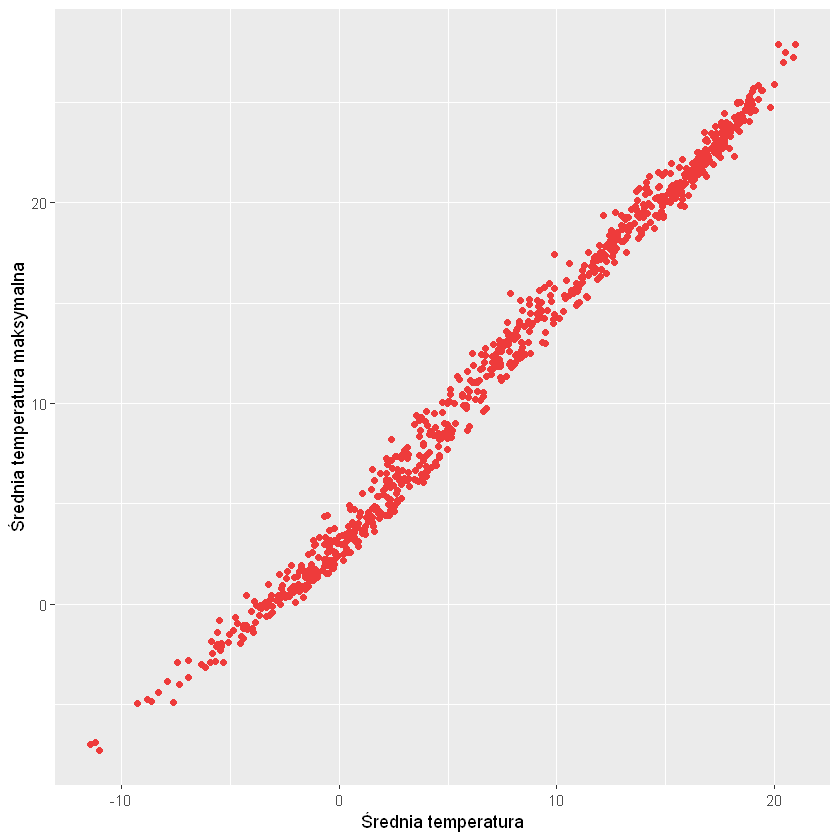

In [32]:
ggplot(data, aes(avg_temp, avg_max_temp)) + labs(y = 'Średnia temperatura maksymalna', x = 'Średnia temperatura') + geom_point(col = 'brown2')

Na wykresie liczby dni z pokrywą śnieżną od średniej temperatury również można dostrzec pewną zależność. Od temperatury około -12 stopni do około 5 stopni widać liniowy spadek liczby dni. Ponadto powyżej pewnej temperatury (około 5 stopni) obserwuje się wyraźny spadek liczby dni i jest ona bliska zeru.

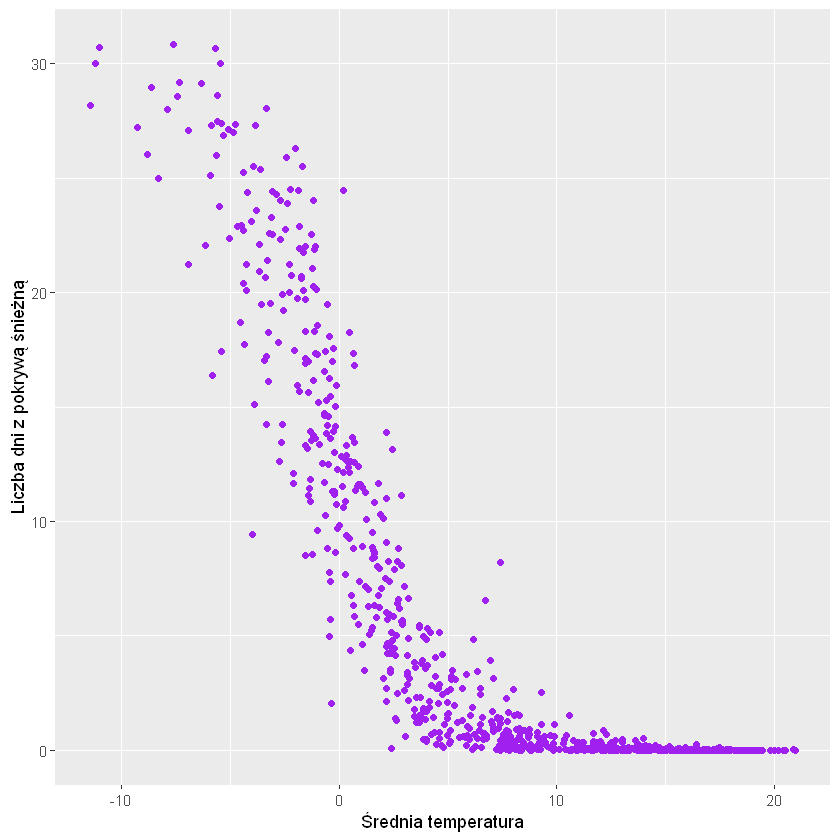

In [33]:
ggplot(data, aes(avg_temp, ice_sheet_days)) + labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Średnia temperatura') + geom_point(col = 'purple')

W przypadku liczby dni z opadem oraz średniej temperatury występuje pewna zależność - w ogólności można powiedzieć, że im wyższa temperatura, tym więcej dni deszczowych (prawdopodobnie dlatego, iż w mroźne dni pada śnieg). Jednak rozrzut danych jest dość spory, zatem trudno mówić o idealnej korelacji tych zmiennych.

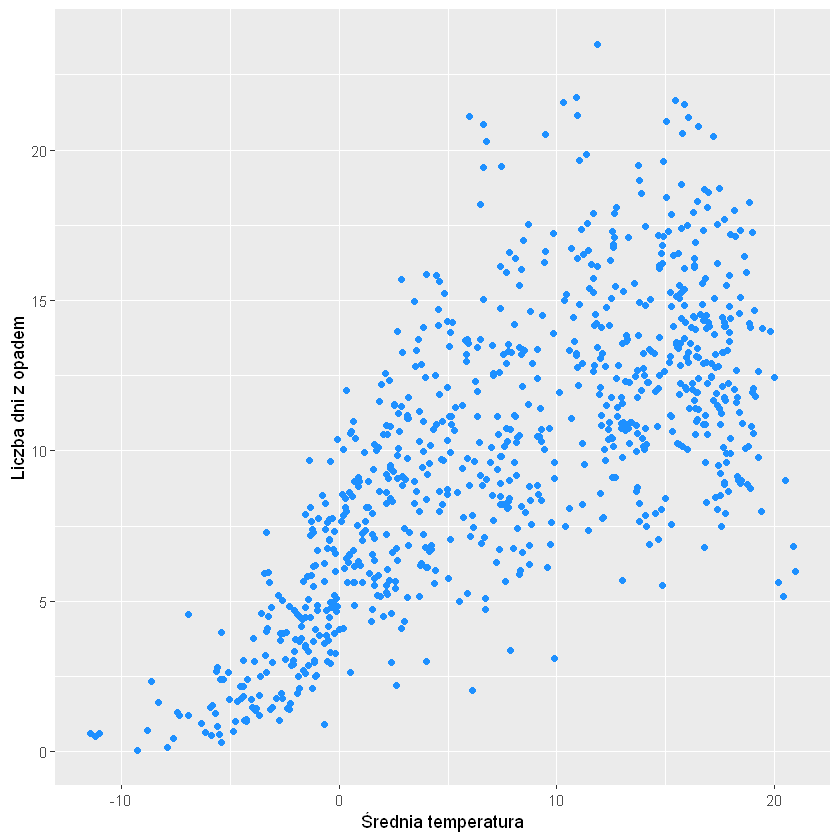

In [34]:
ggplot(data, aes(avg_temp, rainy_days)) + labs(y = 'Liczba dni z opadem', x = 'Średnia temperatura') + geom_point(col = 'dodgerblue')

Pomiary liczby dni z pokrywą śnieżną oraz liczby dni z opadem uzyskały wysoki współczynnik ujemnej korelacji, jednak na wykresie zależność zmiennych nie jest oczywista.

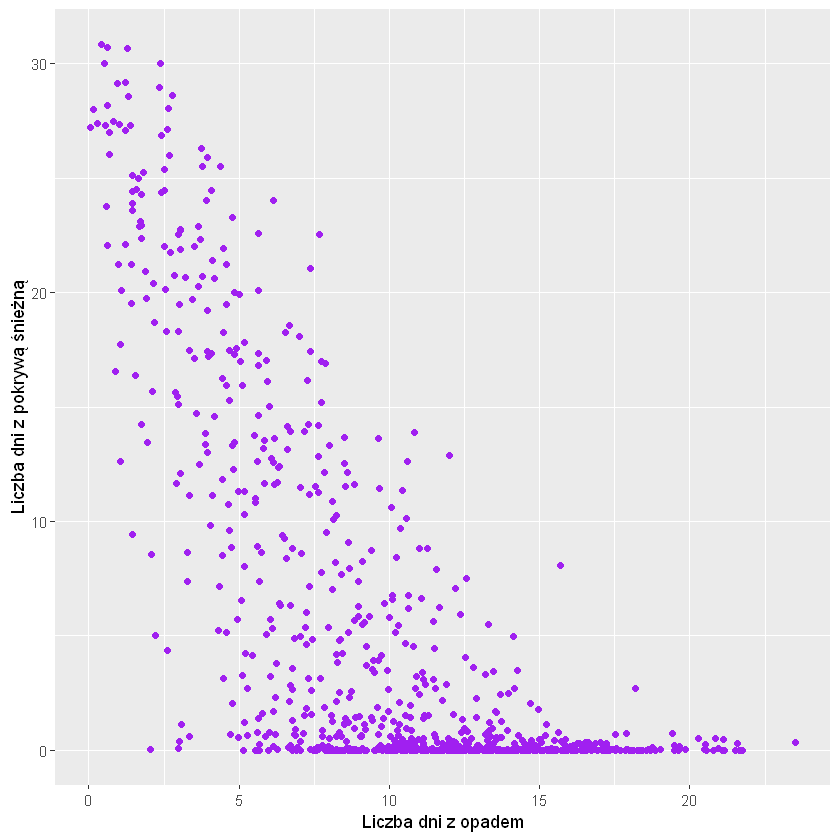

In [35]:
ggplot(data, aes(rainy_days, ice_sheet_days)) + labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Liczba dni z opadem') + geom_point(col = 'purple')

Na wykresie zmiennej liczby dni z opadem od sumarycznego opadu można zauważyć pewną zależność, pomimo dużego rozrzutu wyników.

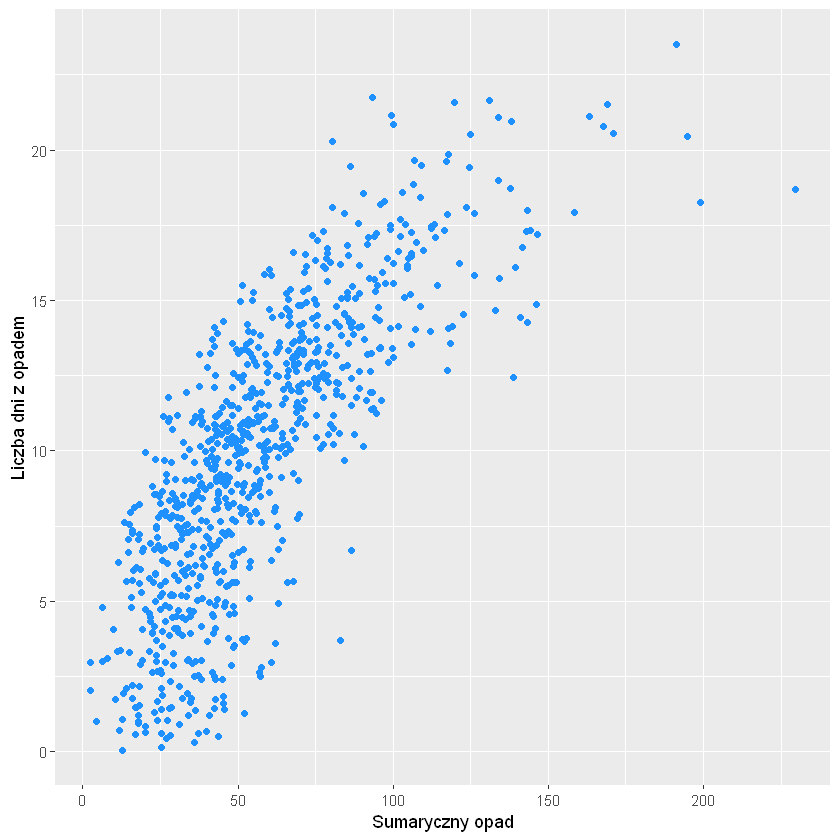

In [36]:
ggplot(data, aes(rain, rainy_days)) + labs(y = 'Liczba dni z opadem', x = 'Sumaryczny opad') + geom_point(col = 'dodgerblue')

W przypadku liczby dni z pokrywą śnieżną oraz liczby dni z opadem śniegu rozrzut wartości również jest znaczny, jednak widać dużą zależność w pobliżu wartości 0 - jeśli nie pada śnieg, pokrywa śnieżna nie utrzymuje się.

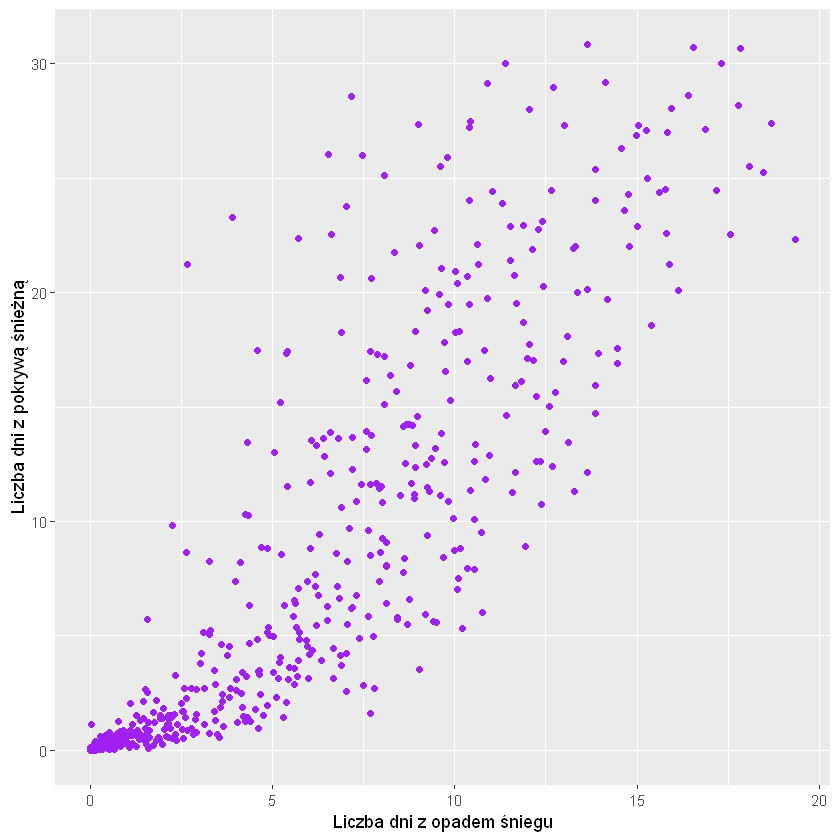

In [37]:
ggplot(data, aes(snowy_days, ice_sheet_days)) + labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Liczba dni z opadem śniegu') + geom_point(col = 'purple')

## Test rozkładu normalnego

### Dane z podziałem na miesiące

Dane zawierające pomiary z dokładnością do jednego miesiąca mogą wykazywać wahania sezonowe i duży rozrzut poszczególnych wartości w zależności od pory roku, dlatego ich podobieństwo do rozkładu normalnego może być niewielkie.

In [38]:
for (i in colnames(data[3:13])) {
    space = '\t'
    
    if (nchar(i) < 8) 
        space = '\t\t'
    
    cat(i, space, 'W:', shapiro.test(data[[i]])$statistic, ' p-value:', shapiro.test(data[[i]])$p, '\n')
}

abs_max_temp 	 W: 0.9506163  p-value: 3.872511e-16 
avg_max_temp 	 W: 0.9463441  p-value: 7.154537e-17 
abs_min_temp 	 W: 0.9352439  p-value: 1.337978e-18 
avg_min_temp 	 W: 0.9621998  p-value: 6.75728e-14 
avg_temp 	 W: 0.9551095  p-value: 2.565812e-15 
rain 		 W: 0.9234618  p-value: 3.25978e-20 
max_daily_rain 	 W: 0.8778025  p-value: 4.09563e-25 
max_snow 	 W: 0.8518614  p-value: 2.694337e-27 
ice_sheet_days 	 W: 0.7027469  p-value: 5.381836e-36 
rainy_days 	 W: 0.9909168  p-value: 4.897063e-05 
snowy_days 	 W: 0.789629  p-value: 1.612022e-31 


p-values zwrócone przez test Shapiro-Wilka normalności rozkładu są bardzo małe, dane nie wspierają zatem hipotezy, iż zmienne mają rozkład normalny. Możemy się o tym dodatkowo przekonać przez wykres QQ (quantile-quantile) obrazujący korelację pomiędzy próbką, a rozkładem normalnym. Dla przykładu wykres zależności zmiennej 'avg_temp' oraz 'rain':

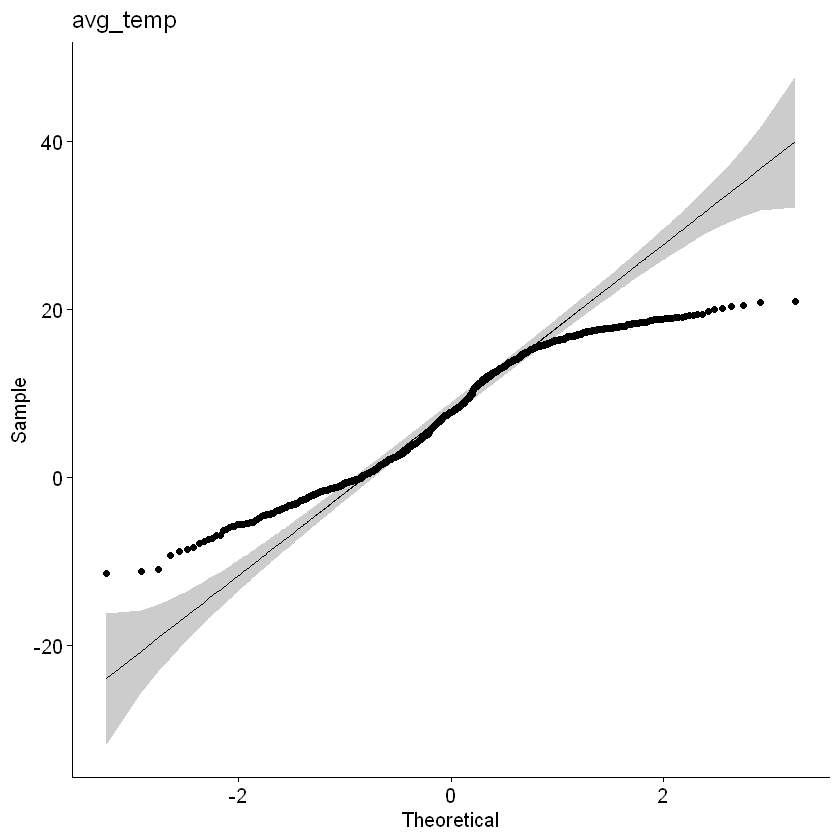

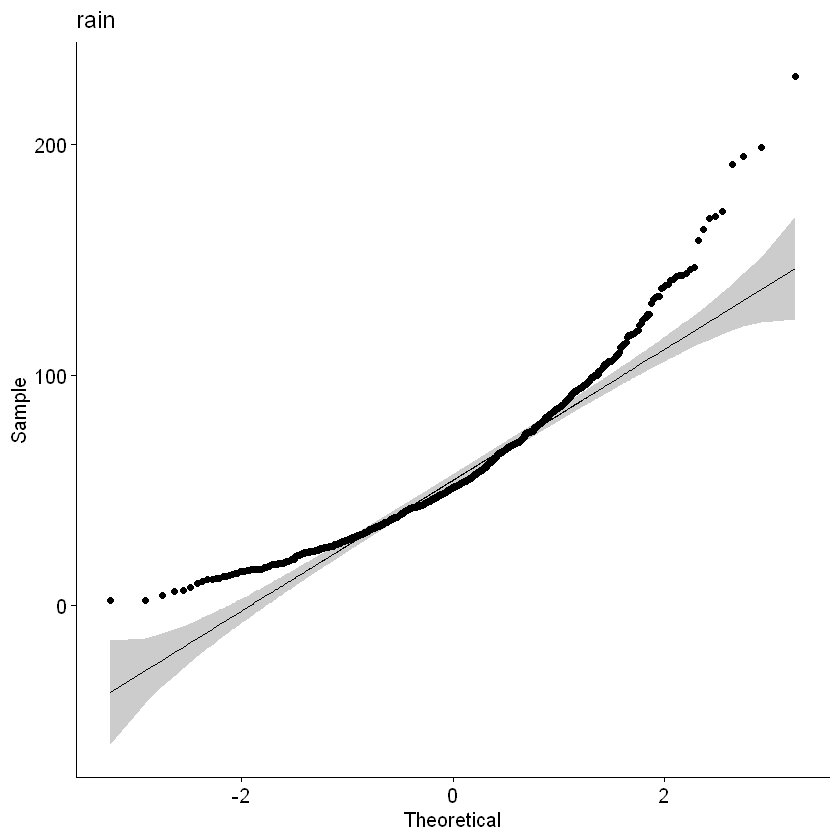

In [39]:
ggqqplot(data$avg_temp, title = 'avg_temp')
ggqqplot(data$rain, title = 'rain')

### Dane z podziałem na lata

Dane zawierające pomiary z dokładnością do jednego roku są uśrednione, dlatego ich rozkłady w dużej mierze są bliskie rozkładowi normalnemu.

In [40]:
for (i in colnames(years[2:12])) {
    space = '\t'
    
    if (nchar(i) < 8) 
        space = '\t\t'
    
    cat(i, space, 'W:', shapiro.test(years[[i]])$statistic, ' p-value:', shapiro.test(years[[i]])$p, '\n')
}

abs_max_temp 	 W: 0.9796342  p-value: 0.31156 
avg_max_temp 	 W: 0.9862973  p-value: 0.6444183 
abs_min_temp 	 W: 0.9782708  p-value: 0.2635816 
avg_min_temp 	 W: 0.9897897  p-value: 0.8437678 
avg_temp 	 W: 0.9855519  p-value: 0.6006767 
rain 		 W: 0.9787042  p-value: 0.2780873 
max_daily_rain 	 W: 0.9095593  p-value: 9.444251e-05 
max_snow 	 W: 0.9613774  p-value: 0.02984026 
ice_sheet_days 	 W: 0.9829389  p-value: 0.4576306 
rainy_days 	 W: 0.9878406  p-value: 0.7356984 
snowy_days 	 W: 0.9776564  p-value: 0.2441622 


Poza zmiennymi 'max_daily_rain' oraz 'max_snow', wskaźnik p-value ma dużą wartość, zatem dane nie wspierają odrzucenia hipotezy o podobieństwie rozkładów do rozkładu normalnego. Potwierdzają to również przykładowe wykresy QQ:

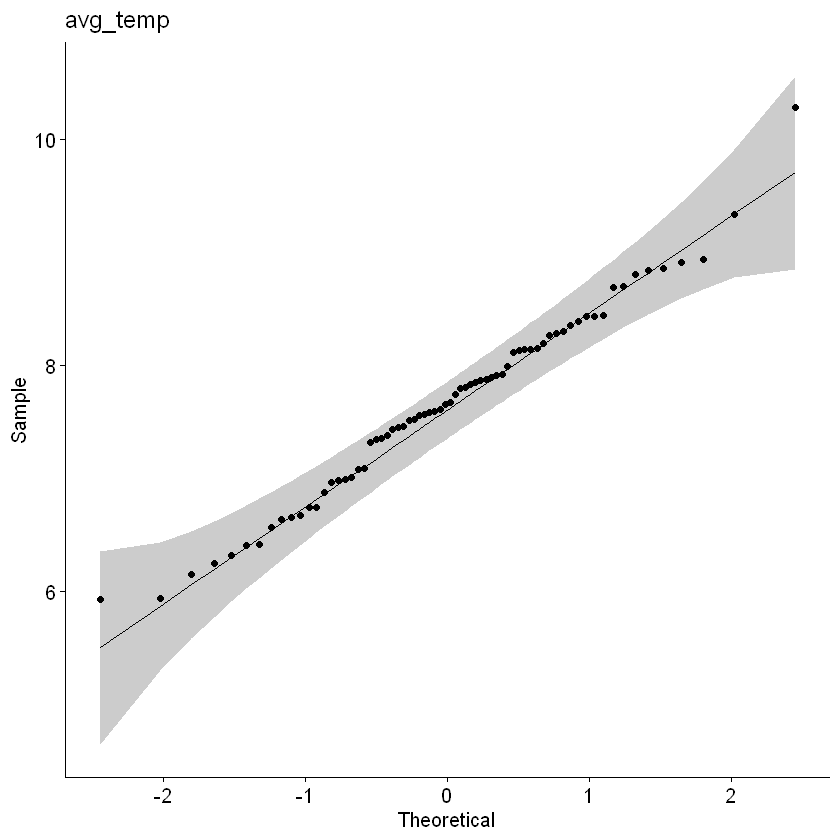

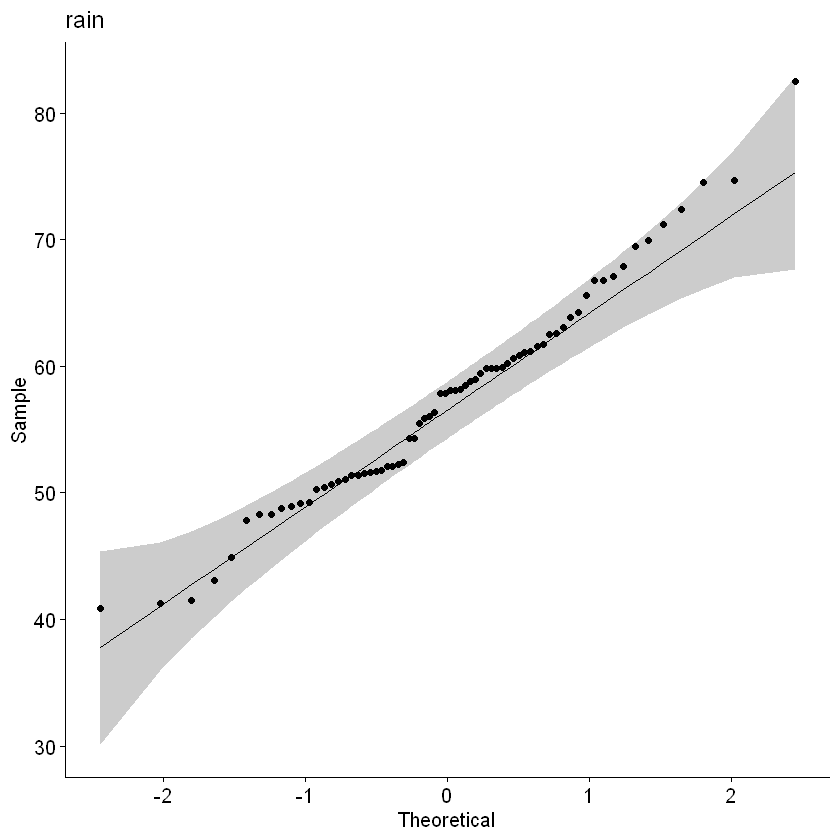

In [41]:
ggqqplot(years$avg_temp, title = 'avg_temp')
ggqqplot(years$rain, title = 'rain')

## Test rozkładów z wykresem Cullena-Fraya:

Ponieważ testy rozkładu normalnego dla danych z dokładnością do miesiąca nie dały pozytywnych efektów, postanowiłem zbadać zmienne za pomocą wykresów Cullena-Fraya.

### Absolutna temperatura maksymalna

summary statistics
------
min:  6.5   max:  39 
median:  25.75 
mean:  24.41683 
sample sd:  8.370408 
sample skewness:  -0.2405249 
sample kurtosis:  1.832802 

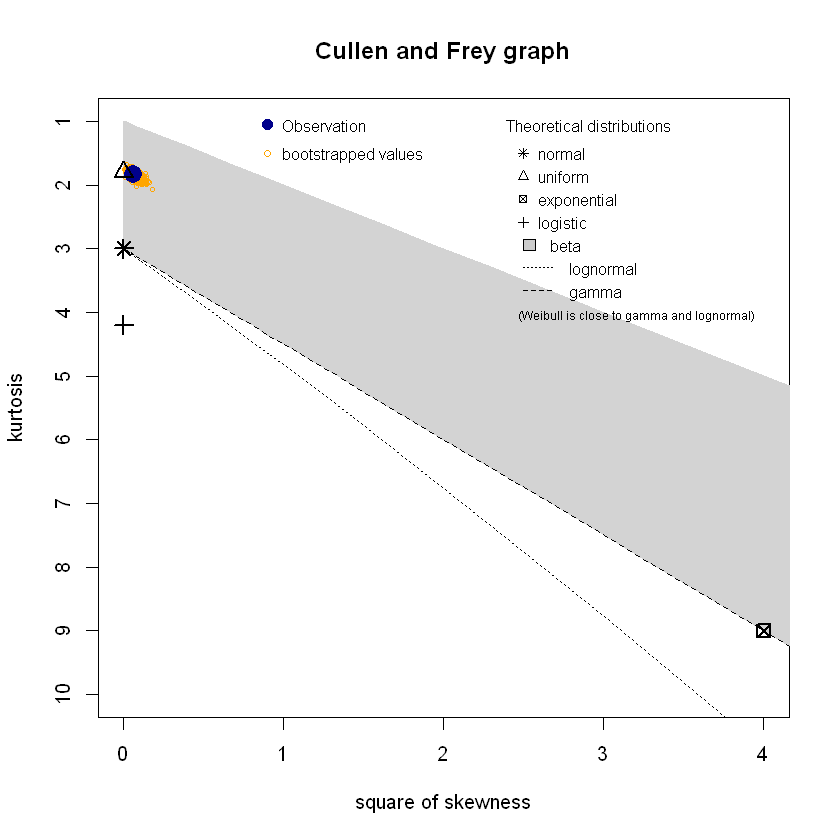

In [42]:
descdist(data$abs_max_temp, method = 'sample', boot = 1000)

Dane zostały umieszczone na wykresie w pobliżu rozkładu jednostajnego, lecz test porównawczy wykresów gęstości, dystrybuanty, QQ oraz PP (probability-probability) nie wskazuje na podobieństwo tych danych. Być może rozkład należy do pewnej rodziny rozkładów beta.

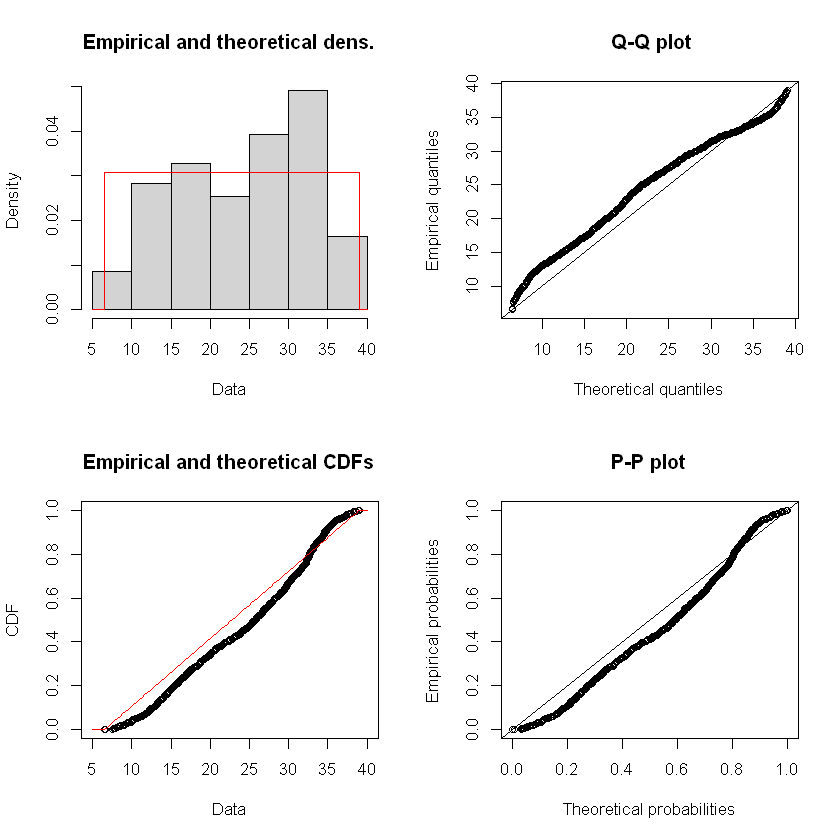

In [43]:
plot(fitdist(data$abs_max_temp, 'unif'))

### Średnia temperatura maksymalna

summary statistics
------
min:  -7.265079   max:  27.89506 
median:  12.76748 
mean:  12.15846 
sample sd:  8.470702 
sample skewness:  -0.1368746 
sample kurtosis:  1.736782 

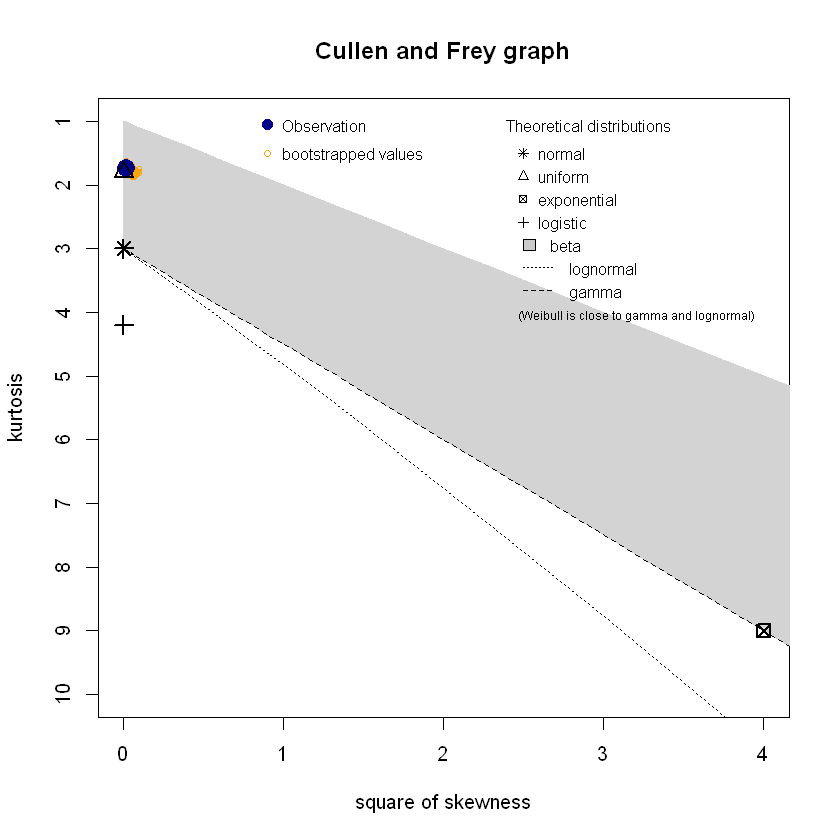

In [44]:
descdist(data$avg_max_temp, method = 'sample', boot = 1000)

Podobnie jest w przypadku zmiennej średniej temperatury maksymalnej - podejrzewam, iż może ona należeć do rozkładu beta.

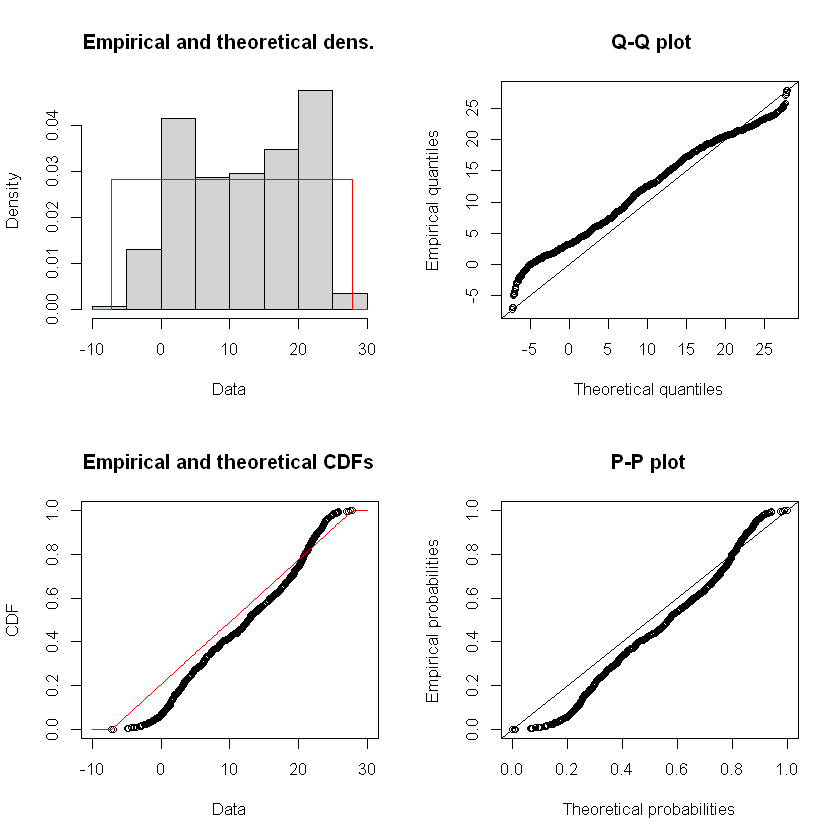

In [45]:
plot(fitdist(data$avg_max_temp, 'unif'))

### Absolutna temperatura minimalna

summary statistics
------
min:  -39   max:  3.5 
median:  -9.85 
mean:  -11.88329 
sample sd:  10.45894 
sample skewness:  -0.509003 
sample kurtosis:  2.140008 

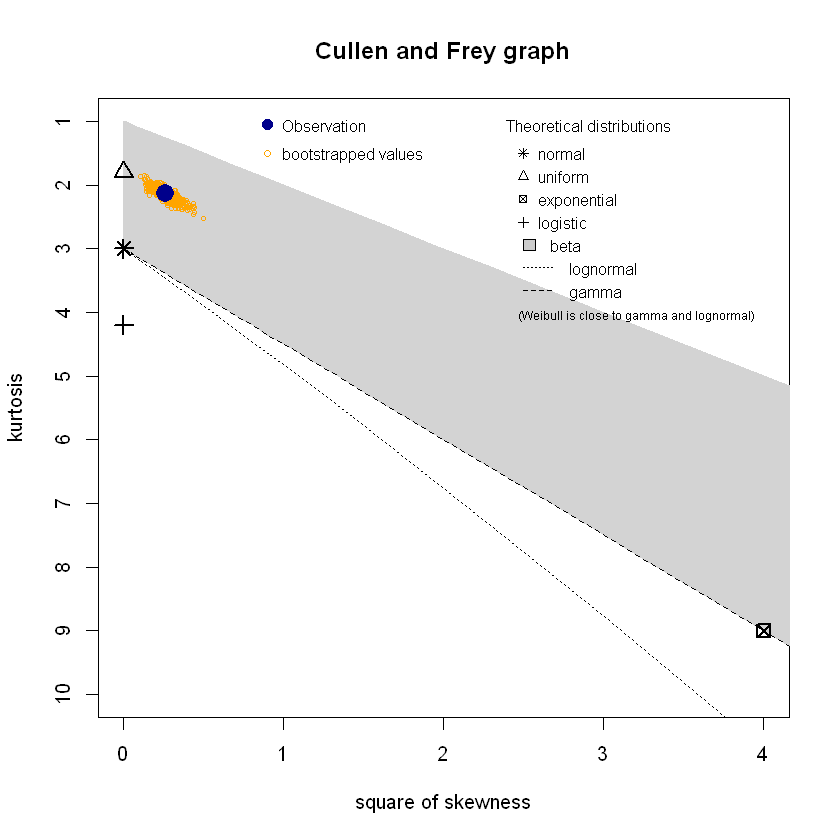

In [46]:
descdist(data$abs_min_temp, method = 'sample', boot = 1000)

Absolutna temperatura minimalna jest znacznie odsunięta od rozkładu normalnego lub jednostajnego, znajduje się w polu należącym do rozkładów beta.

### Średnia temperatura minimalna

summary statistics
------
min:  -16.20796   max:  14.57179 
median:  3.376583 
mean:  3.466789 
sample sd:  6.529434 
sample skewness:  -0.2774616 
sample kurtosis:  2.170496 

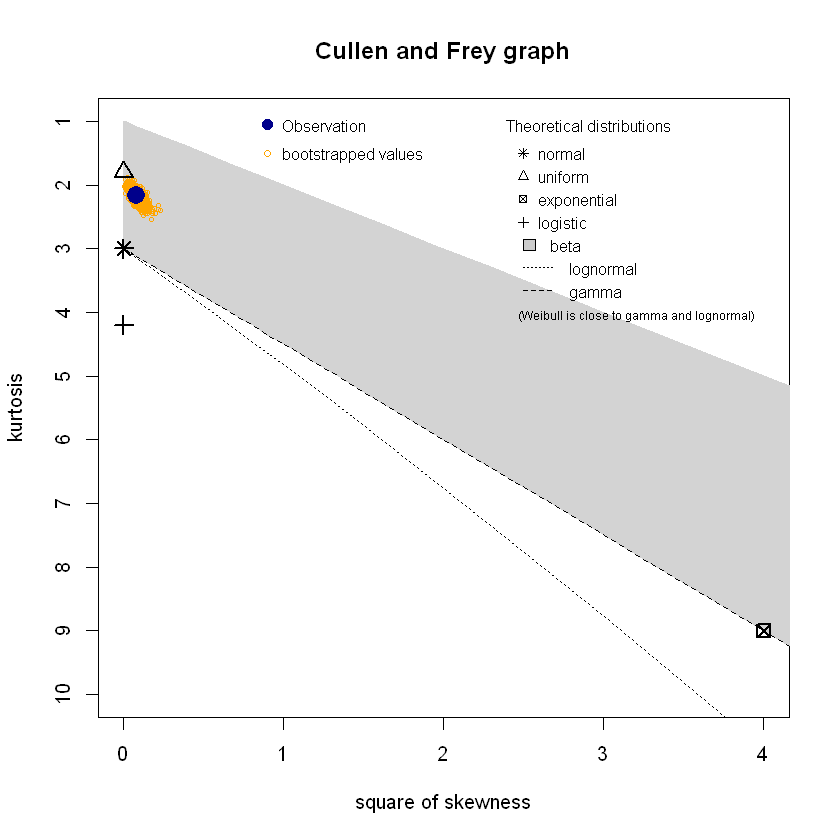

In [47]:
descdist(data$avg_min_temp, method = 'sample', boot = 1000)

Analogiczna sytuacja występuje w przypadku śrenidej temperatury minialnej.

### Średnia temperatura 

summary statistics
------
min:  -11.43009   max:  20.97099 
median:  7.76011 
mean:  7.660519 
sample sd:  7.462764 
sample skewness:  -0.1516437 
sample kurtosis:  1.868328 

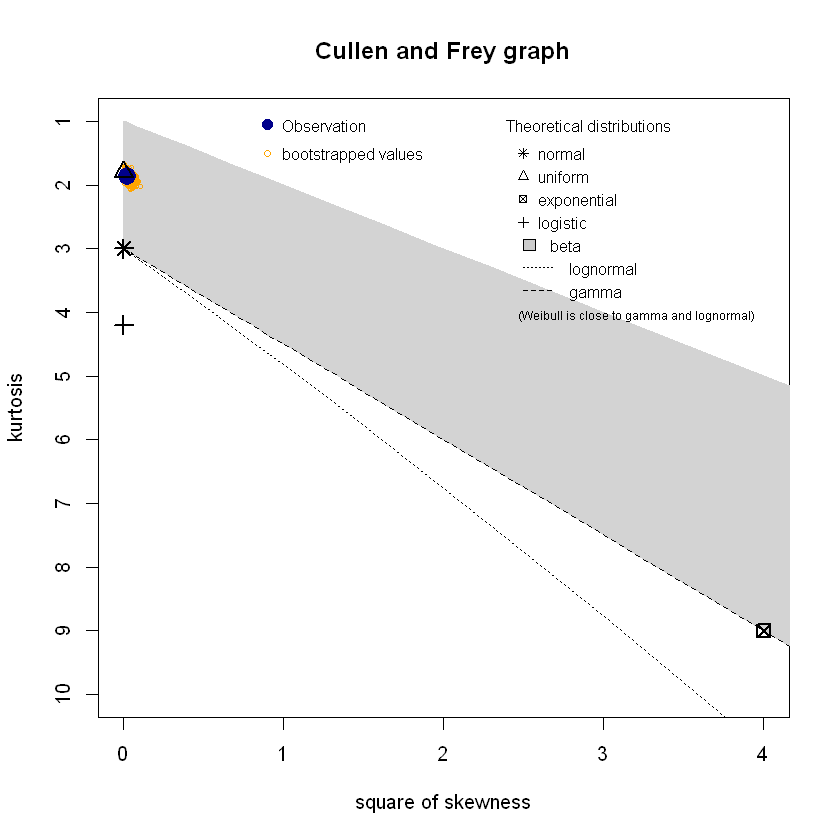

In [48]:
descdist(data$avg_temp, method = 'sample', boot = 1000)

Średnia temperatura jest bardzo blisko rozkładu jednostajnego, jednak wykresy nie potwierdzają tej hipotezy.

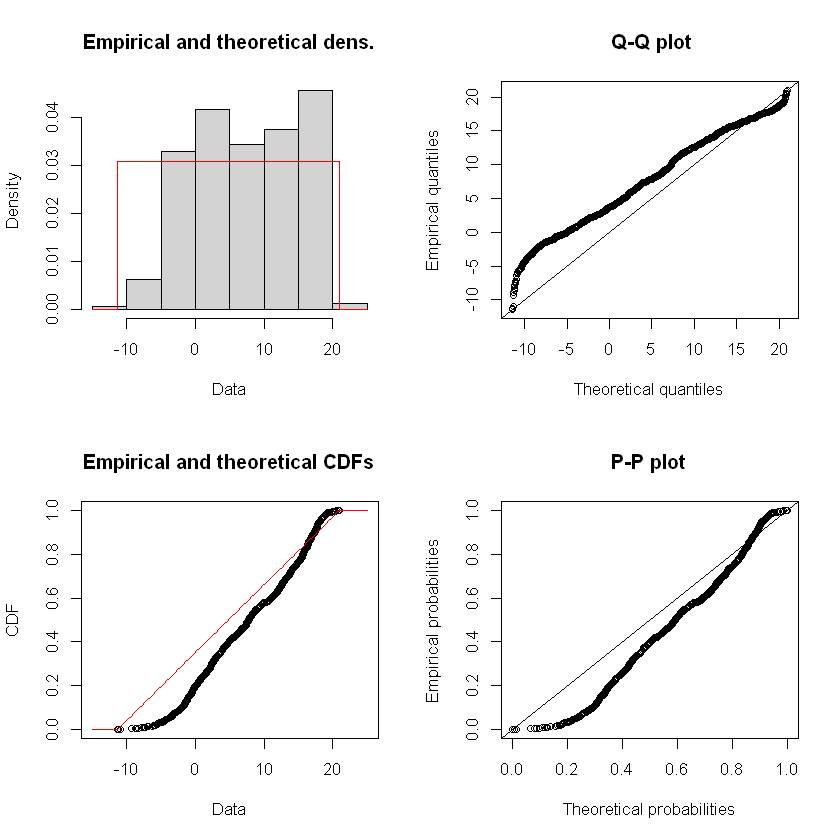

In [49]:
plot(fitdist(data$avg_temp, 'unif'))

### Miesięczna suma opadów

summary statistics
------
min:  2.464557   max:  229.6836 
median:  51.16702 
mean:  57.31838 
sample sd:  30.98595 
sample skewness:  1.2676 
sample kurtosis:  5.641607 

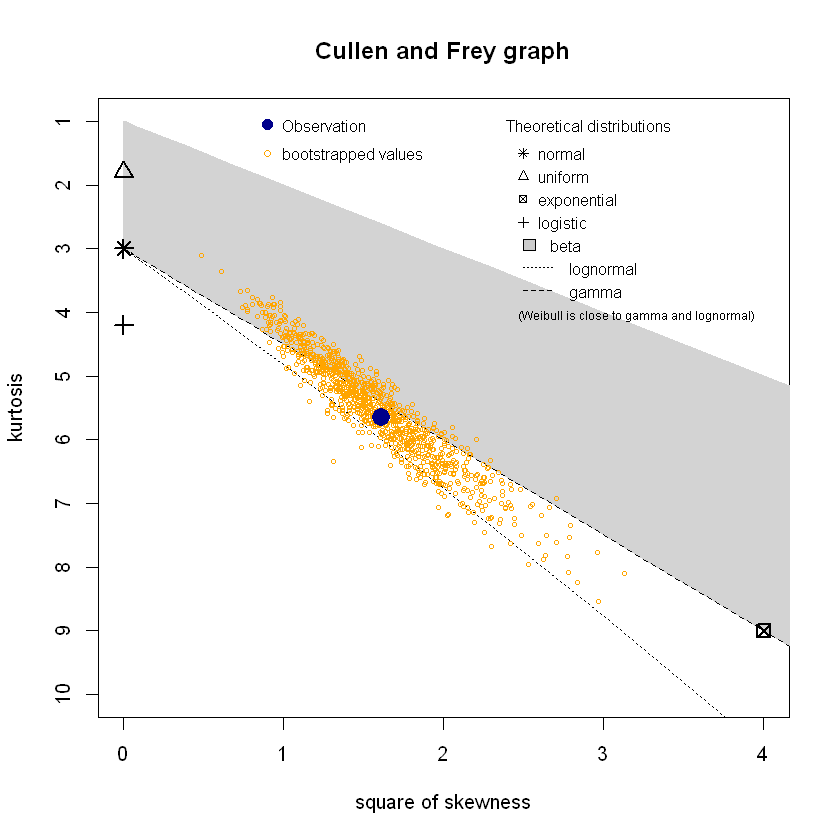

In [50]:
descdist(data$rain, method = 'sample', boot = 1000)

Miesięczna suma opadów znajduje się w innym obszarze wykresu i sugeruje pewien rozkład gamma lub rozkład logarytmicznie normalny. Porównanie wykresów nie wypada na korzyść rozkładu lognormal, jednak rozkład gamma mógłby być jednym z kandydatów w przypadku miesięcznej sumy opadów.

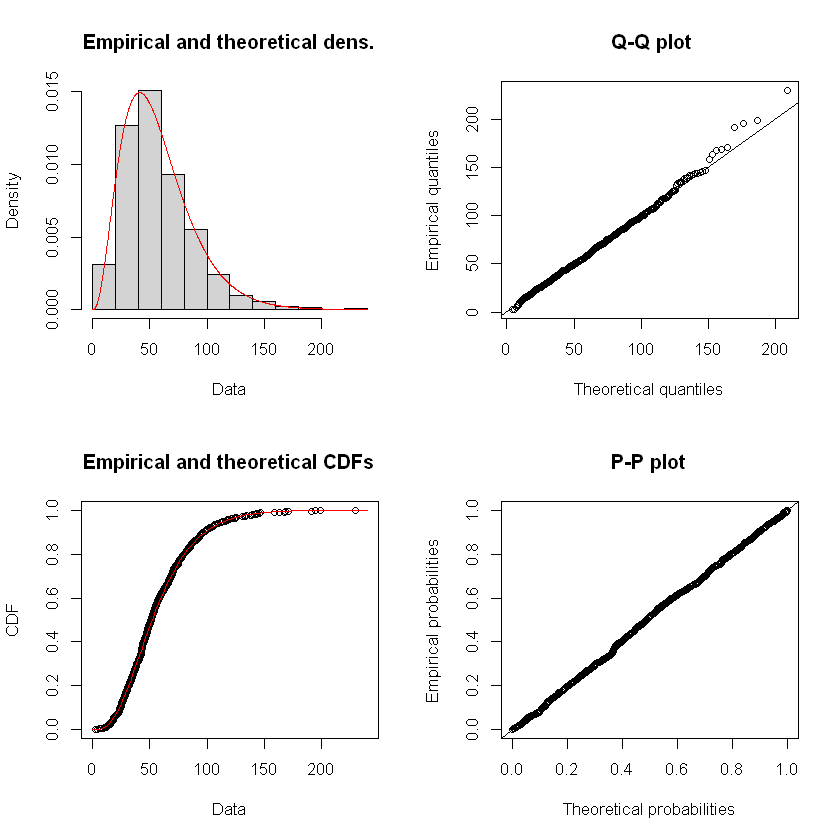

In [51]:
plot(fitdist(data$rain, 'gamma'))

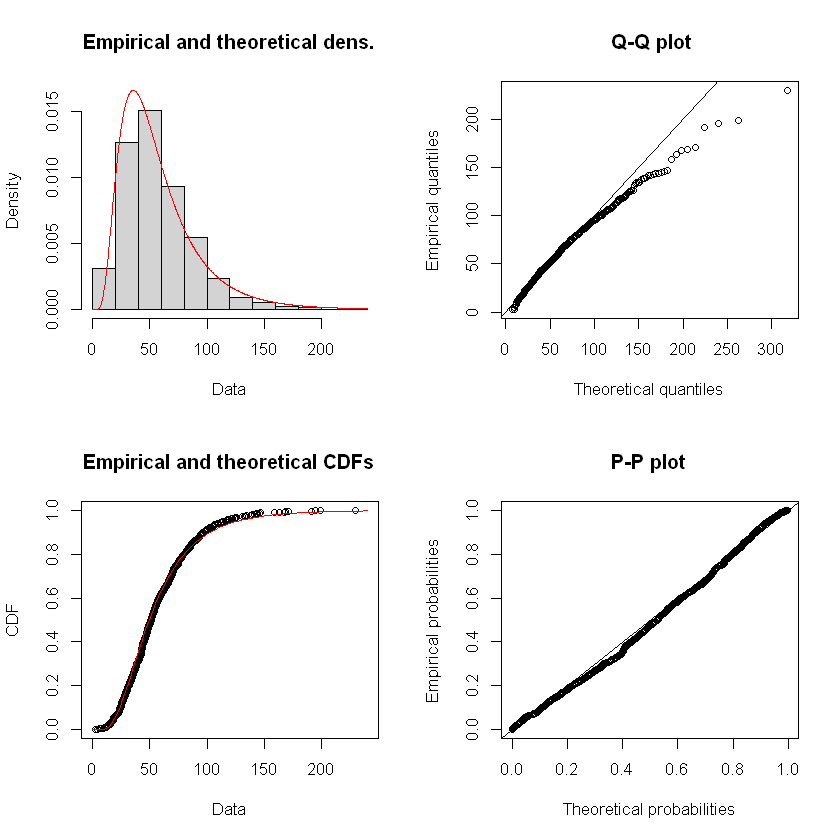

In [52]:
plot(fitdist(data$rain, 'lnorm'))

### Maksymalny opad dzienny

summary statistics
------
min:  7.6   max:  223.5 
median:  47.05 
mean:  54.06933 
sample sd:  30.9786 
sample skewness:  1.600164 
sample kurtosis:  6.868284 

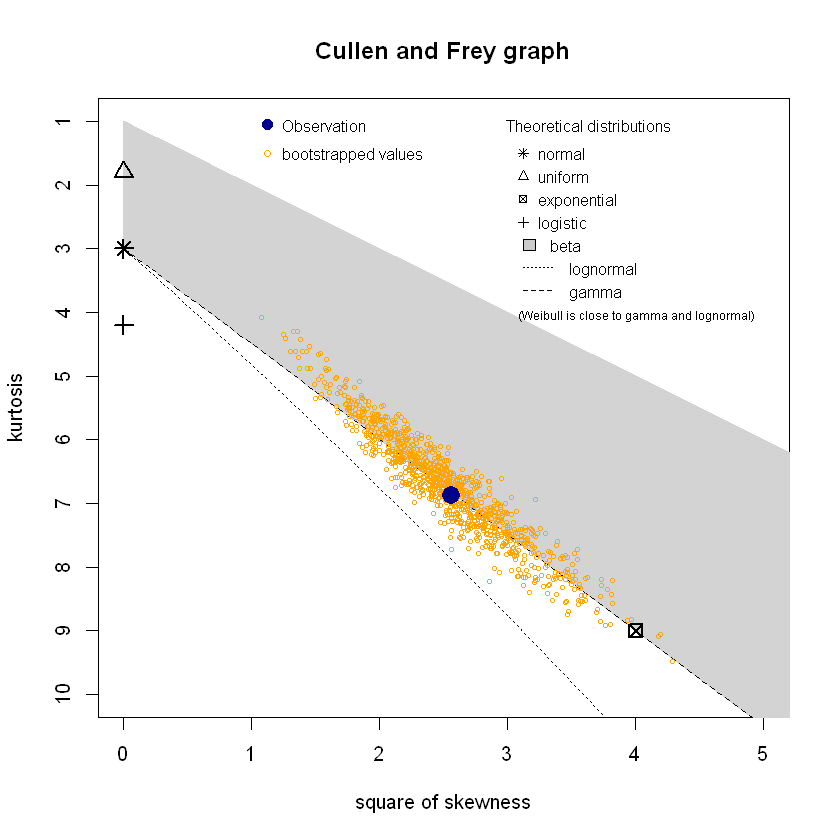

In [53]:
descdist(data$max_daily_rain, method = 'sample', boot = 1000)

Maksymalny opad dzienny znajduje się na linii rozkładów gamma, jednak nie wskazują na to wykresy od odpowiednich funkcji.

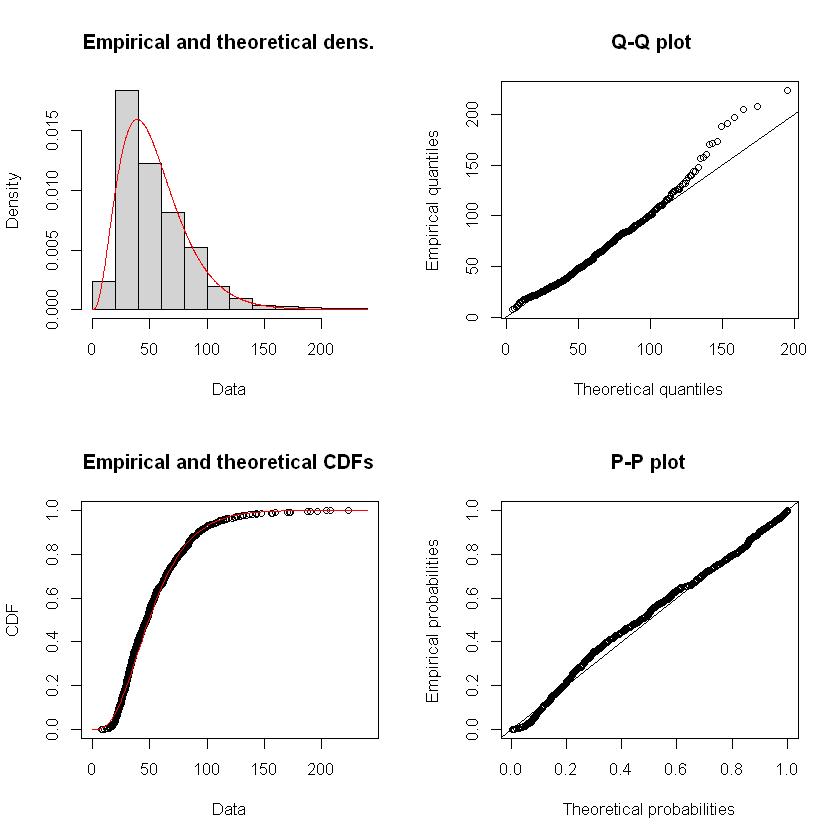

In [54]:
plot(fitdist(data$max_daily_rain, 'gamma'))

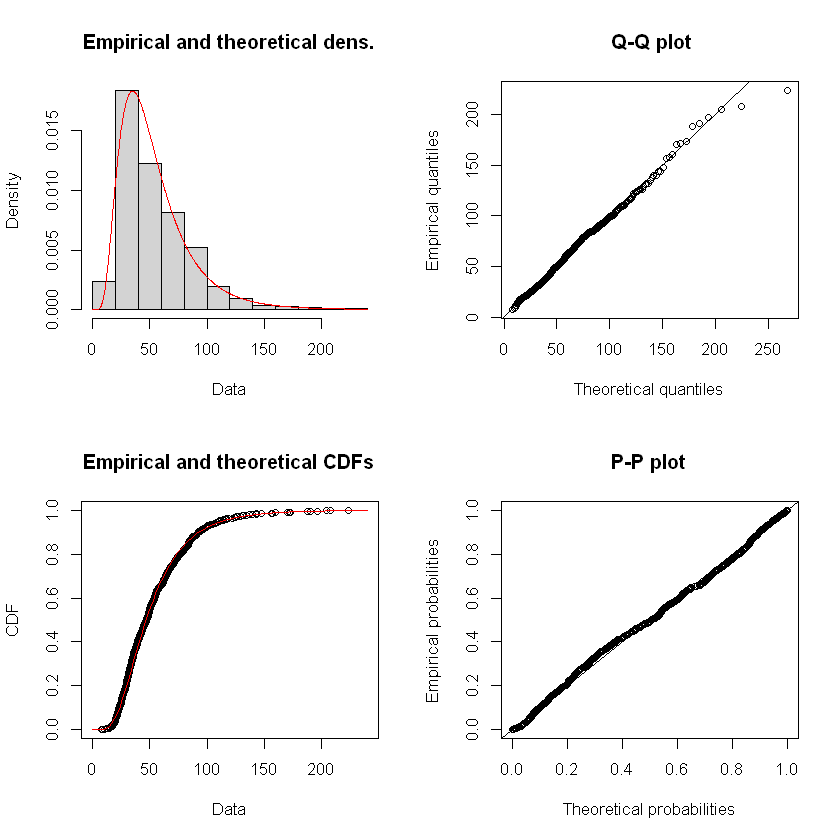

In [55]:
plot(fitdist(data$max_daily_rain, 'lnorm'))

### Maksymalna wysokość pokrywy śnieżnej

summary statistics
------
min:  0   max:  320 
median:  40.5 
mean:  66.97494 
sample sd:  73.22583 
sample skewness:  1.084205 
sample kurtosis:  3.482786 

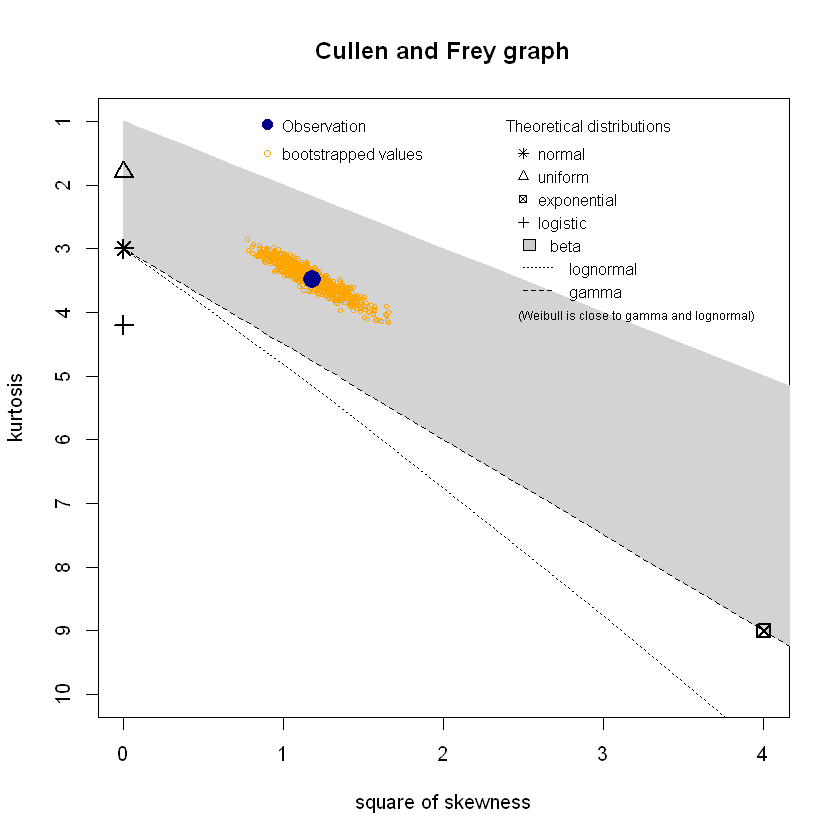

In [56]:
descdist(data$max_snow, method = 'sample', boot = 1000)

Maksymalna wysokość pokrywy śnieżnej może być potencjalnie jednym z rozkładów beta.

### Liczba dni z pokrywą śnieżną

summary statistics
------
min:  0   max:  30.85385 
median:  0.5178581 
mean:  5.242178 
sample sd:  7.998909 
sample skewness:  1.512048 
sample kurtosis:  4.09513 

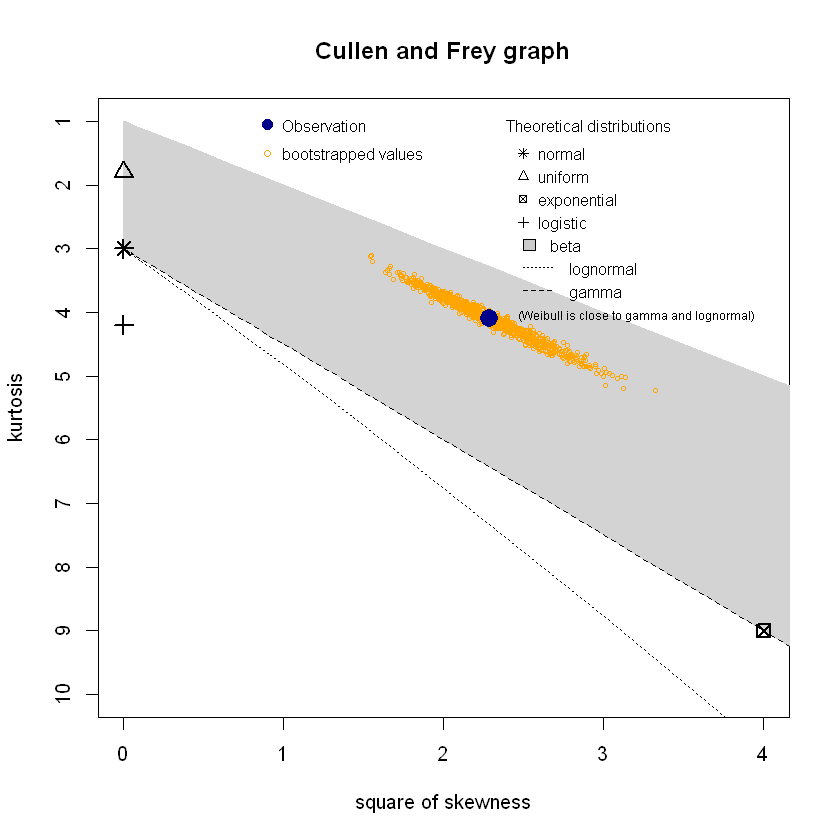

In [57]:
descdist(data$ice_sheet_days, method = 'sample', boot = 1000)

Podobnie liczba dni z pokrywą śnieżną.

### Liczba dni z opadem deszczu

summary statistics
------
min:  0.05325444   max:  23.51592 
median:  10.16003 
mean:  9.941235 
sample sd:  4.720838 
sample skewness:  0.03490718 
sample kurtosis:  2.485242 

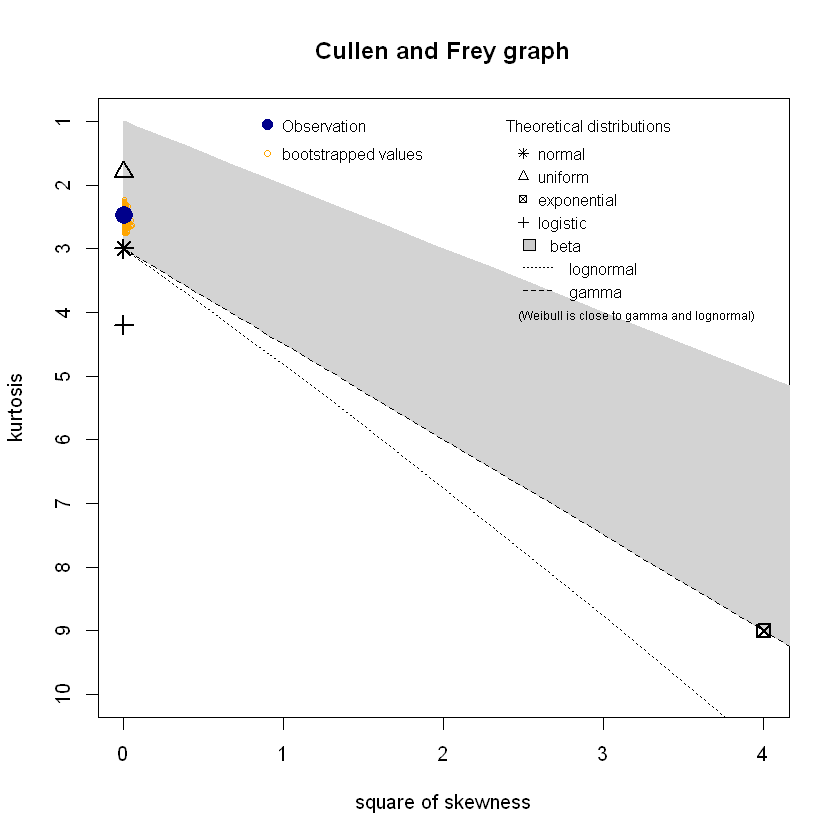

In [58]:
descdist(data$rainy_days, method = 'sample', boot = 1000)

Liczba dni z opadem deszczu znajduje się pomiędzy rozkładem normalnym oraz jednostajnym. W przypadku rozkładu jednostajnego wykresy zdecydowanie nie potwierdzają tej tezy, natomiast rozkład normalny nie został potwierdzony wcześniej przez test Shapiro-Wilka. Zmienna może zatem należeć do jednego z rozkładów beta.

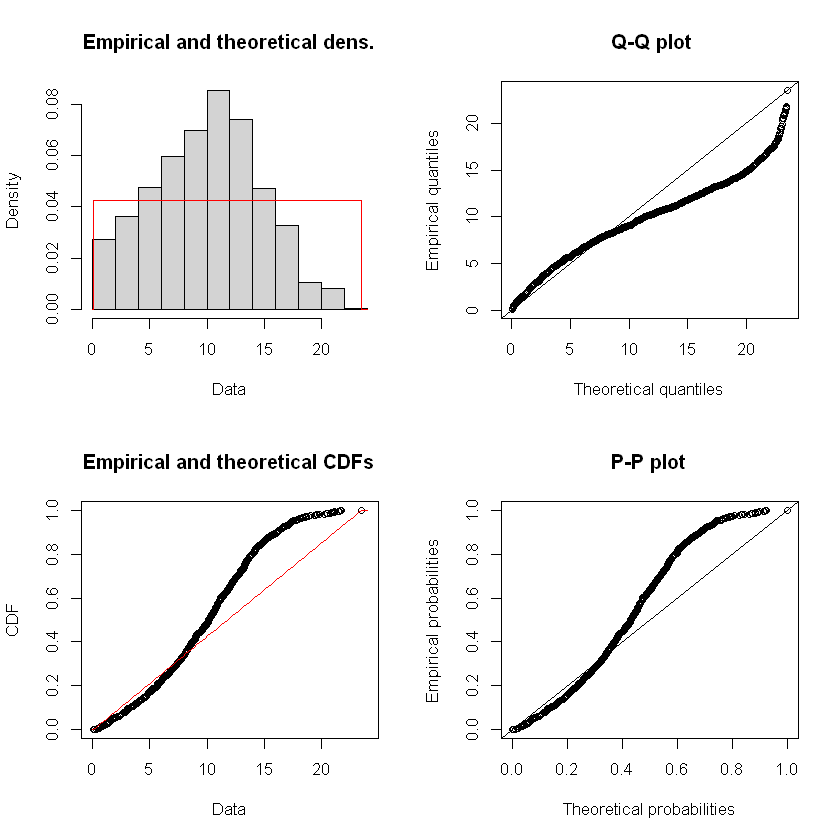

In [59]:
plot(fitdist(data$rainy_days, 'unif'))

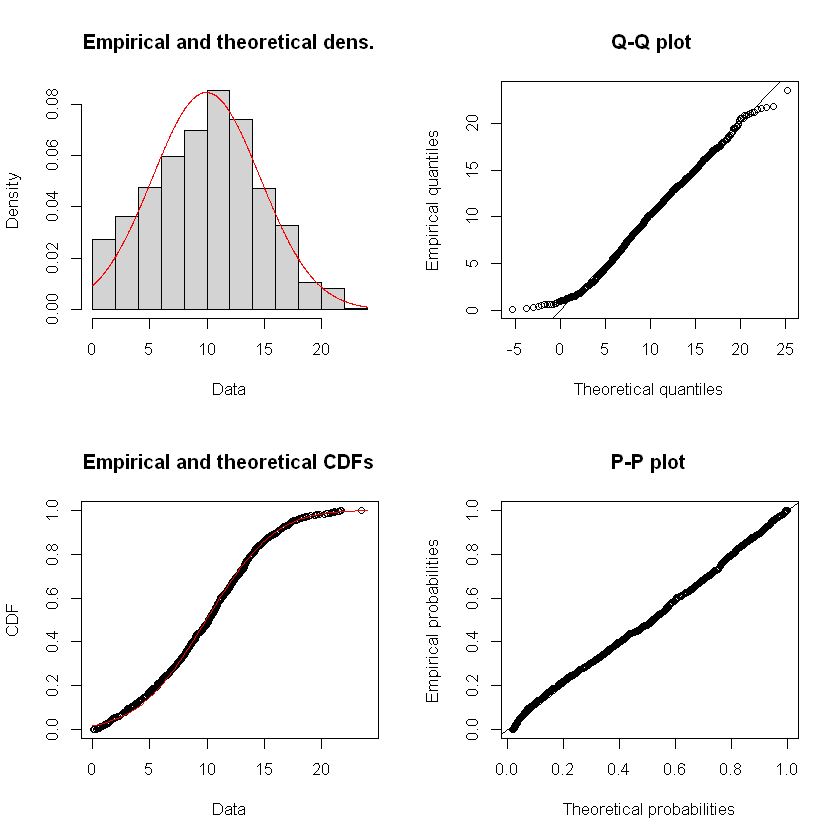

In [60]:
plot(fitdist(data$rainy_days, 'norm'))

### Liczba dni z opadem śniegu

summary statistics
------
min:  0   max:  19.35036 
median:  1.044979 
mean:  3.714934 
sample sd:  4.718432 
sample skewness:  1.135051 
sample kurtosis:  3.210196 

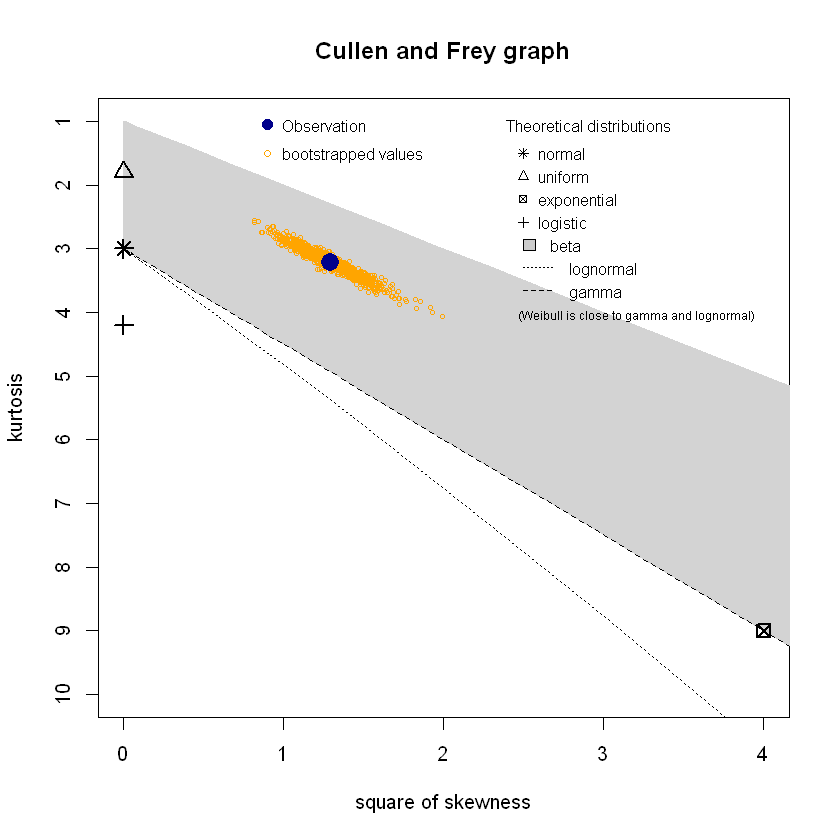

In [61]:
descdist(data$snowy_days, method = 'sample', boot = 1000)

Liczba dni z opadem śniegu jest również w obszarze rozkładów beta.

# Regresja liniowa

## Zależności pomiędzy wybranymi zmienymi

W tym punkcie zbadam zależności pomiędzy wybranymi zmiennymi za pomocą regresji liniowej

### Średnia temperatura oraz liczba dni z pokrywą śnieżną

In [62]:
summary(lm(ice_sheet_days ~ avg_temp, data = data))


Call:
lm(formula = ice_sheet_days ~ avg_temp, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.2900  -3.7916  -0.0617   2.9931  13.6534 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.00989    0.22449   53.50   <2e-16 ***
avg_temp    -0.88345    0.02099  -42.09   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.535 on 836 degrees of freedom
Multiple R-squared:  0.6794,	Adjusted R-squared:  0.679 
F-statistic:  1771 on 1 and 836 DF,  p-value: < 2.2e-16


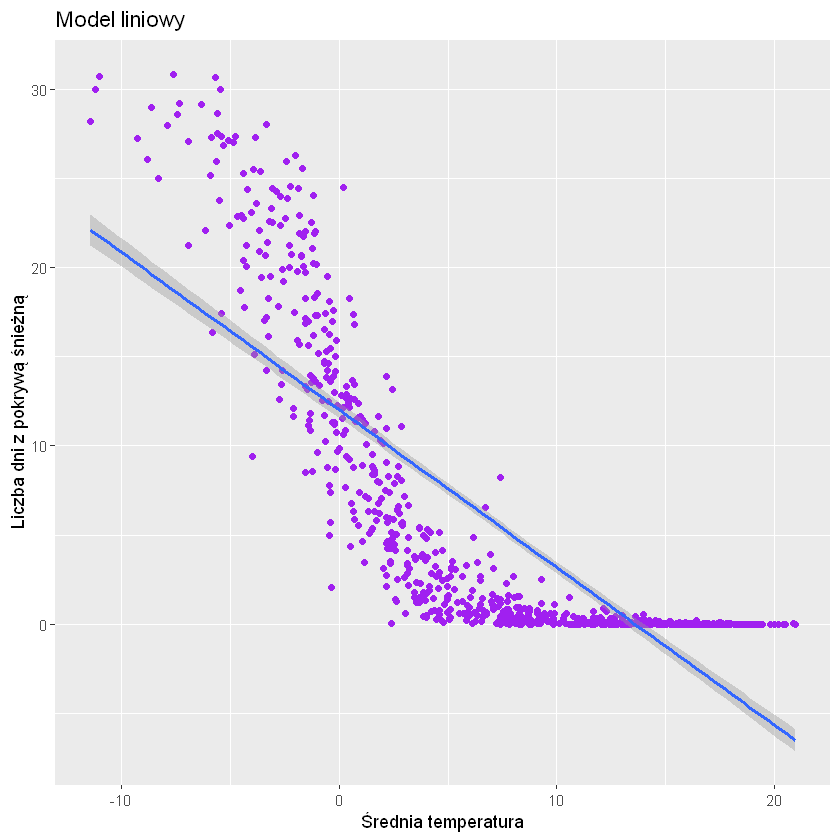

In [63]:
ggplot(data, aes(avg_temp, ice_sheet_days)) + 
    labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Średnia temperatura', title = 'Model liniowy') +
    geom_point(col = 'purple') +
    stat_smooth(method = lm, formula = y ~ x)

W przypadku zależności liczby dni z pokrywą śnieżną od średniej temperatury powietrza, model liniowy nie sprawdza się zbyt dobrze.

In [64]:
summary(lm(ice_sheet_days ~ poly(avg_temp, 5), data = data))


Call:
lm(formula = ice_sheet_days ~ poly(avg_temp, 5), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.0615  -0.2845  -0.0595   0.5028  13.0792 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           5.24218    0.08135  64.436  < 2e-16 ***
poly(avg_temp, 5)1 -190.85574    2.35506 -81.041  < 2e-16 ***
poly(avg_temp, 5)2  104.06265    2.35506  44.187  < 2e-16 ***
poly(avg_temp, 5)3    5.76480    2.35506   2.448   0.0146 *  
poly(avg_temp, 5)4  -40.09548    2.35506 -17.025  < 2e-16 ***
poly(avg_temp, 5)5   10.34417    2.35506   4.392 1.27e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.355 on 832 degrees of freedom
Multiple R-squared:  0.9139,	Adjusted R-squared:  0.9134 
F-statistic:  1767 on 5 and 832 DF,  p-value: < 2.2e-16


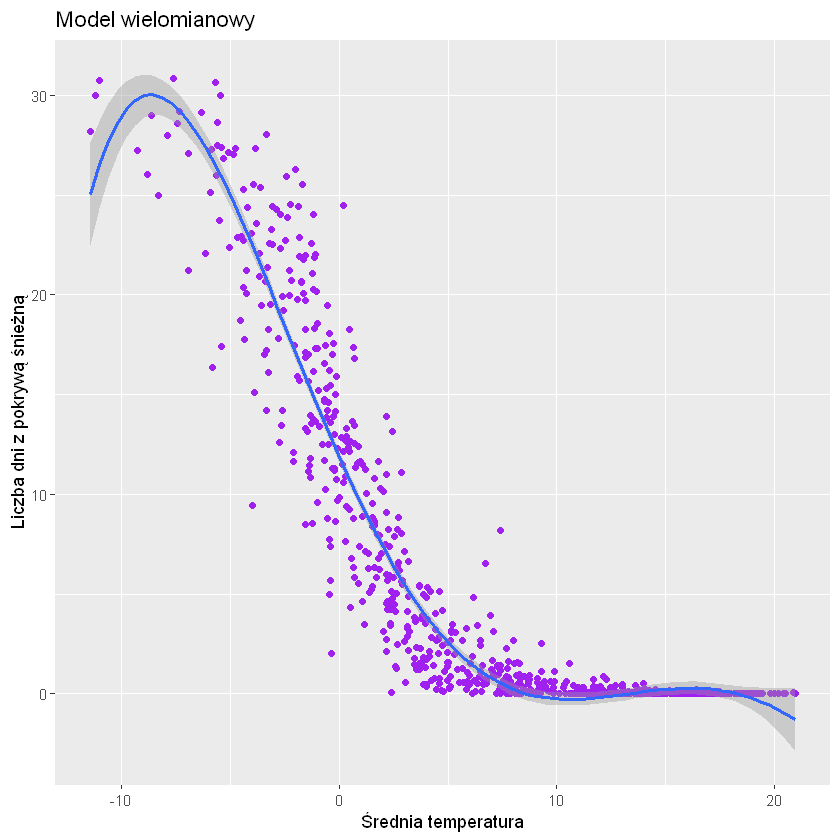

In [65]:
ggplot(data, aes(avg_temp, ice_sheet_days)) + 15
    labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Średnia temperatura', title = 'Model wielomianowy') + 
    geom_point(col = 'purple') + 
    stat_smooth(method = lm, formula = y ~ poly(x, 5)) 

Dopiero model wielomianowy 5 stopnia dość dobrze obrazuje tę zależność. Stopień wielomianu dobierałem w ten sposób, aby utrzymać jak najlepsze dopasowanie modelu, jednocześnie używając wielomianu najmniejszego stopnia.

### Średnia temperatura oraz liczba dni z opadem

In [66]:
summary(lm(rainy_days ~ avg_temp, data = data))


Call:
lm(formula = rainy_days ~ avg_temp, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5083  -2.2961  -0.3469   2.0920  11.9247 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.51241    0.16534   39.39   <2e-16 ***
avg_temp     0.44760    0.01546   28.95   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.34 on 836 degrees of freedom
Multiple R-squared:  0.5007,	Adjusted R-squared:  0.5001 
F-statistic: 838.2 on 1 and 836 DF,  p-value: < 2.2e-16


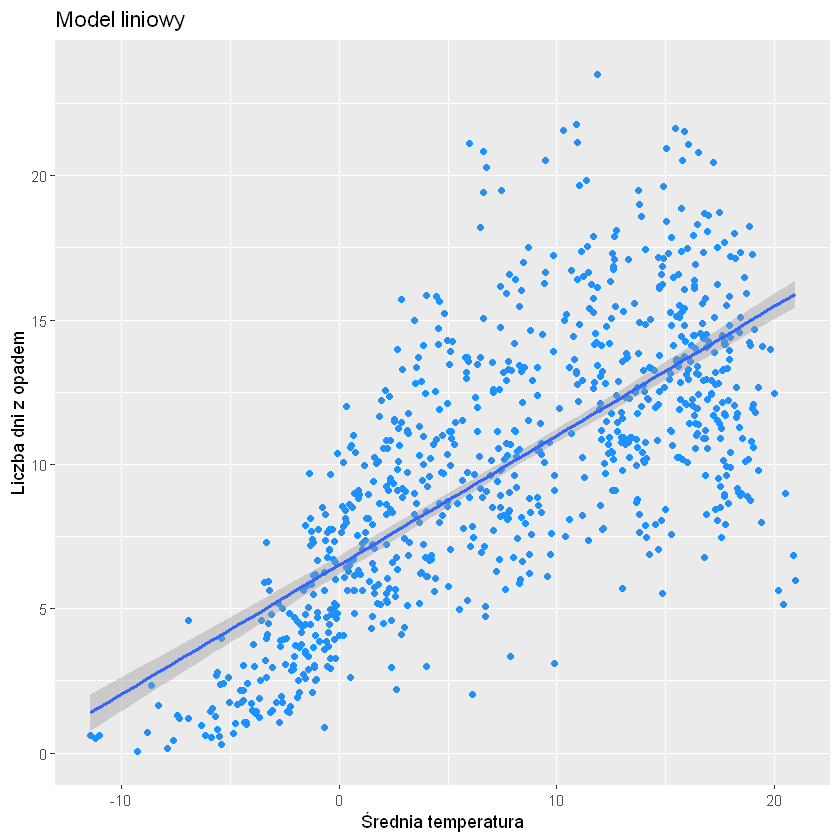

In [67]:
ggplot(data, aes(avg_temp, rainy_days)) + 
    labs(y = 'Liczba dni z opadem', x = 'Średnia temperatura', title = 'Model liniowy') +
    geom_point(col = 'dodgerblue') +
    stat_smooth(method = lm, formula = y ~ x)

In [68]:
summary(lm(rainy_days ~ poly(avg_temp, 3), data = data))


Call:
lm(formula = rainy_days ~ poly(avg_temp, 3), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5156 -2.0713 -0.1993  1.8808 10.5599 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          9.9412     0.1055   94.19  < 2e-16 ***
poly(avg_temp, 3)1  96.6960     3.0555   31.65  < 2e-16 ***
poly(avg_temp, 3)2 -35.9458     3.0555  -11.76  < 2e-16 ***
poly(avg_temp, 3)3 -15.7354     3.0555   -5.15 3.25e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.055 on 834 degrees of freedom
Multiple R-squared:  0.5831,	Adjusted R-squared:  0.5816 
F-statistic: 388.8 on 3 and 834 DF,  p-value: < 2.2e-16


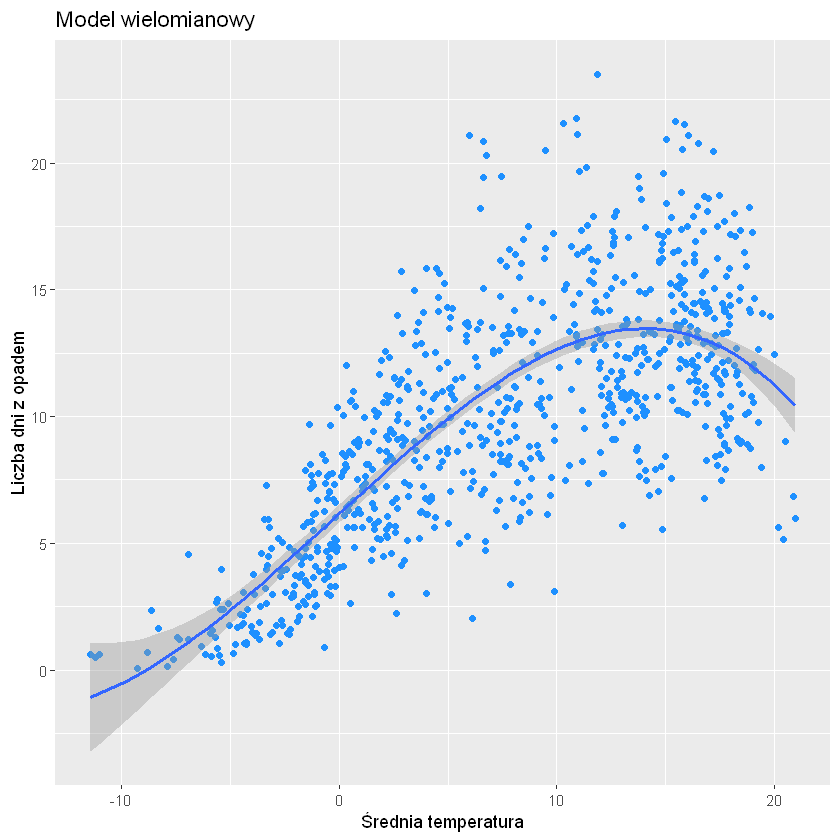

In [69]:
ggplot(data, aes(avg_temp, rainy_days)) + 
    labs(y = 'Liczba dni z opadem', x = 'Średnia temperatura', title = 'Model wielomianowy') + 
    geom_point(col = 'dodgerblue') + 
    stat_smooth(method = lm, formula = y ~ poly(x, 3)) 

Z powodu dużego rozproszenia danych, zarówno model używający funkcji liniowej, jak i wielomianowej nie obrazuje idealnie danych, jednak wskazuje odpowiedni trend - im wyższa średnia temperatura, tym więcej w miesiącu dni z opadem.

### Liczba dni z opadem śniegu oraz liczba dni z pokrywą śnieżną

In [70]:
summary(lm(ice_sheet_days ~ snowy_days, data = data))


Call:
lm(formula = ice_sheet_days ~ snowy_days, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.9543 -1.3076  0.3546  0.4121 18.0844 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.41213    0.15504  -2.658  0.00801 ** 
snowy_days   1.52205    0.02582  58.954  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.526 on 836 degrees of freedom
Multiple R-squared:  0.8061,	Adjusted R-squared:  0.8059 
F-statistic:  3476 on 1 and 836 DF,  p-value: < 2.2e-16


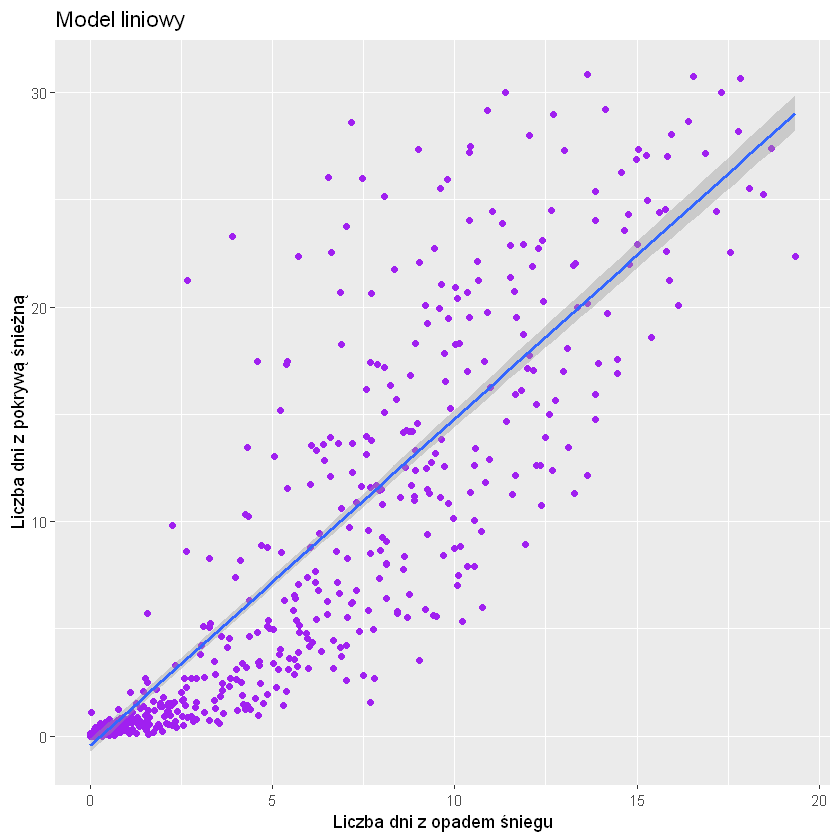

In [71]:
ggplot(data, aes(snowy_days, ice_sheet_days)) + 
    labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Liczba dni z opadem śniegu', title = 'Model liniowy') +
    geom_point(col = 'purple') +
    stat_smooth(method = lm, formula = y ~ x)

In [72]:
summary(lm(ice_sheet_days ~ poly(snowy_days, 3), data = data))


Call:
lm(formula = ice_sheet_days ~ poly(snowy_days, 3), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4959  -0.7638   0.0452   0.0806  18.8013 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            5.2422     0.1205  43.498  < 2e-16 ***
poly(snowy_days, 3)1 207.8971     3.4887  59.591  < 2e-16 ***
poly(snowy_days, 3)2   7.9025     3.4887   2.265 0.023759 *  
poly(snowy_days, 3)3 -13.5253     3.4887  -3.877 0.000114 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.489 on 834 degrees of freedom
Multiple R-squared:  0.8107,	Adjusted R-squared:   0.81 
F-statistic:  1190 on 3 and 834 DF,  p-value: < 2.2e-16


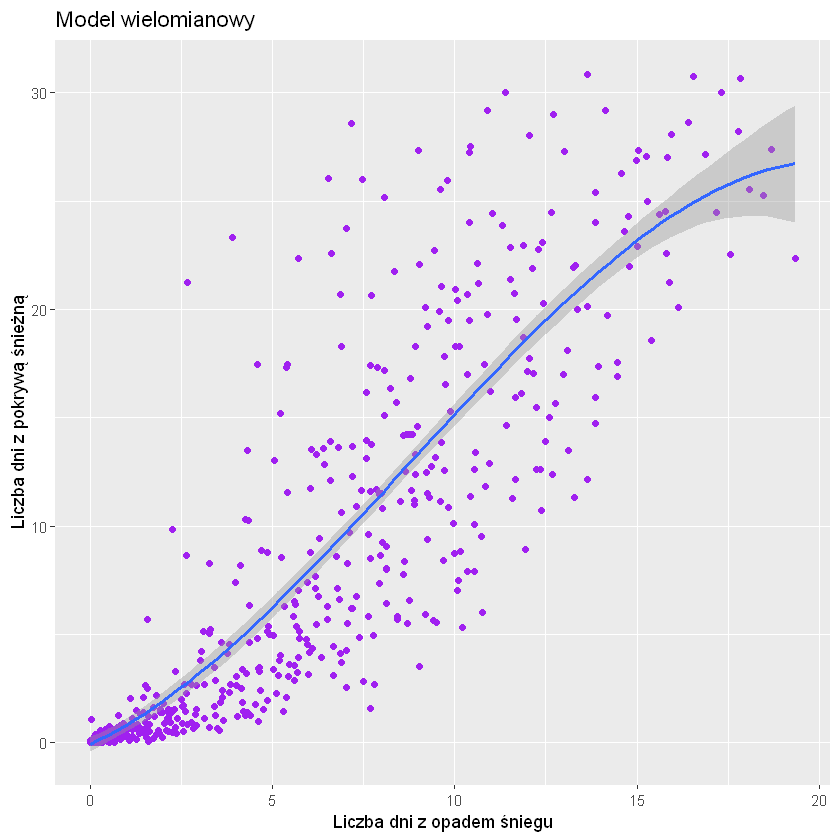

In [73]:
ggplot(data, aes(snowy_days, ice_sheet_days)) + 
    labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Liczba dni z opadem śniegu', title = 'Model wielomianowy') + 
    geom_point(col = 'purple') + 
    stat_smooth(method = lm, formula = y ~ poly(x, 3)) 

Dla zmiennej liczbu dni z pokrywą śnieżną od liczby dni z opadem śniegu, model wielomianowy nie wnosi wiele. Model liniowy obrazuje wystarczająco dobrze odpowiednią zależność.

### Średnia temperatura oraz maksymalny dzienny opad

In [74]:
summary(lm(max_daily_rain ~ avg_temp, data = data))


Call:
lm(formula = max_daily_rain ~ avg_temp, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.092 -14.742  -2.917   8.780 143.891 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  32.5940     1.1324   28.78   <2e-16 ***
avg_temp      2.8034     0.1059   26.48   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22.87 on 836 degrees of freedom
Multiple R-squared:  0.4561,	Adjusted R-squared:  0.4554 
F-statistic:   701 on 1 and 836 DF,  p-value: < 2.2e-16


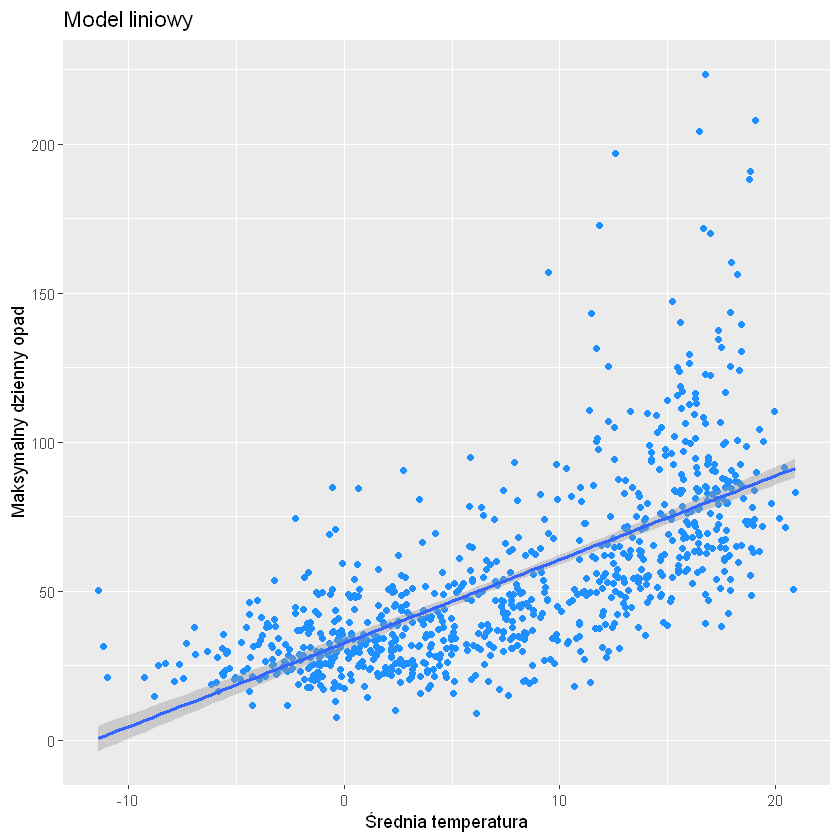

In [75]:
ggplot(data, aes(avg_temp, max_daily_rain)) + 
    labs(y = 'Maksymalny dzienny opad', x = 'Średnia temperatura', title = 'Model liniowy') +
    geom_point(col = 'dodgerblue') +
    stat_smooth(method = lm, formula = y ~ x)

In [76]:
summary(lm(max_daily_rain ~ poly(avg_temp, 5), data = data))


Call:
lm(formula = max_daily_rain ~ poly(avg_temp, 5), data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.605 -11.769  -3.609   7.615 136.872 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         54.0693     0.7606  71.092  < 2e-16 ***
poly(avg_temp, 5)1 605.6257    22.0168  27.507  < 2e-16 ***
poly(avg_temp, 5)2 165.4256    22.0168   7.514 1.49e-13 ***
poly(avg_temp, 5)3  -8.2316    22.0168  -0.374  0.70859    
poly(avg_temp, 5)4 -54.7686    22.0168  -2.488  0.01306 *  
poly(avg_temp, 5)5 -60.7413    22.0168  -2.759  0.00593 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22.02 on 832 degrees of freedom
Multiple R-squared:  0.4985,	Adjusted R-squared:  0.4955 
F-statistic: 165.4 on 5 and 832 DF,  p-value: < 2.2e-16


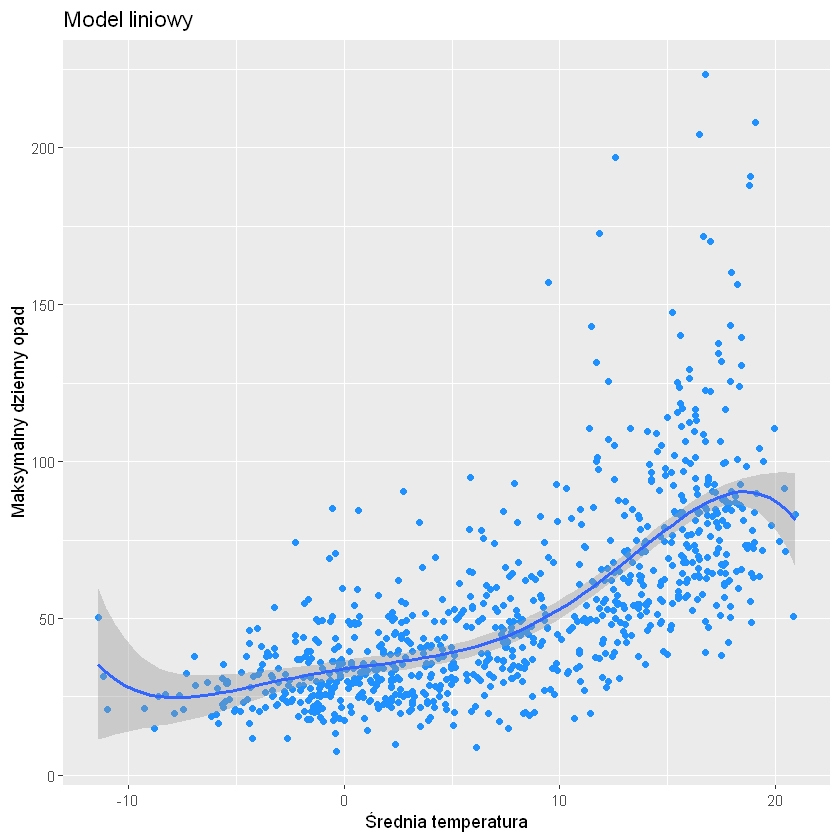

In [77]:
ggplot(data, aes(avg_temp, max_daily_rain)) + 
    labs(y = 'Maksymalny dzienny opad', x = 'Średnia temperatura', title = 'Model liniowy') +
    geom_point(col = 'dodgerblue') +
    stat_smooth(method = lm, formula = y ~ poly(x, 5))

Duży rozrzut danych może być przyczyną uzyskania niskich wartości współczynników dopasowania zmiennych, ale odpowiednie modele obrazują zależność: im większa średnia temperatura, tym większy maksymalny dzienny opad.

## Zależność od czasu

Wybrałem kilka zmiennych w danych z podziałem na lata, aby sprawdzić czy regresja liniowa ma zastosowanie w analizie zmiennych meteorologicznych w zależności od czasu. Niestety rozrzut danych, a więc zmienność pogody nie pozwala na dobre dopasowanie modeli. 

### Średnia temperatura

In [78]:
summary(lm(avg_temp ~ year, data = years))


Call:
lm(formula = avg_temp ~ year, data = years)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.92534 -0.42613 -0.02274  0.58780  1.95315 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -30.867930   8.903147  -3.467 0.000917 ***
year          0.019404   0.004484   4.328 5.06e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.758 on 68 degrees of freedom
Multiple R-squared:  0.2159,	Adjusted R-squared:  0.2044 
F-statistic: 18.73 on 1 and 68 DF,  p-value: 5.065e-05


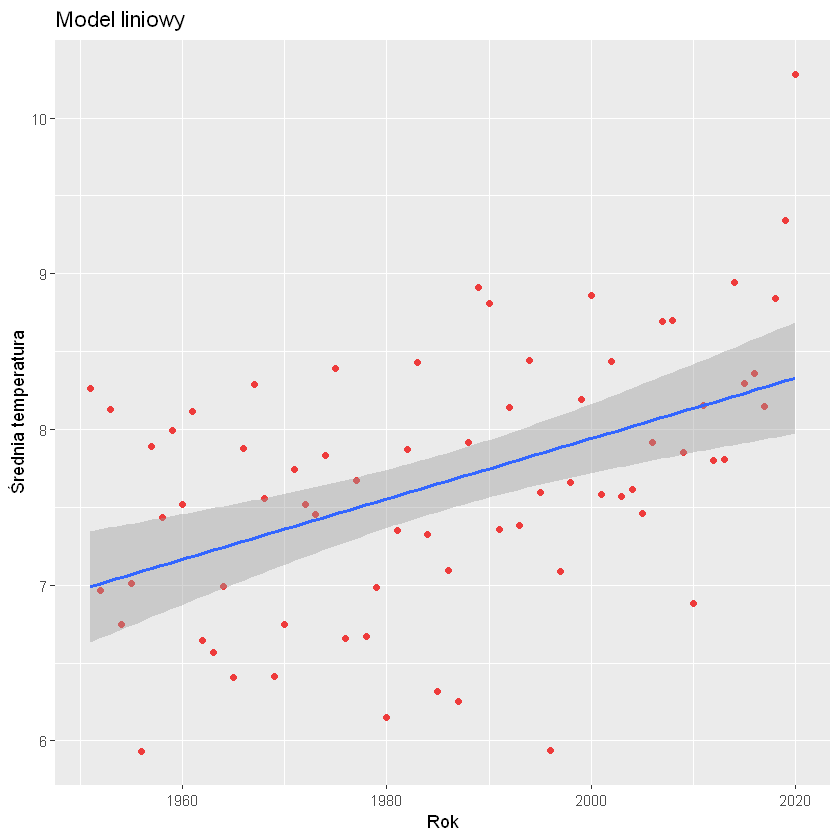

In [79]:
ggplot(years, aes(year, avg_temp)) + 
    labs(y = 'Średnia temperatura', x = 'Rok', title = 'Model liniowy') +
    geom_point(col = 'brown2') +
    stat_smooth(method = lm, formula = y ~ x)

### Roczna suma opadów

In [80]:
summary(lm(rain ~ year, data = years))


Call:
lm(formula = rain ~ year, data = years)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.3914  -6.2877  -0.0789   5.7927  20.4917 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -324.59124   88.89696  -3.651 0.000508 ***
year           0.19236    0.04477   4.297 5.65e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.568 on 68 degrees of freedom
Multiple R-squared:  0.2135,	Adjusted R-squared:  0.2019 
F-statistic: 18.46 on 1 and 68 DF,  p-value: 5.654e-05


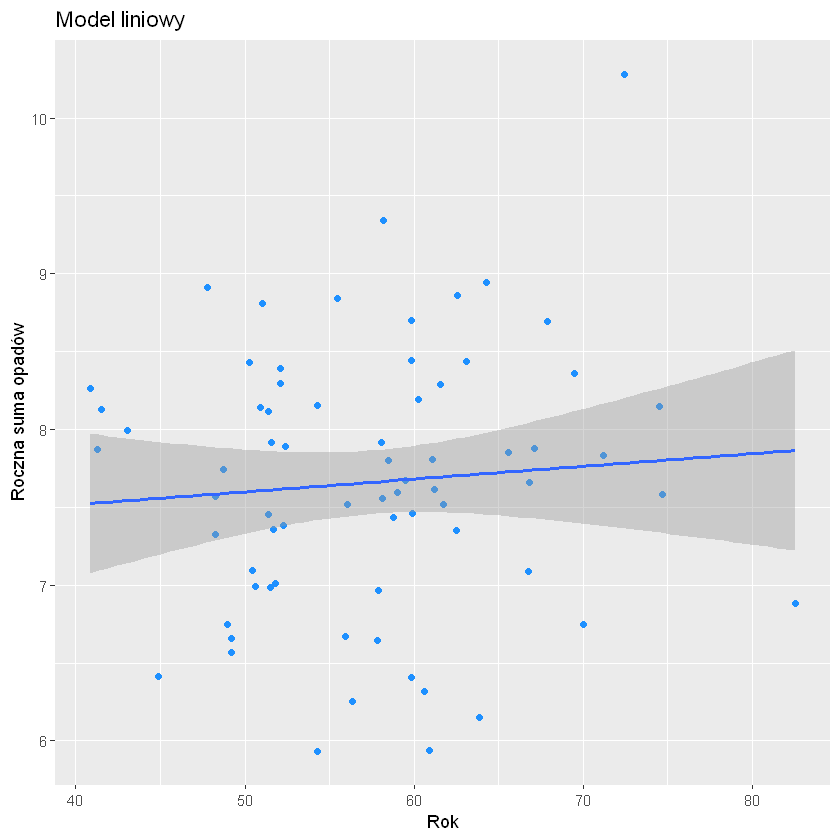

In [81]:
ggplot(years, aes(rain, avg_temp)) + 
    labs(y = 'Roczna suma opadów', x = 'Rok', title = 'Model liniowy') +
    geom_point(col = 'dodgerblue') +
    stat_smooth(method = lm, formula = y ~ x)

### Liczba dni z pokrywą śnieżną

In [82]:
summary(lm(ice_sheet_days ~ year, data = years))


Call:
lm(formula = ice_sheet_days ~ year, data = years)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.368 -13.014   0.074  12.667  42.432 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 490.1078   237.3552   2.065   0.0428 *
year         -0.2152     0.1195  -1.801   0.0762 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20.21 on 68 degrees of freedom
Multiple R-squared:  0.04551,	Adjusted R-squared:  0.03147 
F-statistic: 3.242 on 1 and 68 DF,  p-value: 0.07621


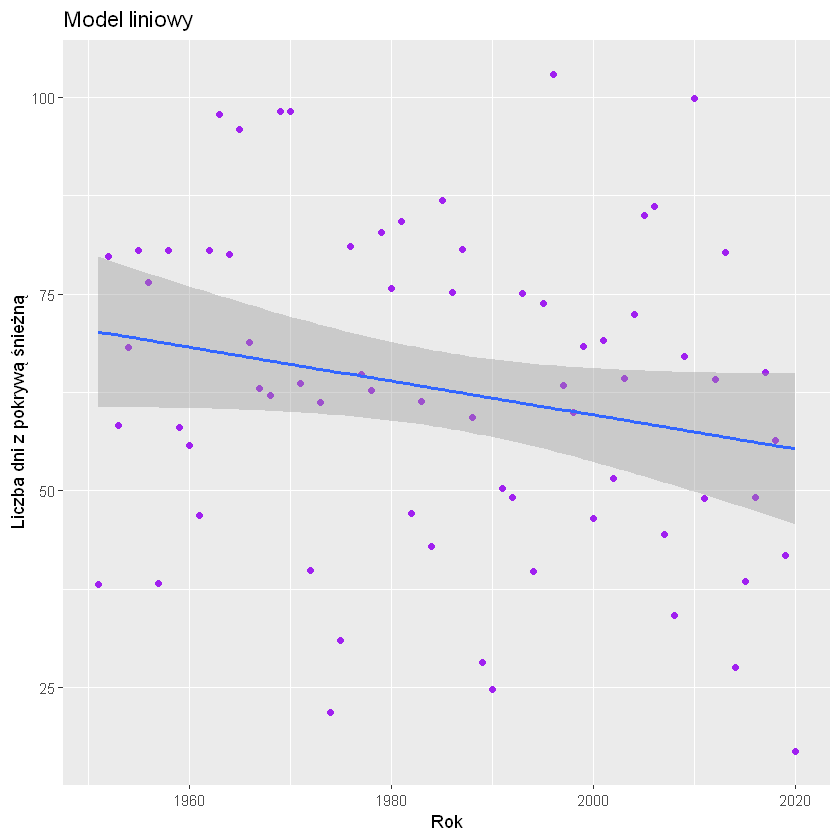

In [83]:
ggplot(years, aes(year, ice_sheet_days)) + 
    labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Rok', title = 'Model liniowy') +
    geom_point(col = 'purple') +
    stat_smooth(method = lm, formula = y ~ x)

## Regresja wielu zmiennych

Zależności poszczególnych zmiennych pozwalają na zbudowanie dokładniejszego modelu w oparciu nie o jedną, ale o kilka pomiarów. Oto wybrane przykłady:

### Średnia temperatura

In [84]:
summary(lm(avg_temp ~ rainy_days + snowy_days + rain, data = data))


Call:
lm(formula = avg_temp ~ rainy_days + snowy_days + rain, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.1728  -2.1359   0.0146   2.2212   9.8785 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.898400   0.445996  22.194  < 2e-16 ***
rainy_days  -0.345395   0.053680  -6.434 2.09e-10 ***
snowy_days  -1.326884   0.035600 -37.272  < 2e-16 ***
rain         0.106860   0.006366  16.786  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.235 on 834 degrees of freedom
Multiple R-squared:  0.813,	Adjusted R-squared:  0.8124 
F-statistic:  1209 on 3 and 834 DF,  p-value: < 2.2e-16


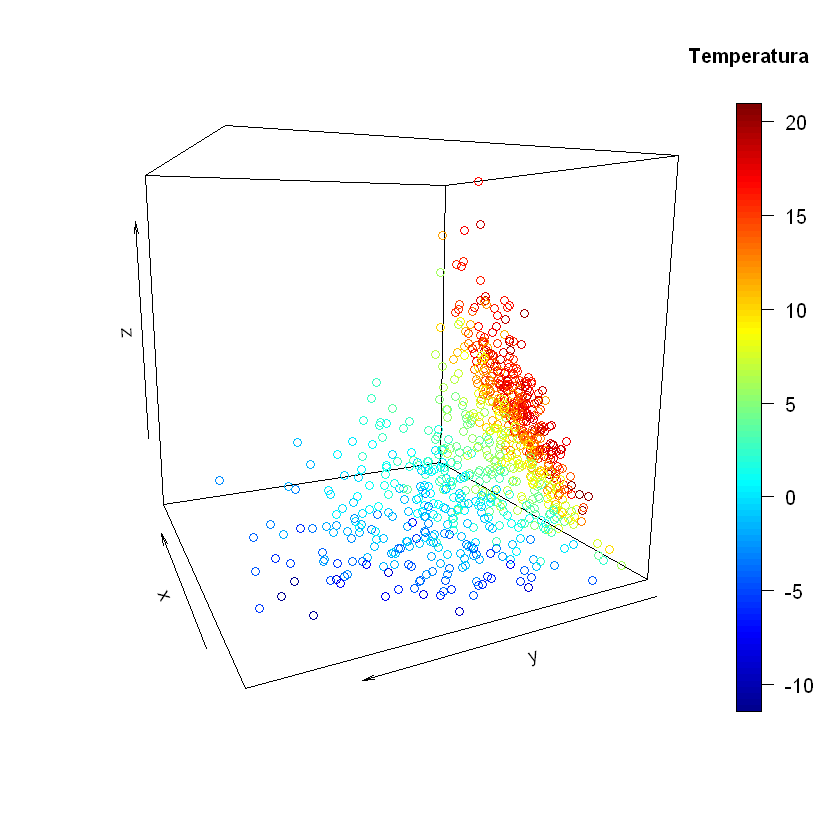

In [85]:
scatter3D(data$rainy_days, data$snowy_days, data$rain, colvar = data$avg_temp, clab = c('Temperatura'), theta = -115, phi = 10)

Model z użyciem trzech zmiennych daje dobre wyniki i jest możliwy do zwizualizować na wykresie, ale można go nieznacznie poprawić używając większej ilości danych.

In [86]:
summary(lm(avg_temp ~ rainy_days + snowy_days + rain + ice_sheet_days + max_daily_rain, data = data))


Call:
lm(formula = avg_temp ~ rainy_days + snowy_days + rain + ice_sheet_days + 
    max_daily_rain, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.4923  -2.1568  -0.0026   2.1043   9.1210 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     9.693524   0.510816  18.977  < 2e-16 ***
rainy_days     -0.404541   0.057329  -7.056 3.60e-12 ***
snowy_days     -0.816553   0.053402 -15.291  < 2e-16 ***
rain            0.080085   0.008548   9.369  < 2e-16 ***
ice_sheet_days -0.320606   0.031776 -10.089  < 2e-16 ***
max_daily_rain  0.039068   0.006033   6.476 1.61e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.983 on 832 degrees of freedom
Multiple R-squared:  0.8414,	Adjusted R-squared:  0.8404 
F-statistic: 882.7 on 5 and 832 DF,  p-value: < 2.2e-16


### Liczba dni z opadem

In [87]:
summary(lm(rainy_days ~ avg_temp + ice_sheet_days + rain, data = data))


Call:
lm(formula = rainy_days ~ avg_temp + ice_sheet_days + rain, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1727 -1.2506 -0.0352  1.2139  6.6933 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     7.06309    0.21233  33.265  < 2e-16 ***
avg_temp       -0.11187    0.01806  -6.196 9.09e-10 ***
ice_sheet_days -0.36643    0.01494 -24.525  < 2e-16 ***
rain            0.09868    0.00267  36.953  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.924 on 834 degrees of freedom
Multiple R-squared:  0.8347,	Adjusted R-squared:  0.8341 
F-statistic:  1404 on 3 and 834 DF,  p-value: < 2.2e-16


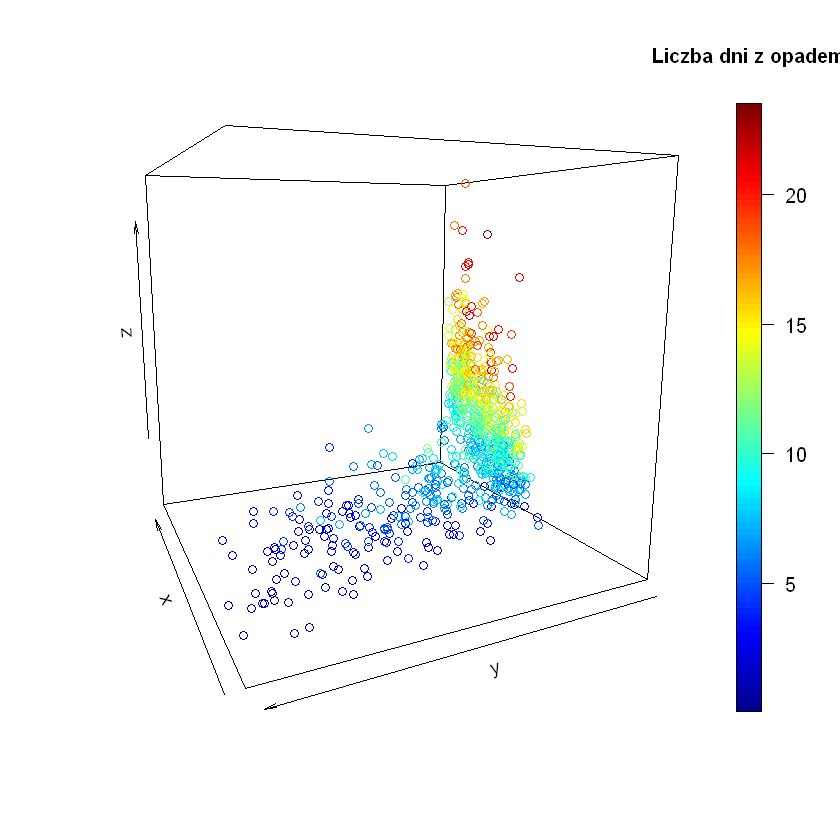

In [88]:
scatter3D(data$avg_temp, data$ice_sheet_days, data$rain, colvar = data$rainy_days, clab = c('Liczba dni z opadem'), theta = -115, phi = 10)

In [89]:
summary(lm(rainy_days ~ avg_temp + snowy_days + rain + ice_sheet_days, data = data))


Call:
lm(formula = rainy_days ~ avg_temp + snowy_days + rain + ice_sheet_days, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.9203 -1.1006 -0.0362  1.2157  6.1864 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     8.002005   0.228341  35.044   <2e-16 ***
avg_temp       -0.197092   0.019700 -10.005   <2e-16 ***
snowy_days     -0.313030   0.034924  -8.963   <2e-16 ***
rain            0.104067   0.002622  39.696   <2e-16 ***
ice_sheet_days -0.258101   0.018706 -13.798   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.839 on 833 degrees of freedom
Multiple R-squared:  0.8492,	Adjusted R-squared:  0.8485 
F-statistic:  1173 on 4 and 833 DF,  p-value: < 2.2e-16


### Liczba dni z pokrywą śnieżną

In [90]:
summary(lm(ice_sheet_days ~ avg_temp + snowy_days + rainy_days, data = data))


Call:
lm(formula = ice_sheet_days ~ avg_temp + snowy_days + rainy_days, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6985 -1.9495  0.2227  1.5367 14.6864 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.18941    0.49954  10.388  < 2e-16 ***
avg_temp    -0.15677    0.03027  -5.179 2.80e-07 ***
snowy_days   1.11222    0.04662  23.856  < 2e-16 ***
rainy_days  -0.28952    0.03483  -8.312 3.81e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.271 on 834 degrees of freedom
Multiple R-squared:  0.8336,	Adjusted R-squared:  0.833 
F-statistic:  1393 on 3 and 834 DF,  p-value: < 2.2e-16


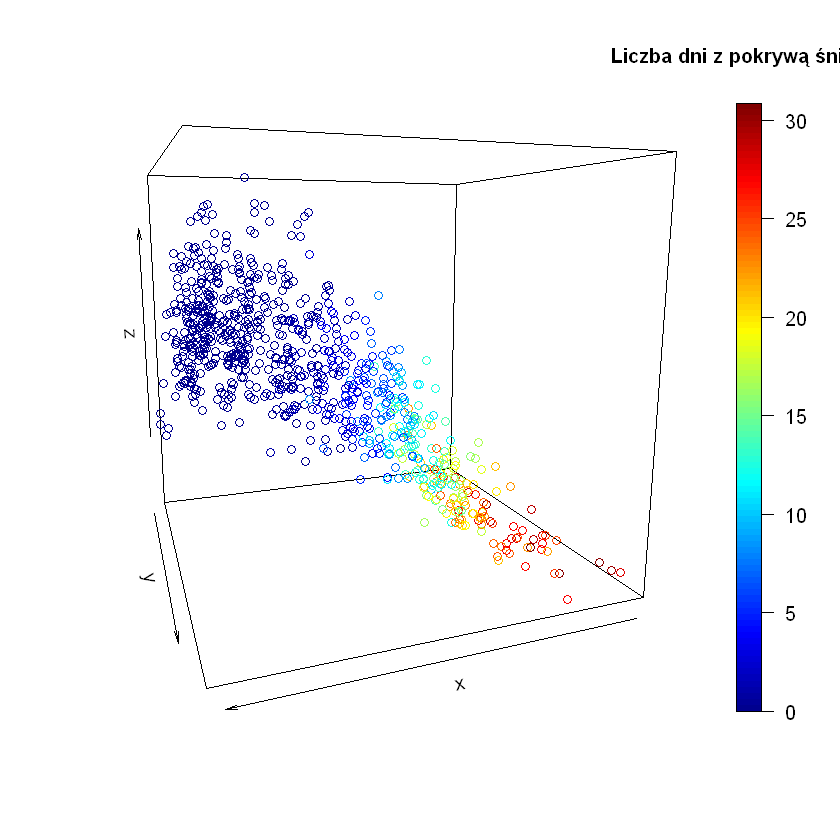

In [91]:
scatter3D(data$avg_temp, data$snowy_days, data$rainy_days, colvar = data$ice_sheet_days, clab = c('Liczba dni z pokrywą śnieżną'), theta = 160, phi = 10)

In [92]:
summary(lm(ice_sheet_days ~ avg_temp + snowy_days + rain + rainy_days, data = data))


Call:
lm(formula = ice_sheet_days ~ avg_temp + snowy_days + rain + 
    rainy_days, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1052 -1.7795  0.1187  1.5709 13.7177 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.894384   0.534265   14.78   <2e-16 ***
avg_temp    -0.331802   0.032890  -10.09   <2e-16 ***
snowy_days   0.756236   0.055208   13.70   <2e-16 ***
rain         0.074065   0.006994   10.59   <2e-16 ***
rainy_days  -0.720742   0.052237  -13.80   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.072 on 833 degrees of freedom
Multiple R-squared:  0.8534,	Adjusted R-squared:  0.8527 
F-statistic:  1212 on 4 and 833 DF,  p-value: < 2.2e-16


# Szeregi czasowe

Odpowiedzią na problemy z regresją liniową w analizie danych meteorologicznych w zależności od czasu są czeregi czasowe. Są one dobrym narzędziem do analizy danych, które zmieniają się cyklicznie, ale mogą posiadać również pewien trend. Przykładem takich zmiennych są dane pogodowe, gdyż są silnie zależne od pory roku.

## Średnia temperatura

Ostatnie 10 lat pomiarów średniej temperatury w miesiącu wskazuje wyraźnie wahania sezonowe.

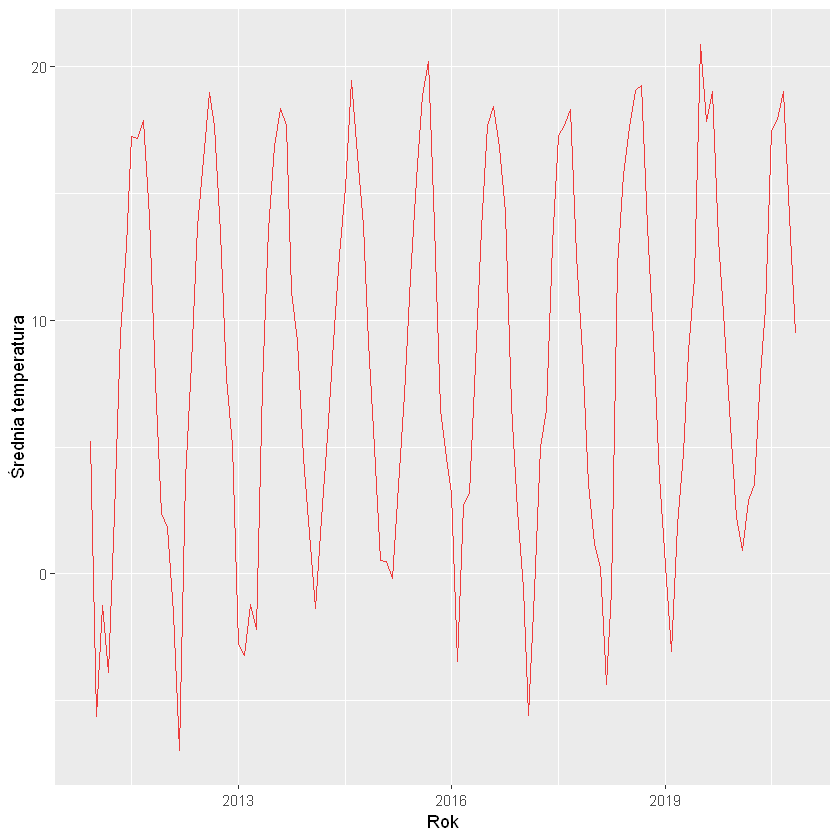

In [93]:
ggplot(tail(data, n = 120), aes((year * 12 + month) / 12, avg_temp)) + 
        labs(y = 'Średnia temperatura', x = 'Rok') + 
        geom_line(col = 'brown2')

Potwierdza to również rozkład wyników na miesiące, gdzie wyraźnie widać różne zakresy temperatur w zależności od miesiąca.

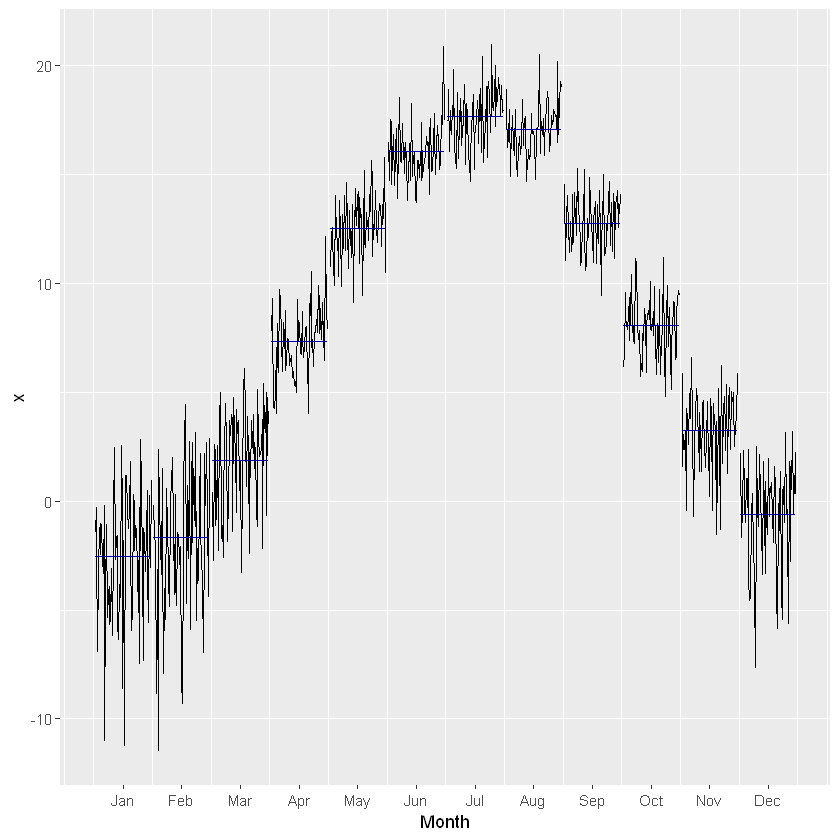

In [94]:
temp <- ts(data$avg_temp, start=c(1951, 1), frequency=12)
ggmonthplot(temp)

Ponadto dekompozycja szeregu ukazuje wręcz idealne wahania sezonowe, natomiast trend nie okazuje się być równomierny.

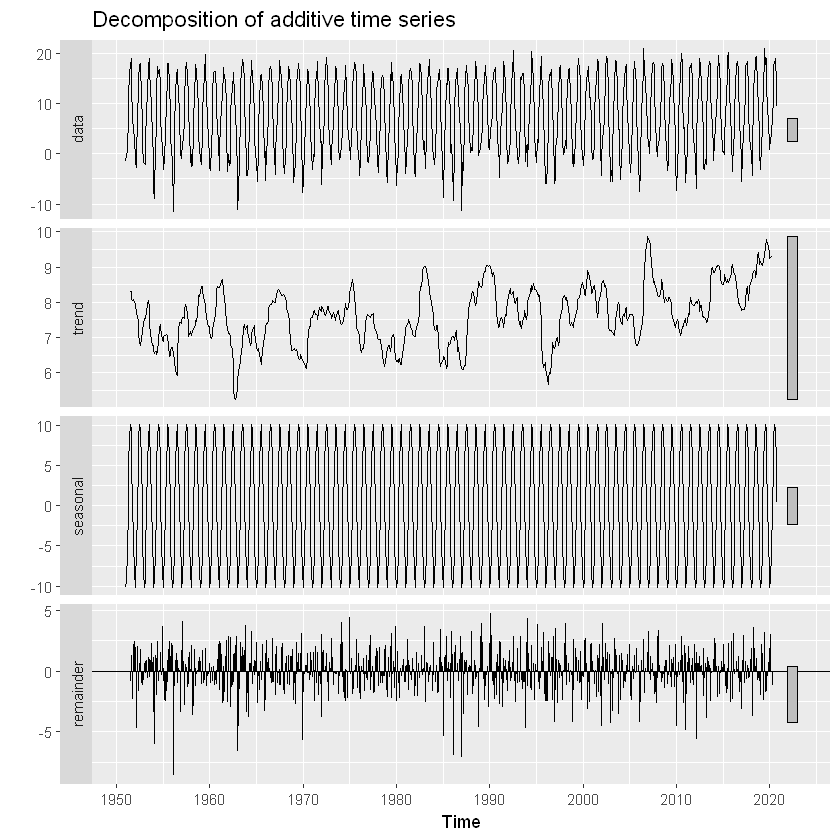

In [95]:
autoplot(decompose(temp))

Po oczyszczeniu szeregu z wahań za pomocą filtra Hodrick-Prescotta widzimy pewną zmienność temperatury w czasie, ale rónież jej gwałtowny wzrost w ostatnich latach.

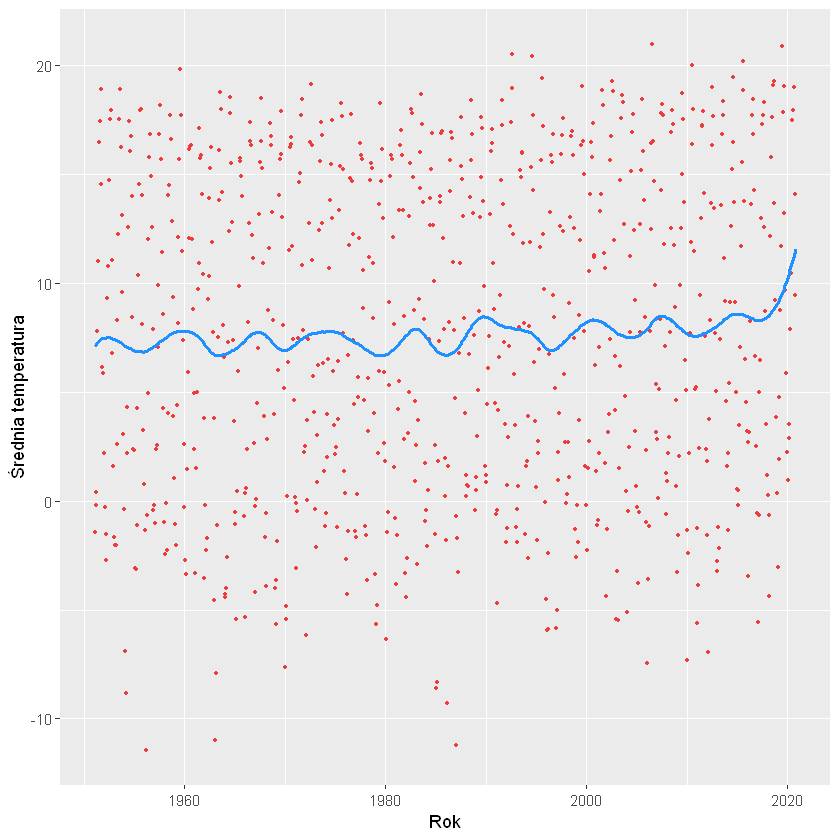

In [96]:
f <- trdhp(data$avg_temp, lambda=14400)
ggplot() + labs(y = 'Średnia temperatura', x = 'Rok') + 
        geom_point(aes((data$year * 12 + data$month) / 12, data$avg_temp), col = 'brown2', size = 0.7) + 
        geom_line(aes((data$year * 12 + data$month) / 12, f), col = 'dodgerblue', size = 1)

Możemy próbować również przewidywać przyszłe wartości średniej temperatury, jednak jest to obarczone pewnym błędem, nawet dla niewielkiego przedziału czasowego.

In [97]:
summary(auto.arima(data$avg_temp))

Series: data$avg_temp 
ARIMA(5,0,0) with non-zero mean 

Coefficients:
         ar1     ar2      ar3      ar4      ar5    mean
      0.5296  0.1658  -0.0157  -0.2362  -0.3579  7.6430
s.e.  0.0322  0.0362   0.0366   0.0362   0.0323  0.0851

sigma^2 estimated as 5.092:  log likelihood=-1870.52
AIC=3755.05   AICc=3755.18   BIC=3788.16

Training set error measures:
                       ME     RMSE      MAE      MPE    MAPE      MASE
Training set -0.002277509 2.248354 1.737193 28.09315 84.1691 0.4650318
                    ACF1
Training set -0.07280344


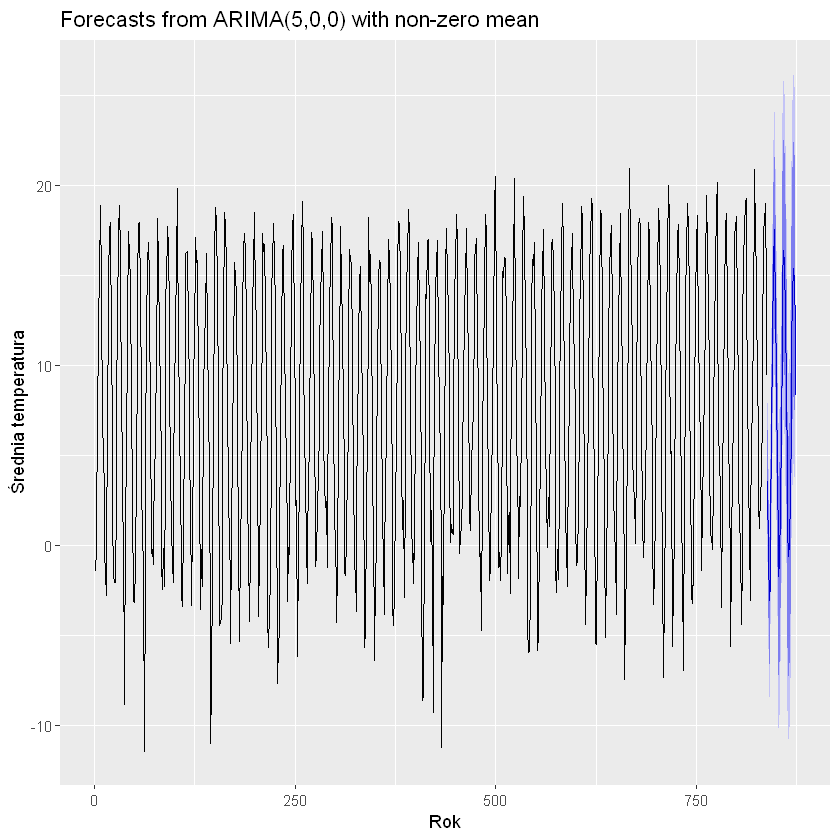

In [98]:
autoplot(forecast(auto.arima(data$avg_temp), h = 36)) + labs(y = 'Średnia temperatura', x = 'Rok')

## Sumaryczny opad

W przypadku opadów sezonowe wahania są również widoczne, ale dane są bardziej "chaotyczne".

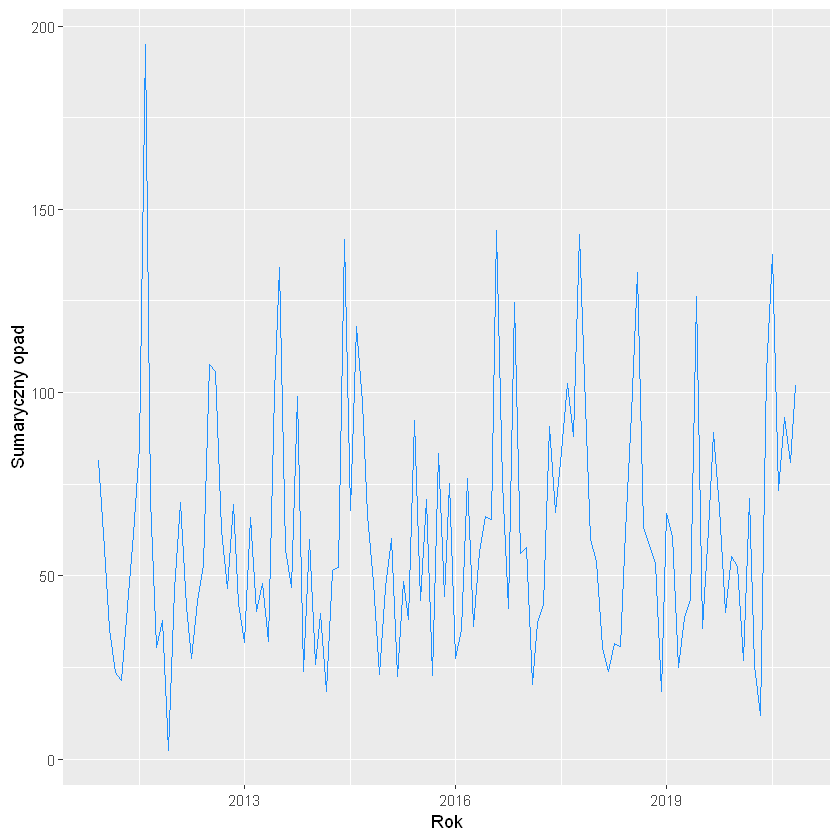

In [99]:
ggplot(tail(data, n = 120), aes((year * 12 + month) / 12, rain)) + 
        labs(y = 'Sumaryczny opad', x = 'Rok') + 
        geom_line(col = 'dodgerblue')

Potwierdza to duży rozrzut pomiarów na wykresie miesięcznym, występuje również nieregularny trend.

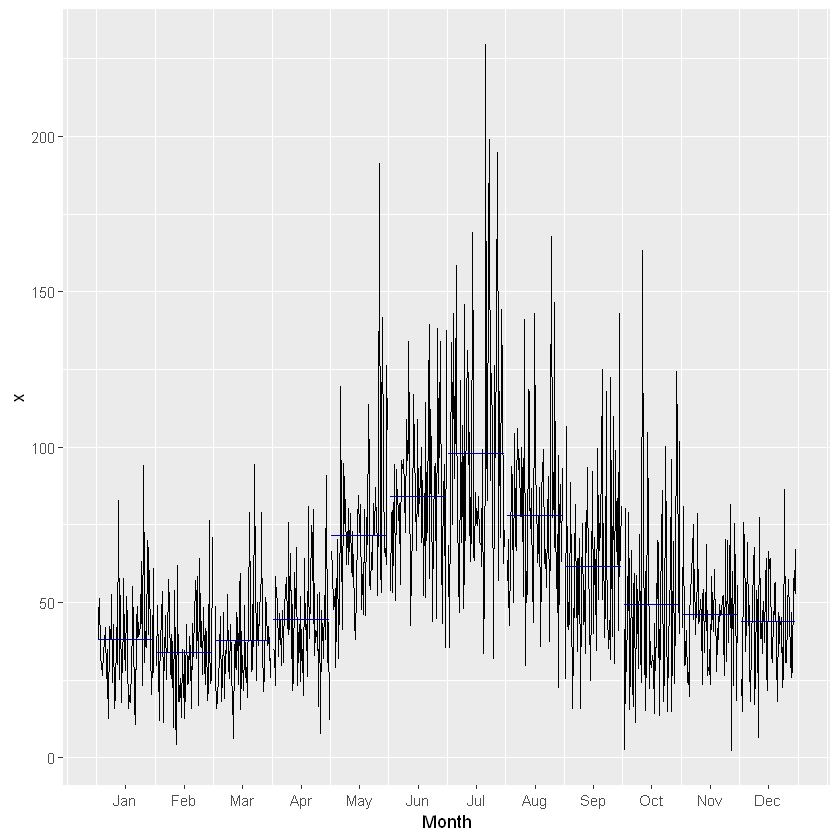

In [100]:
rain <- ts(data$rain, start=c(1951, 1), frequency=12)
ggmonthplot(rain)

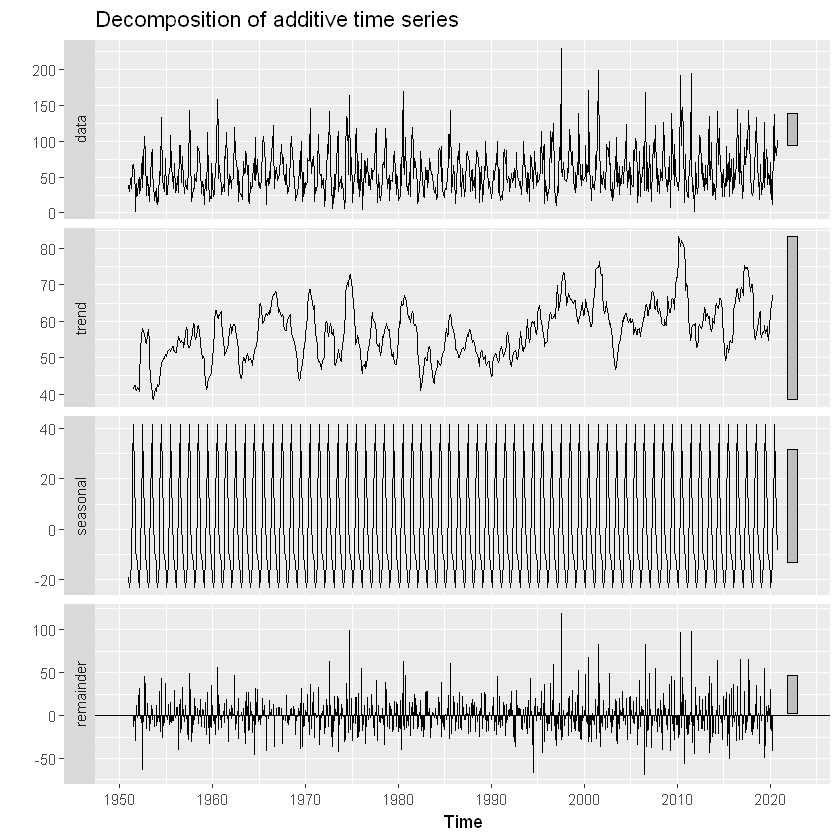

In [101]:
autoplot(decompose(rain))

Analiza z pomocą filtra wskazuje na powolny wzrost wartości zmiennej.

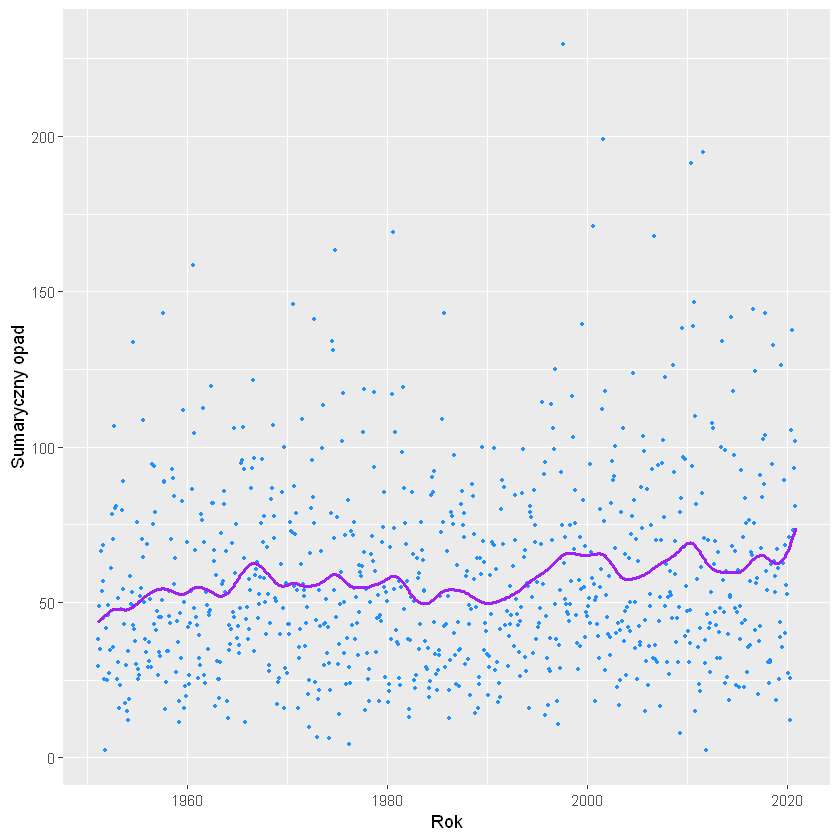

In [102]:
f2 <- trdhp(data$rain, lambda=14400)
ggplot() + labs(y = 'Sumaryczny opad', x = 'Rok') + 
        geom_point(aes((data$year * 12 + data$month) / 12, data$rain), col = 'dodgerblue', size = 0.7) + 
        geom_line(aes((data$year * 12 + data$month) / 12, f2), col = 'purple', size = 1)

Natomiast próby przewidywania wartości zmiennej są bardzo niedokładne.

In [103]:
summary(auto.arima(data$rain))

Series: data$rain 
ARIMA(0,1,1) 

Coefficients:
          ma1
      -0.5571
s.e.   0.0613

sigma^2 estimated as 1039:  log likelihood=-4094.26
AIC=8192.52   AICc=8192.53   BIC=8201.98

Training set error measures:
                    ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set 0.1495469 32.19562 24.23147 -34.84024 62.26143 0.9261476 0.0917121


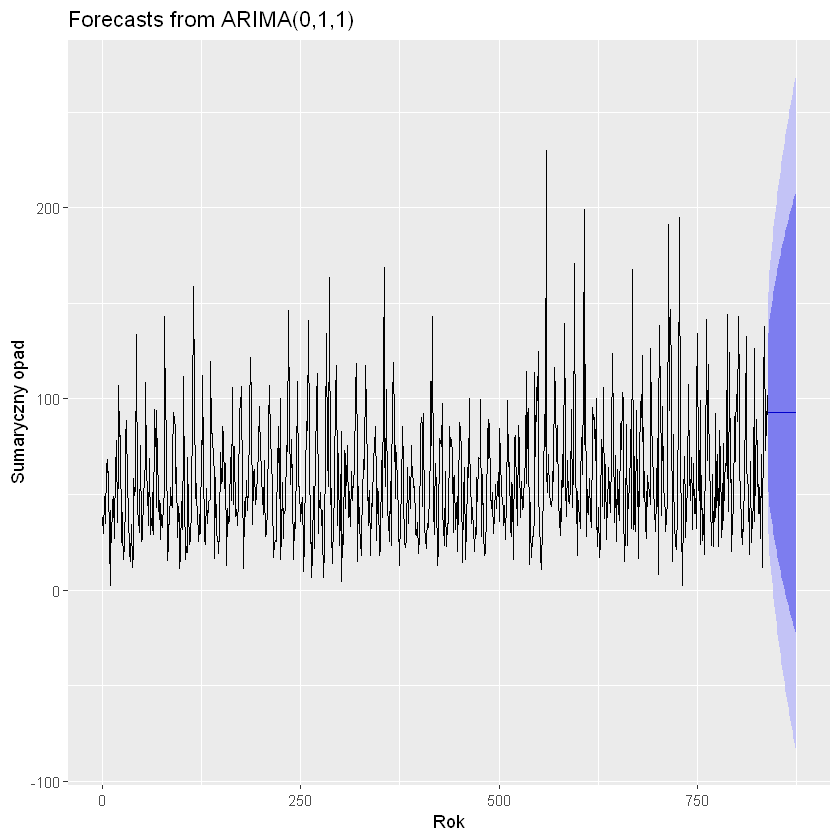

In [104]:
autoplot(forecast(auto.arima(data$rain), h = 36)) + labs(y = 'Sumaryczny opad', x = 'Rok')

## Liczba dni z pokrywą śnieżną

Liczba dni z pokrywą śnieżną jest naturalnie wielkością sezonową.

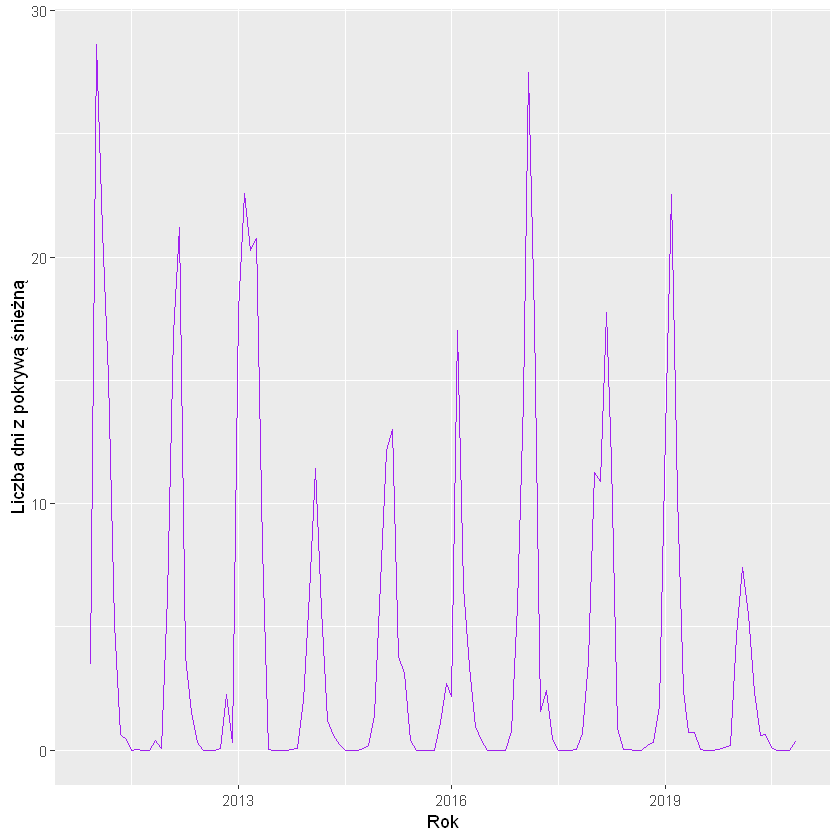

In [105]:
ggplot(tail(data, n = 120), aes((year * 12 + month) / 12, ice_sheet_days)) + 
        labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Rok') + 
        geom_line(col = 'purple')

Występuje jednak duży rozrzut danych oraz bardzo zmienny trend.

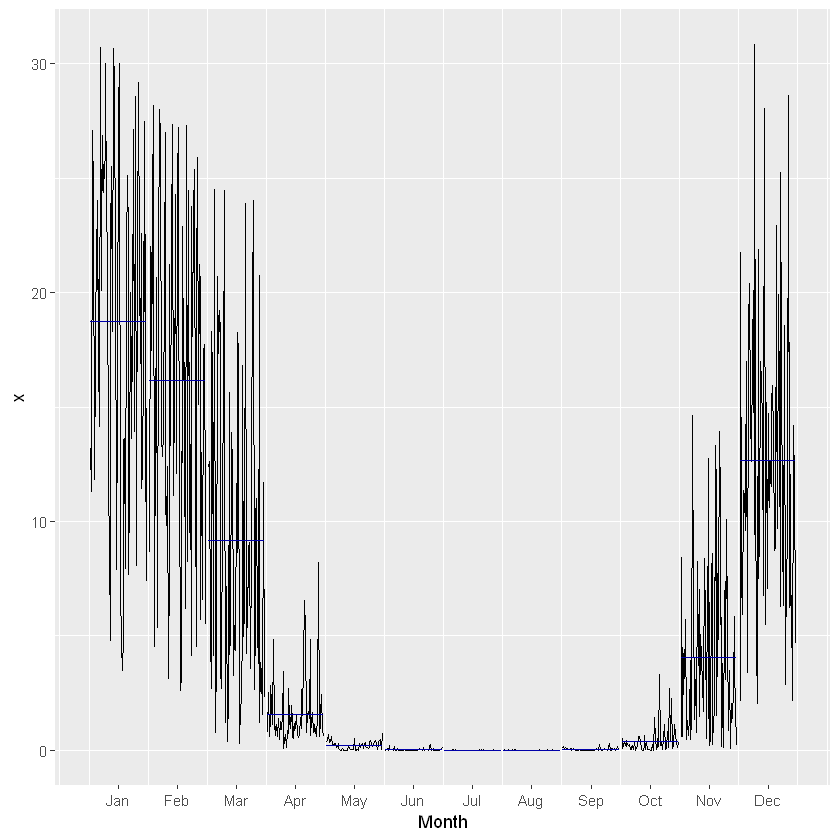

In [106]:
ice_sheet <- ts(data$ice_sheet_days, start=c(1951, 1), frequency=12)
ggmonthplot(ice_sheet)

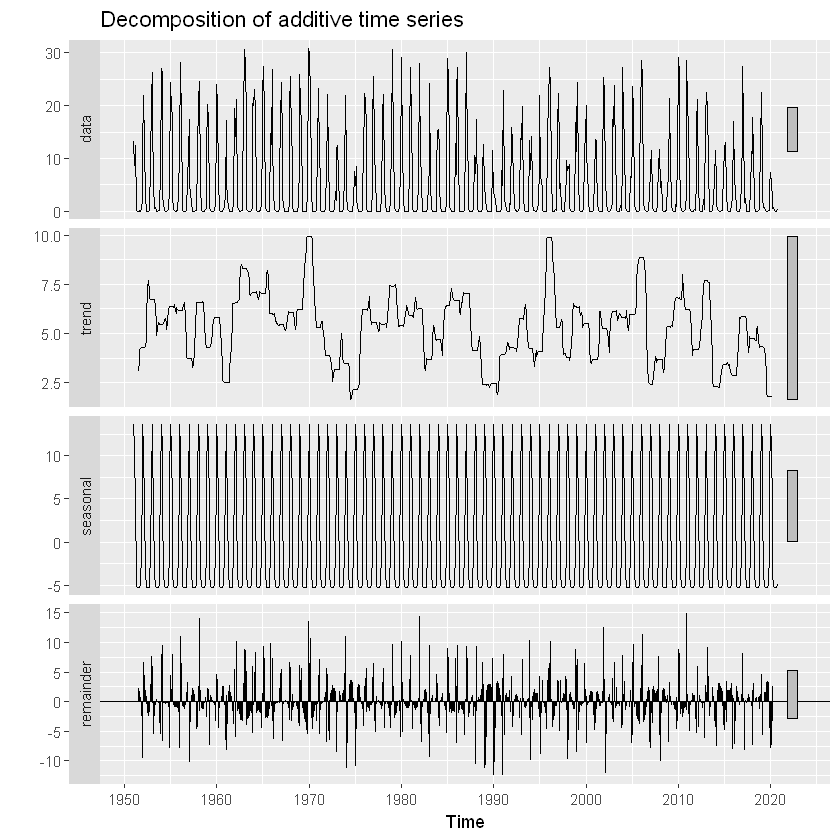

In [107]:
autoplot(decompose(ice_sheet))

Analiza wskazuje na gwałtowny spadek liczby śnieżnych dni w ostatnich latach.

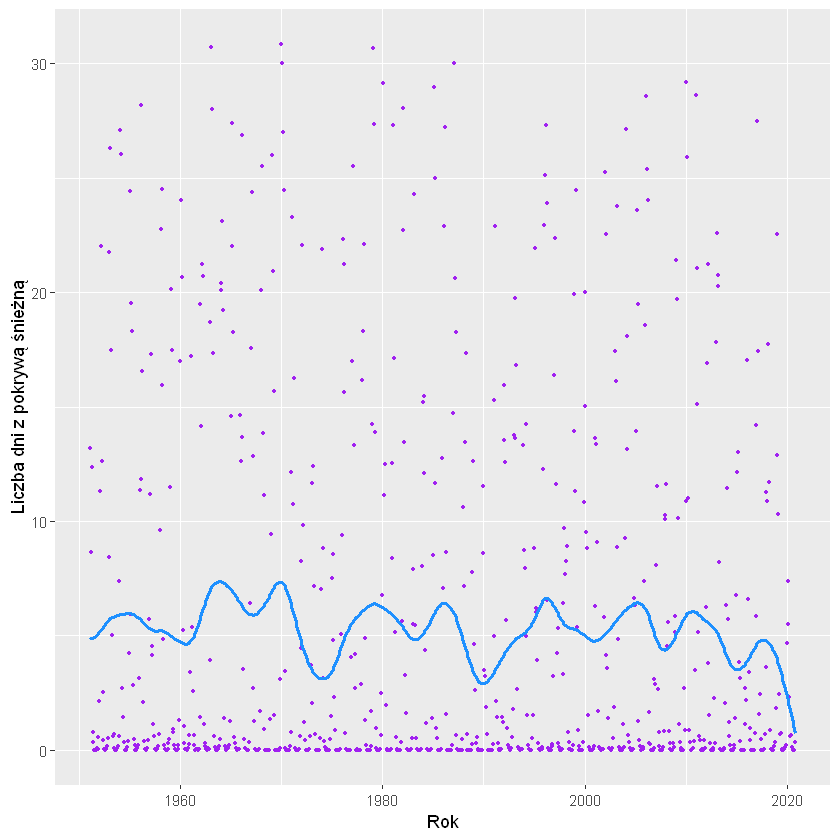

In [108]:
f3 <- trdhp(data$ice_sheet_days, lambda=14400)
ggplot() + labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Rok') + 
        geom_point(aes((data$year * 12 + data$month) / 12, data$ice_sheet_days), col = 'purple', size = 0.7) + 
        geom_line(aes((data$year * 12 + data$month) / 12, f3), col = 'dodgerblue', size = 1)

Ale przewidywania wartości tej zmiennej w przyszłości są bardzo niedokładne.

In [109]:
summary(auto.arima(data$ice_sheet_days))

Series: data$ice_sheet_days 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ma1    mean
      1.4671  -0.7330  -0.7468  5.2579
s.e.  0.0277   0.0238   0.0270  0.1764

sigma^2 estimated as 28.68:  log likelihood=-2594.01
AIC=5198.02   AICc=5198.09   BIC=5221.68

Training set error measures:
                       ME     RMSE      MAE MPE MAPE     MASE        ACF1
Training set 0.0001480284 5.342885 3.897986 NaN  Inf 1.020299 -0.02397963


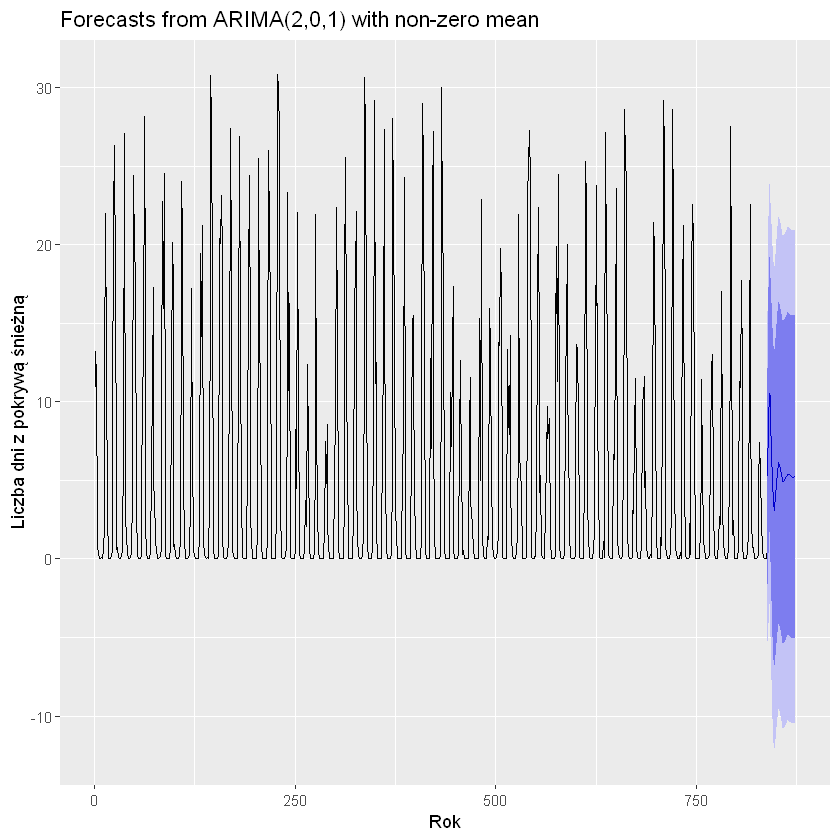

In [110]:
autoplot(forecast(auto.arima(data$ice_sheet_days), h = 36)) + labs(y = 'Liczba dni z pokrywą śnieżną', x = 'Rok')

## Maksymalna wysokość pokrywy śnieżnej

Maksymalna wysokość pokrywy śnieżnej jest bardzo zmienna, jedak również podlega wahaniom sezonowym.

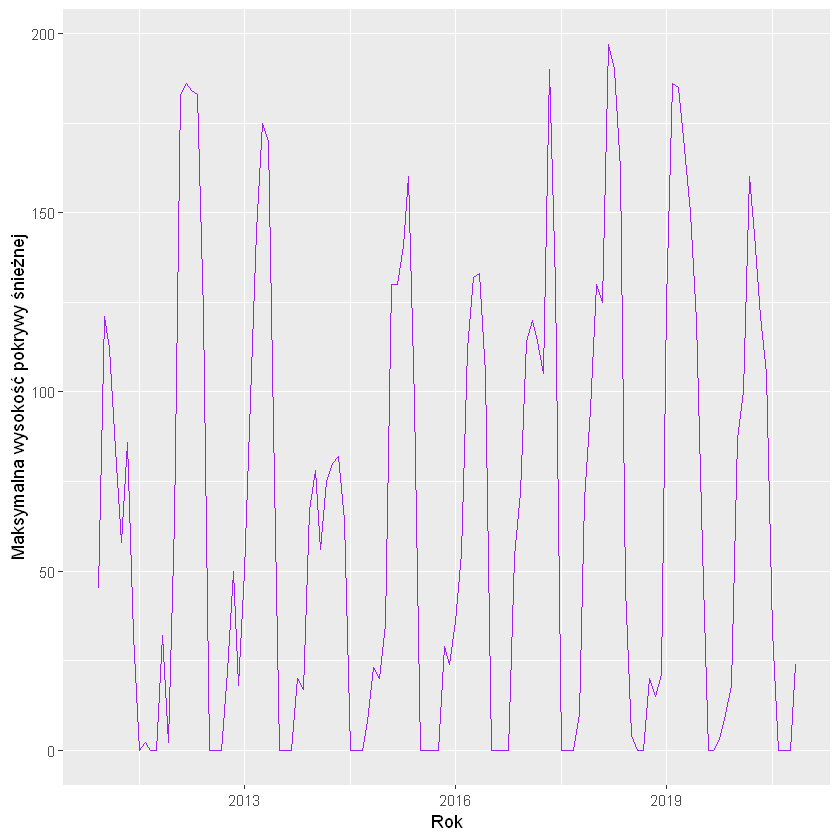

In [111]:
ggplot(tail(data, n = 120), aes((year * 12 + month) / 12, max_snow)) + 
        labs(y = 'Maksymalna wysokość pokrywy śnieżnej', x = 'Rok') + 
        geom_line(col = 'purple')

W zależności od roku, wartości tych pomiarów moga się znacząco różnić.

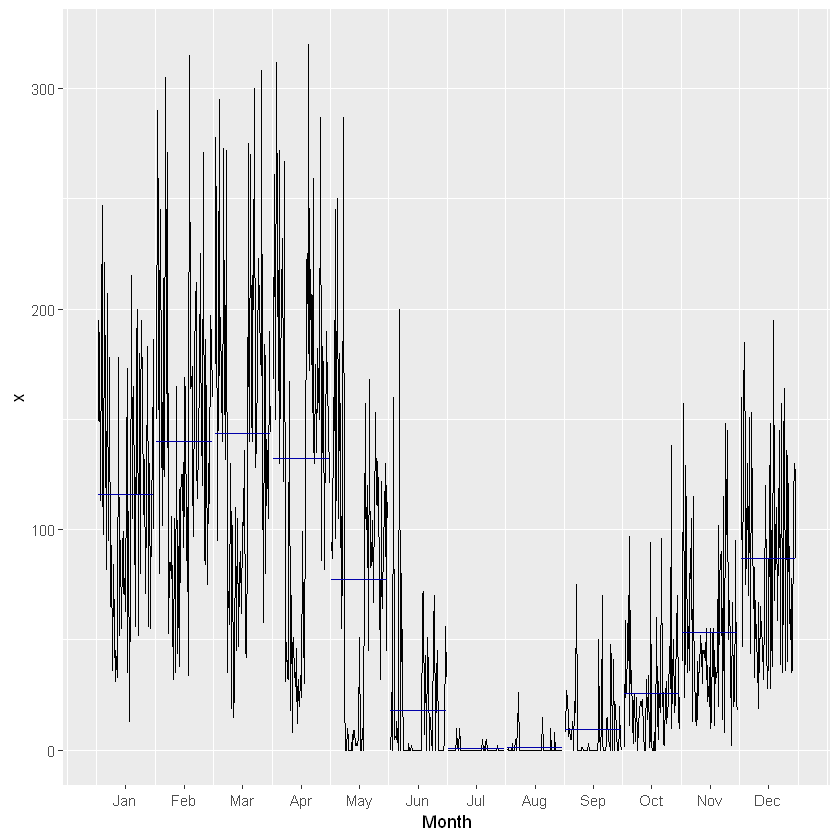

In [112]:
snow <- ts(data$max_snow, start=c(1951, 1), frequency=12)
ggmonthplot(snow)

Interesujące są wskazania linii trendu, która sugeruje znaczny spadek wartości tej zmiennej w latach 1967-1991.

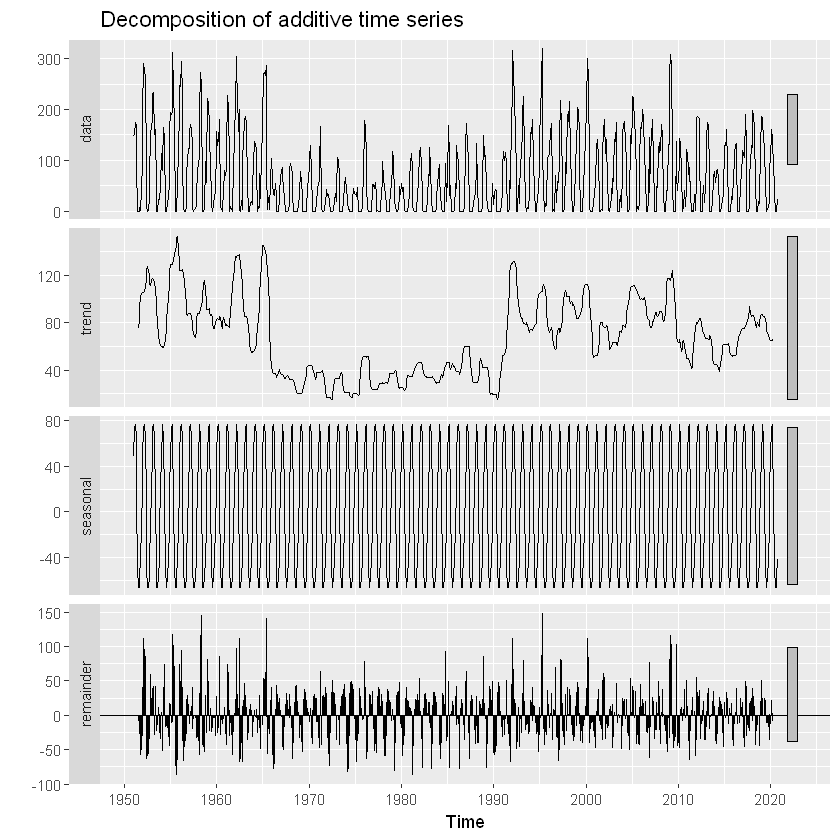

In [113]:
autoplot(decompose(snow))

Spadek ten jest widoczny również po analizie filtrem Hodrick-Prescotta.

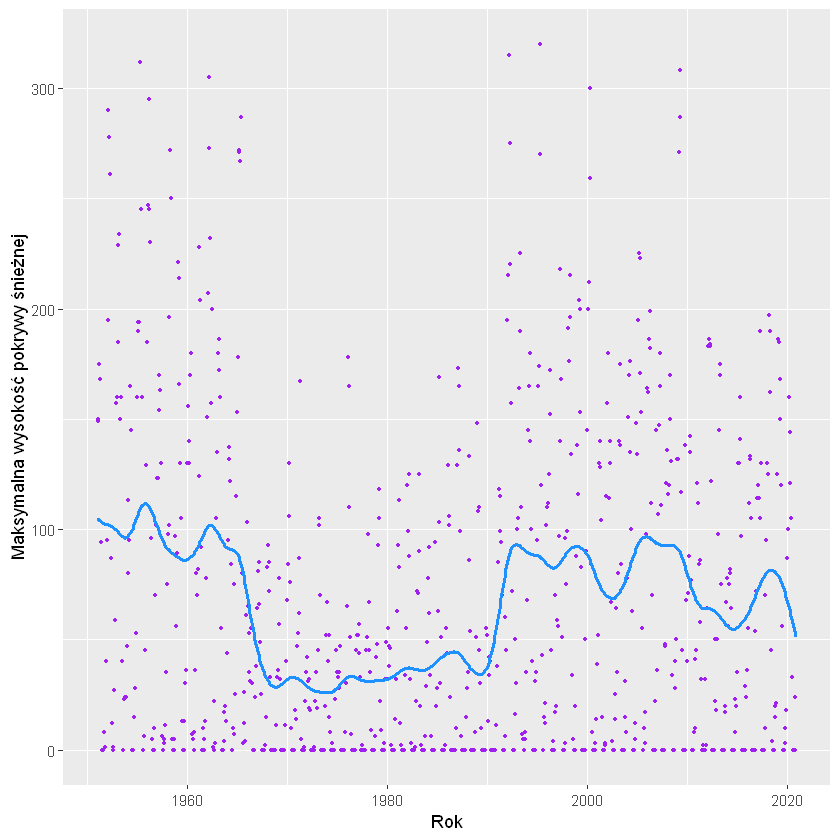

In [114]:
f <- trdhp(data$max_snow, lambda=14400)
ggplot() + labs(y = 'Maksymalna wysokość pokrywy śnieżnej', x = 'Rok') + 
        geom_point(aes((data$year * 12 + data$month) / 12, data$max_snow), col = 'purple', size = 0.7) + 
        geom_line(aes((data$year * 12 + data$month) / 12, f), col = 'dodgerblue', size = 1)

Niestety, przewidywania maksymalnej wysokości pokrywy śnieżnej są również niezwykle niepracyzyjne.

In [115]:
summary(auto.arima(data$max_snow))

Series: data$max_snow 
ARIMA(3,1,2) 

Coefficients:
         ar1      ar2      ar3      ma1     ma2
      1.4929  -0.6732  -0.0858  -1.5947  0.6215
s.e.  0.0498   0.0727   0.0414   0.0373  0.0380

sigma^2 estimated as 1494:  log likelihood=-4245.52
AIC=8503.04   AICc=8503.14   BIC=8531.42

Training set error measures:
                     ME     RMSE      MAE MPE MAPE      MASE         ACF1
Training set -0.3436264 38.51271 27.16272 NaN  Inf 0.8654105 -0.008260913


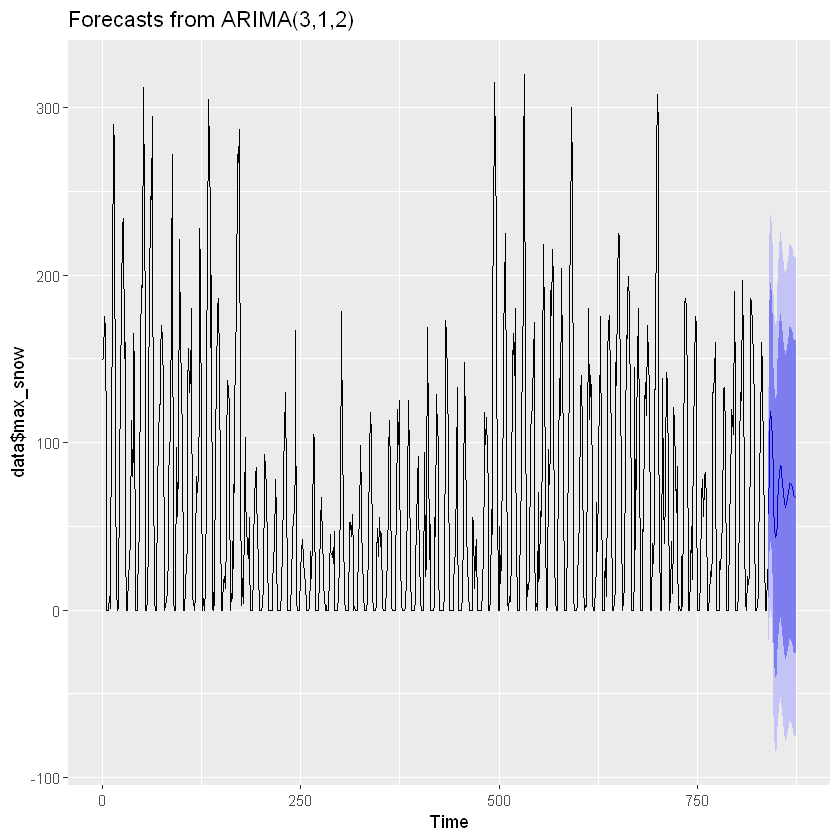

In [116]:
autoplot(forecast(auto.arima(data$max_snow), h = 36))